In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_34084/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob
from datetime import datetime
import random


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [3]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

### set seed for reproducibility

In [4]:
seed = 42

In [5]:
torch.manual_seed(seed)
#torch.use_deterministic_algorithms(True) # not good: this makes the training break
random.seed(seed)

### create output directory to save checkpoints

In [6]:
#today = date.today()
now = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = str(now)+'_checkpoints'
os.makedirs(out_dir, exist_ok=True) #check if output dir exist
print(out_dir)

20250225_204807_checkpoints


### tensors features

In [7]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

### Load input data

In [8]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

#### Photon dataset (energy spread: 10-1000 GeV)

In [9]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.34it/s]


nskipped | ntotal: 119  |  50000


#### Pion dataset: pion sample from where high energy early showering pions are removed

In [10]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/500 [00:28<00:00, 16.88it/s]


nskipped | ntotal: 20625  |  70628


#### Pion dataset: low energy clusters within CEE + others (no CEE restrictions)

In [11]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|███████████████████▌                                                                                                 | 1/6 [00:38<03:10, 38.19s/it]


nskipped | ntotal: 0  |  95549


In [12]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 95549


### Define training and testing datasets

In [13]:
nphos = len(pho_dataset)
idxstotsamp = np.arange(nphos)

### DEFINE Background COMPOSITION
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.7*nphos)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
## load train and test dataset
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)
## load all data, for plots later
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)


print("total samples > npho | nhizpu | nlozpu | nTOT:",len(pho_dataset)," | ",len(hizpusel)," | ",len(lowzpusel)," | ",nsamp)
print("N_train, N_test:",len(trdata),",",len(tsdata))

total samples > npho | nhizpu | nlozpu | nTOT: 49881  |  14964  |  34916  |  99761
N_train, N_test: 79808 , 19953


### Define model

In [14]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            #nn.Dropout(0.2),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            #nn.Dropout(0.2),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                #dropout = 0.2,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    #nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    #nn.Dropout(0.2),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    #nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

### define training and testing functions

In [15]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


### Define output, training parameters, and launch training

epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:31<00:00,  4.19it/s]


train loss: 0.19972590830371673
train acc: 0.9312099


  0%|                                                                                                                            | 0/34 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.33it/s]


test loss: 0.11427151959608584
test acc: 0.9533905
new best acc: 0.9533905
epoch: 1
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.055727073940128755
train acc: 0.9811047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.029839752461103833
test acc: 0.99022704
new best acc: 0.99022704
epoch: 2
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.024877261167128028
train acc: 0.99114126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.020186347996487337
test acc: 0.99358493
new best acc: 0.99358493
epoch: 3
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.020622869651180816
train acc: 0.9930082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


test loss: 0.021080971955705213
test acc: 0.992332
epoch: 4
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.01907618889437338
train acc: 0.99327135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.025487284230835298
test acc: 0.99007666
epoch: 5
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.018039972759937368
train acc: 0.9936598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.02025105304303853
test acc: 0.9920313
epoch: 6
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.01628955468620563
train acc: 0.9942988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.01448052765472847
test acc: 0.99478775
new best acc: 0.99478775
epoch: 7
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.015385480607986196
train acc: 0.9944241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.021300040548393392
test acc: 0.99253243
epoch: 8
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.015729251508809515
train acc: 0.99431133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.01302070407580365
test acc: 0.9951887
new best acc: 0.9951887
epoch: 9
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013572867400249216
train acc: 0.9951885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.010303109781542683
test acc: 0.99654186
new best acc: 0.99654186


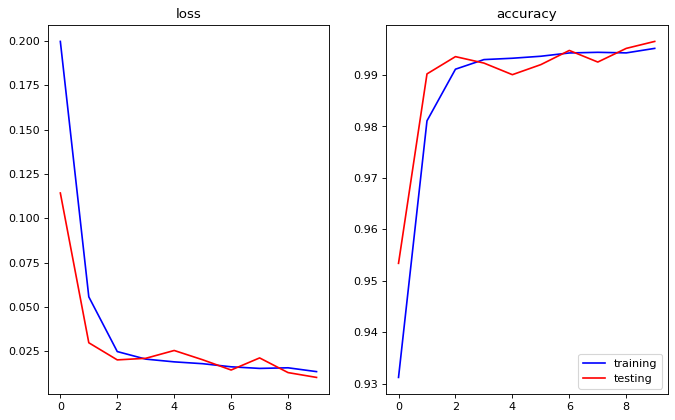

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


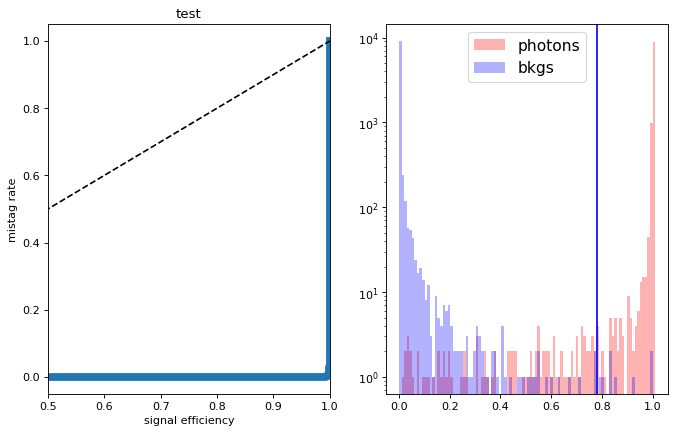

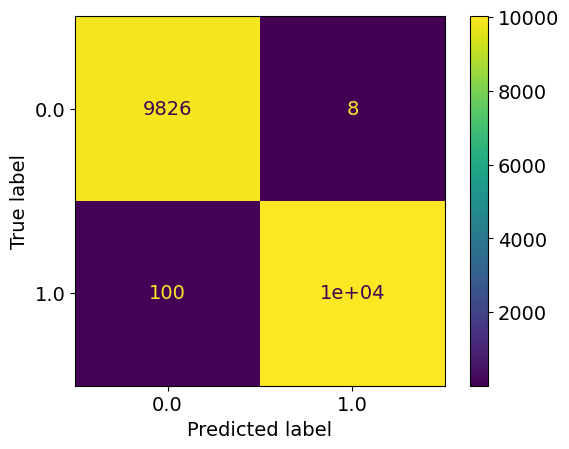

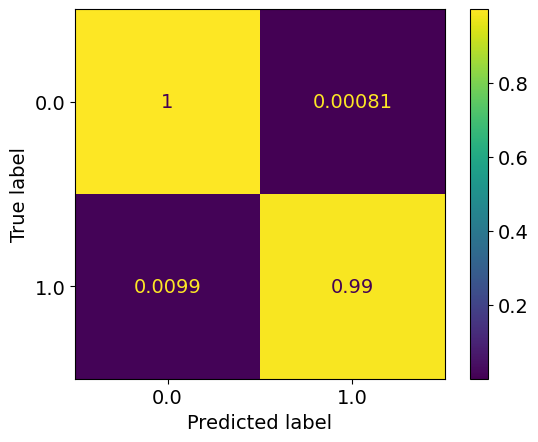

epoch: 10
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.013967064778001652
train acc: 0.99485016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.01243871487403179
test acc: 0.9955896
epoch: 11
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012977572881638155
train acc: 0.9954641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.014657048679723898
test acc: 0.99463737
epoch: 12
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.013989209089733994
train acc: 0.99497545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.01352633409859503
test acc: 0.9947376
epoch: 13
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013034327318822382
train acc: 0.99528867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.012949363301124643
test acc: 0.99553955
epoch: 14
Learning rate: 0.0008188926045137138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011963495585038814
train acc: 0.9958024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.71it/s]


test loss: 0.01492639007697375
test acc: 0.9940861
epoch: 15
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011451523274065121
train acc: 0.99573976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.010743448202607824
test acc: 0.99584025
epoch: 16
Learning rate: 0.0007681113183592135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011082024961612674
train acc: 0.99592775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.012516747687614578
test acc: 0.99523884
epoch: 17
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011853830579584881
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.027484672451357578
test acc: 0.9921816
epoch: 18
Learning rate: 0.0007131017565522499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.023985594370725578
train acc: 0.99265736


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.016390674309257197
test acc: 0.9941362
epoch: 19
Learning rate: 0.0006842802396059903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011787986553989962
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.014749567969428265
test acc: 0.9948379


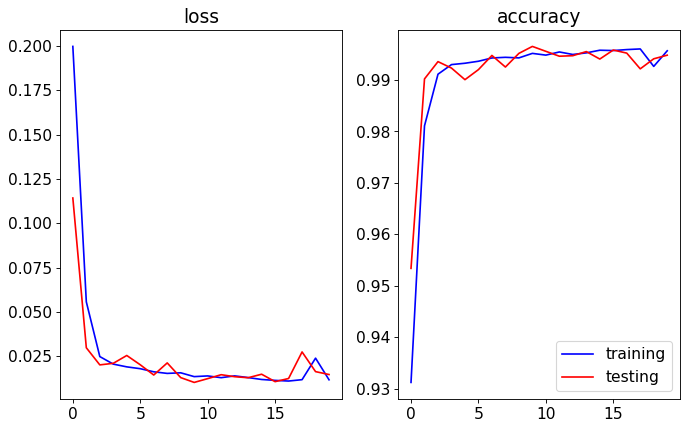

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


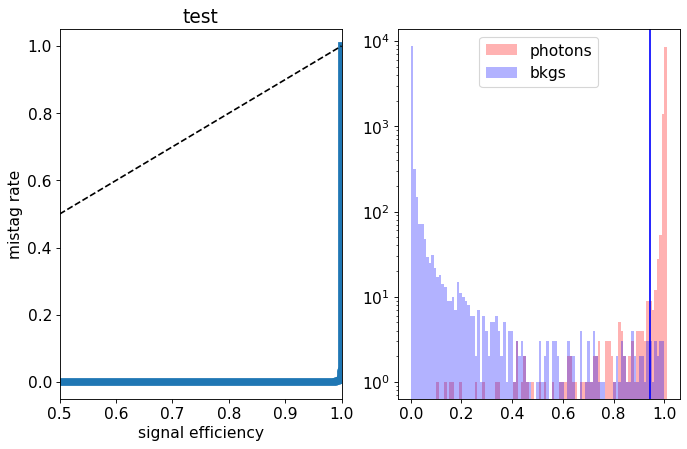

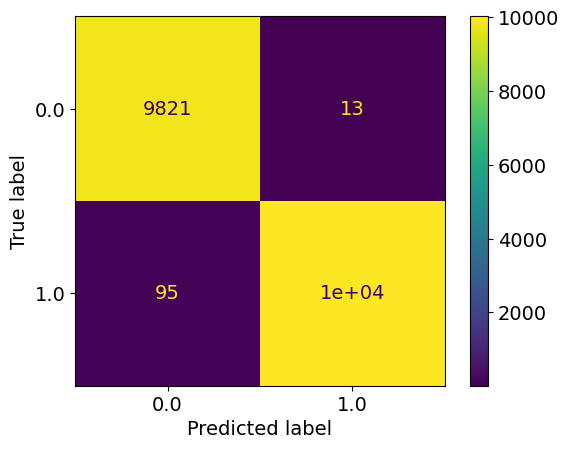

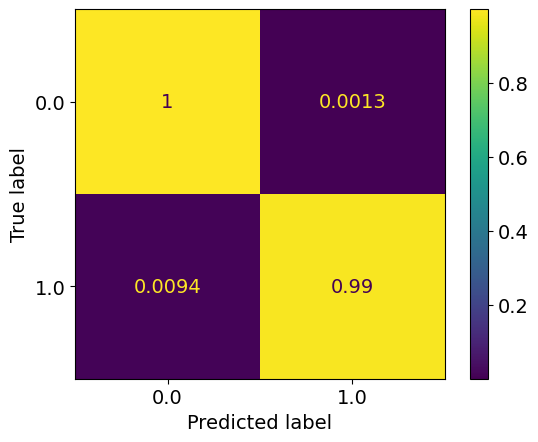

epoch: 20
Learning rate: 0.0006547314527436388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010560177517672584
train acc: 0.9962786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.012954472139587296
test acc: 0.9960908
epoch: 21
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011556093977180435
train acc: 0.9958275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.01179761009509949
test acc: 0.99553955
epoch: 22
Learning rate: 0.0005939209414931709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009931759053055864
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.010741531739340109
test acc: 0.9954393
epoch: 23
Learning rate: 0.0005628992084112799


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.009691727543797051
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.01322690600200611
test acc: 0.9952889
epoch: 24
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010934140537552702
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.01650087658644599
test acc: 0.9940861
epoch: 25
Learning rate: 0.0005002344472043634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.014181348018230065
train acc: 0.9951885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.015220917768173796
test acc: 0.9945372
epoch: 26
Learning rate: 0.0004688387282630152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008943061535237983
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.008714919300366412
test acc: 0.99684256
new best acc: 0.99684256
epoch: 27
Learning rate: 0.0004375659886249822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00945534251122944
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.23it/s]


test loss: 0.014104949885650593
test acc: 0.9951386
epoch: 28
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01349979193276055
train acc: 0.99556434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.009671236314769724
test acc: 0.996191
epoch: 29
Learning rate: 0.0003758821517012554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.008536589696374374
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.010390553873388426
test acc: 0.99594045


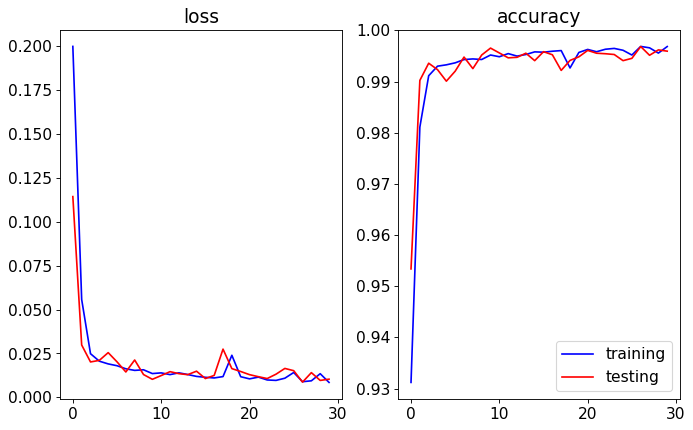

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.81it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


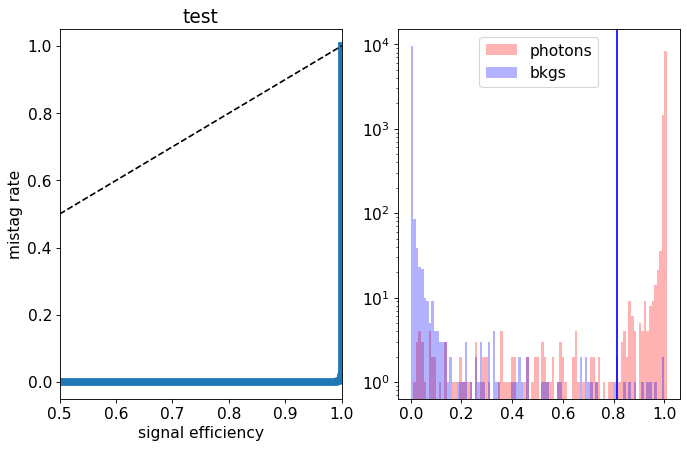

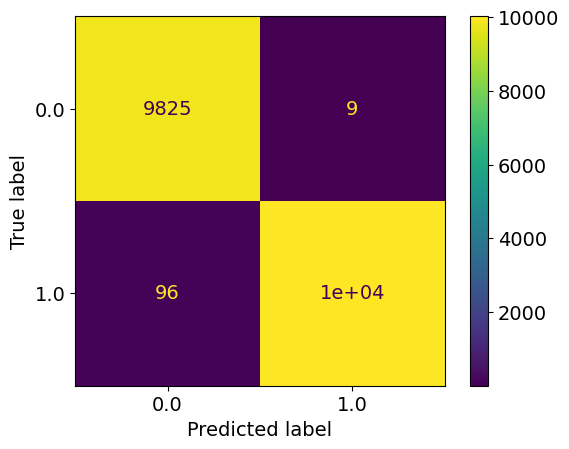

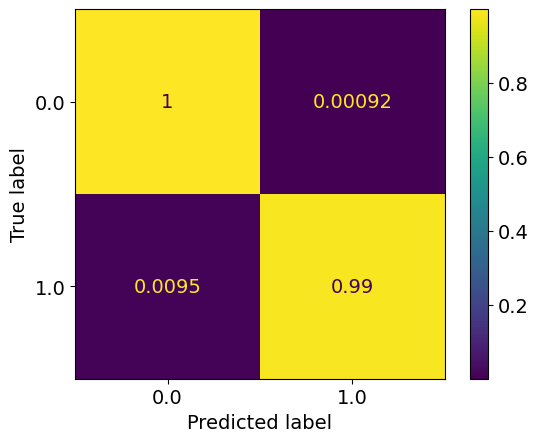

epoch: 30
Learning rate: 0.00034571449233923525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00919543302777821
train acc: 0.9964289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.014020446934463346
test acc: 0.994888
epoch: 31
Learning rate: 0.0003161557273896085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009255074714345219
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.38it/s]


test loss: 0.008899687741444829
test acc: 0.99654186
epoch: 32
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.008543430155129242
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.009569272248293547
test acc: 0.99614096
epoch: 33
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00858388552893954
train acc: 0.99701786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.009392875253551584
test acc: 0.9969428
new best acc: 0.9969428
epoch: 34
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.011737980281368573
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.00835364600917434
test acc: 0.99714327
new best acc: 0.99714327
epoch: 35
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.008223467171204115
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.008624779283041683
test acc: 0.9969428
epoch: 36
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.007704021959086018
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.009172086891553858
test acc: 0.99654186
epoch: 37
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.007642065965024921
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.008557796539903125
test acc: 0.99679244
epoch: 38
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.007551867877119453
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.008588305450222619
test acc: 0.99699295
epoch: 39
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.00757227066701014
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.008178247313480824
test acc: 0.99684256


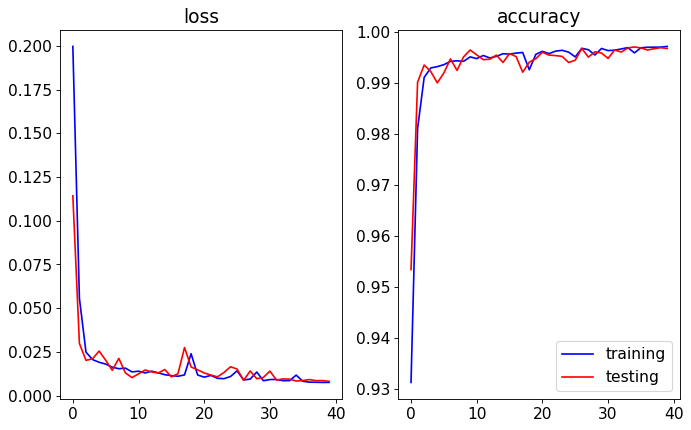

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


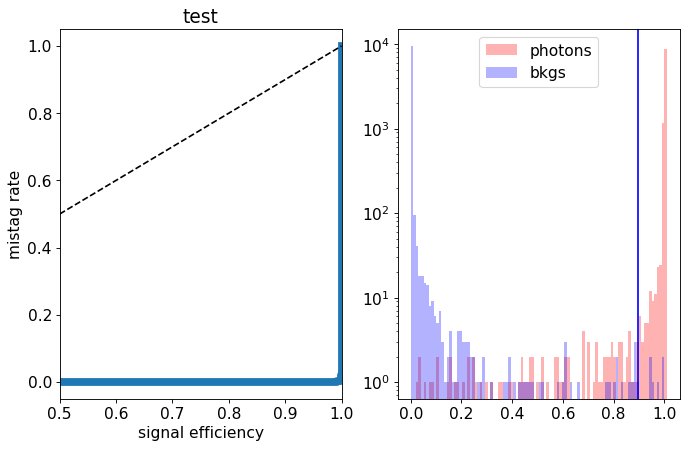

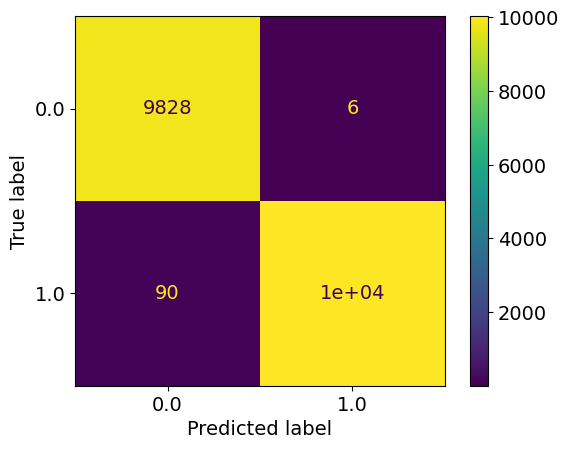

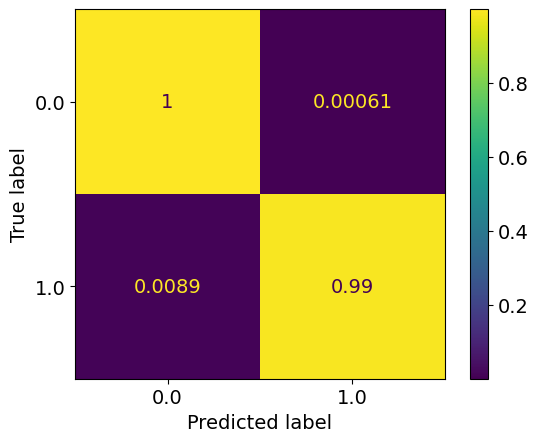

epoch: 40
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.007367039251913588
train acc: 0.9973311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.00804058339460479
test acc: 0.9971934
new best acc: 0.9971934
epoch: 41
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.007398532009370792
train acc: 0.99718076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.007961922417641343
test acc: 0.99709314
epoch: 42
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.007139016685611221
train acc: 0.9973687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.008346693275277229
test acc: 0.99709314
epoch: 43
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.007106433359735798
train acc: 0.99726844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.008944128071615362
test acc: 0.9969428
epoch: 44
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.007020916117137709
train acc: 0.99731857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.008201826911638765
test acc: 0.9969428
epoch: 45
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.007111741409944579
train acc: 0.99714315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.00824954206644393
test acc: 0.9969428
epoch: 46
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.007143284836193241
train acc: 0.9972559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.22it/s]


test loss: 0.008071773387628663
test acc: 0.9970431
epoch: 47
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.006949680535480686
train acc: 0.9973937


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.00807026817004525
test acc: 0.99709314
epoch: 48
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.007008792449365745
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.008020320542581269
test acc: 0.99709314
epoch: 49
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.007109149772589656
train acc: 0.99743134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.008083989583503674
test acc: 0.99709314


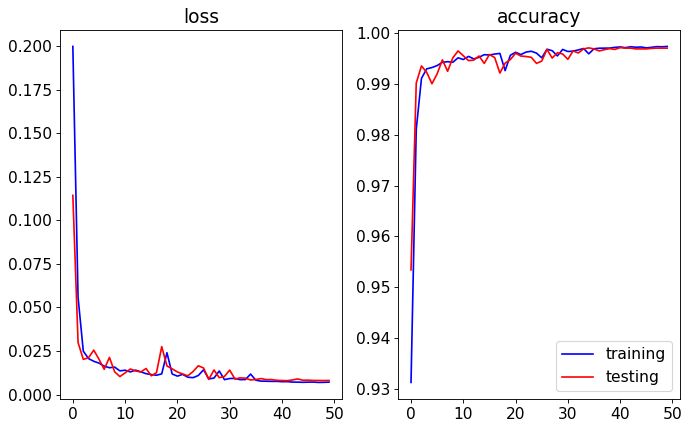

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


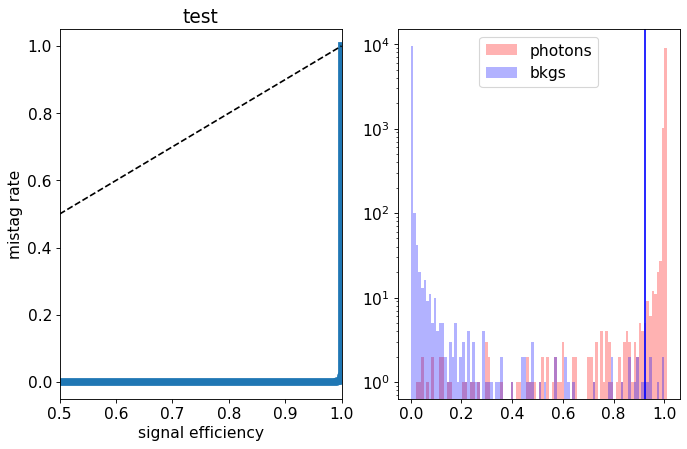

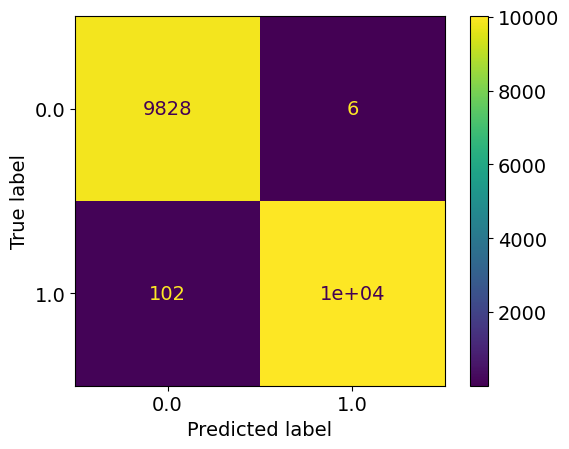

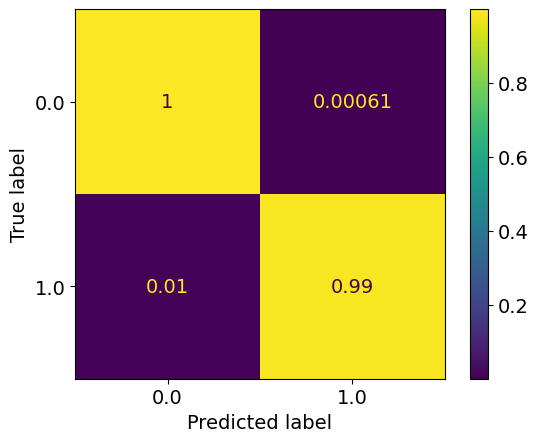

epoch: 50
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01812027214751353
train acc: 0.99372244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.011574058772941284
test acc: 0.9951887
epoch: 51
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.01088051507058345
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.014432066948810482
test acc: 0.99403596
epoch: 52
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01117181688709934
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.012823945267454666
test acc: 0.99503833
epoch: 53
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.011170563366711088
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.23it/s]


test loss: 0.014824475401409846
test acc: 0.9951887
epoch: 54
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.010362770306745738
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.010484659804633874
test acc: 0.99574
epoch: 55
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.011121430431028702
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.01545089390128851
test acc: 0.9945873
epoch: 56
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010492220663923375
train acc: 0.99586505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.009829629085930613
test acc: 0.99614096
epoch: 57
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.00897270443933102
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.010706665172405979
test acc: 0.99594045
epoch: 58
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010259529524448035
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.012885573676184696
test acc: 0.99538916
epoch: 59
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008917860235913991
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.17it/s]


test loss: 0.013480261742027806
test acc: 0.9949381


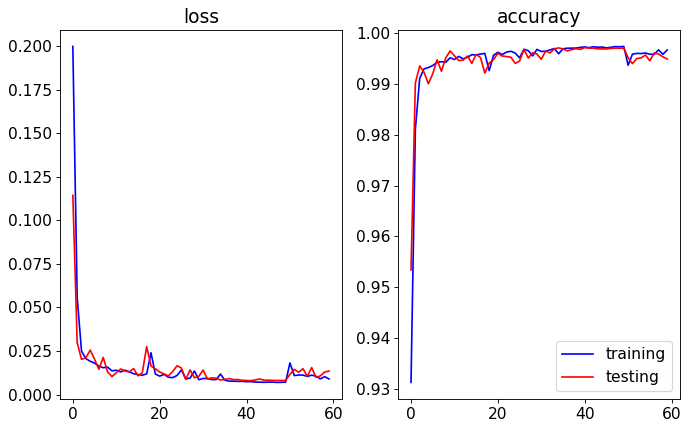

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


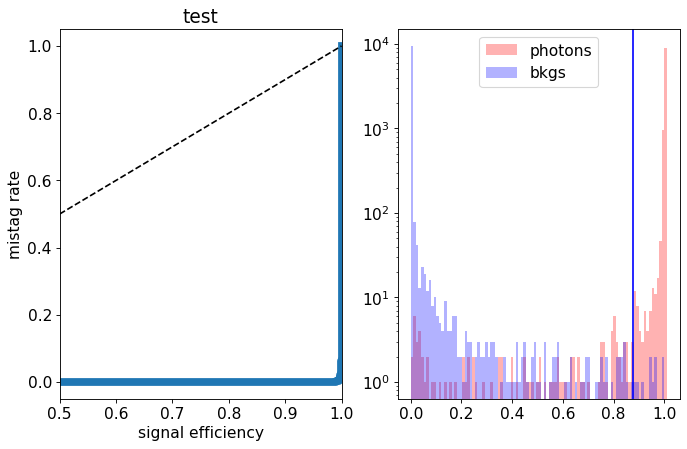

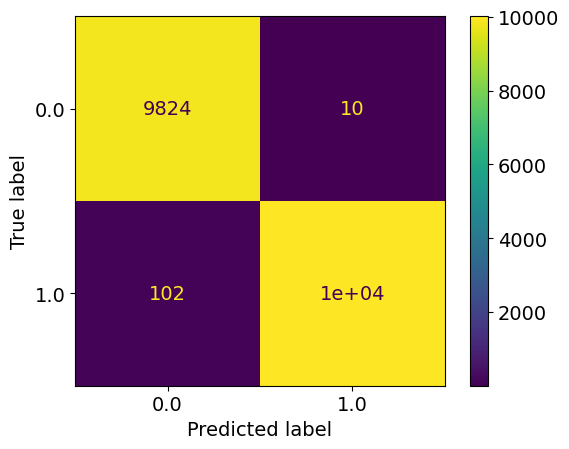

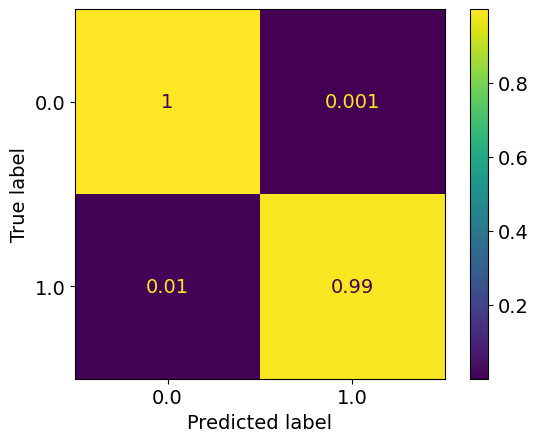

epoch: 60
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008799446462618826
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.00956968784756849
test acc: 0.99624115
epoch: 61
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.00924848989667334
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.009398807009668364
test acc: 0.996191
epoch: 62
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008900390381910908
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.014170624699224444
test acc: 0.99478775
epoch: 63
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.009292839404957676
train acc: 0.99635375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.11it/s]


test loss: 0.008637079078813685
test acc: 0.99654186
epoch: 64
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.009164548692636467
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.50it/s]


test loss: 0.01002785625442972
test acc: 0.99649173
epoch: 65
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.52it/s]


train loss: 0.009290774767143729
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]


test loss: 0.009564319515929502
test acc: 0.9962913
epoch: 66
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.008714580126089364
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.77it/s]


test loss: 0.011164718444513924
test acc: 0.9958903
epoch: 67
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008039516861613062
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.009997102993485682
test acc: 0.9960908
epoch: 68
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.00971333555044926
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.69it/s]


test loss: 0.009249888983664705
test acc: 0.99649173
epoch: 69
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.008397322896639504
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.12it/s]


test loss: 0.00876929926658597
test acc: 0.99674237


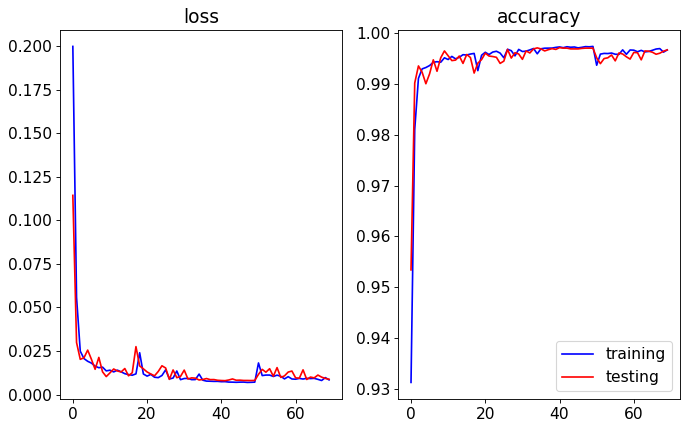

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


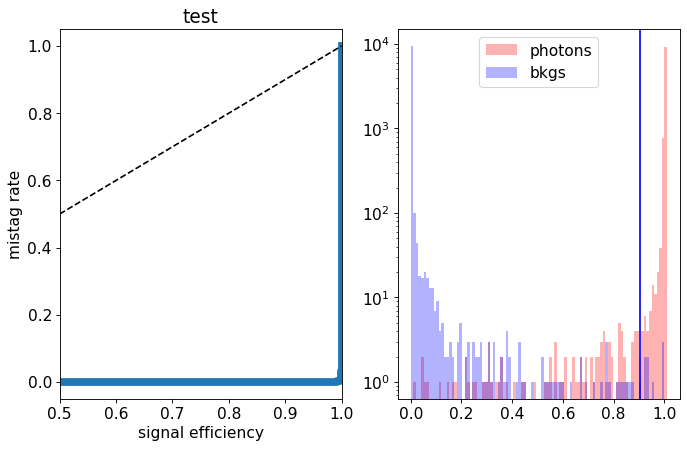

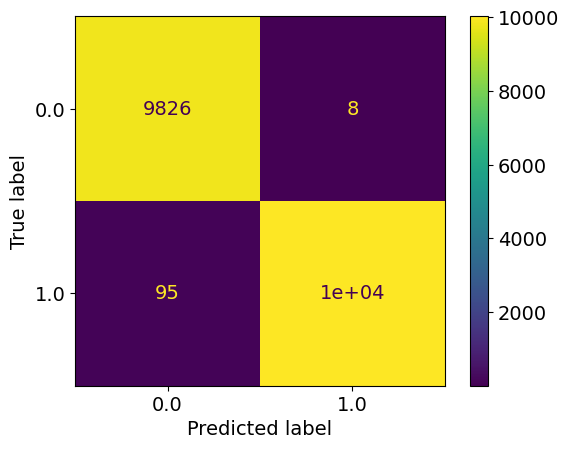

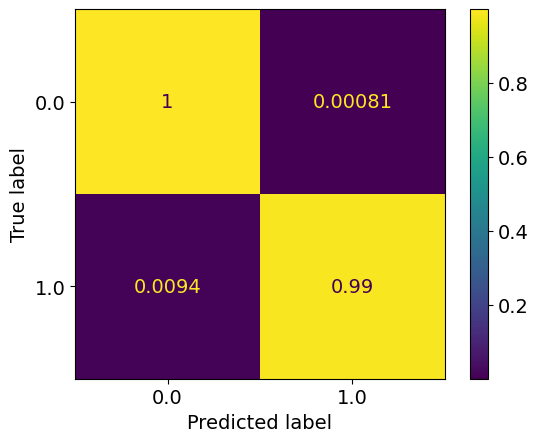

epoch: 70
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.007838294778281777
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.008746328900622971
test acc: 0.99669224
epoch: 71
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.007925675801607891
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.008423886169432937
test acc: 0.99684256
epoch: 72
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.007391734093058647
train acc: 0.9973687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.04it/s]


test loss: 0.013200500740340966
test acc: 0.9949381
epoch: 73
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008018634559190484
train acc: 0.99726844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.010536327221790784
test acc: 0.9957901
epoch: 74
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.008806505972928274
train acc: 0.9967923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.98it/s]


test loss: 0.008235436675878352
test acc: 0.99709314
epoch: 75
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.006997532398202959
train acc: 0.997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.008318873781450641
test acc: 0.9971934
epoch: 76
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.007382679623537006
train acc: 0.9972308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.11it/s]


test loss: 0.007666447816197486
test acc: 0.9968927
epoch: 77
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.0071287855457892796
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


test loss: 0.00882567441337468
test acc: 0.99639153
epoch: 78
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.0067389802346979055
train acc: 0.997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.73it/s]


test loss: 0.007134006246547762
test acc: 0.9972435
new best acc: 0.9972435
epoch: 79
Learning rate: 0.0003758821517012555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.006476143746873114
train acc: 0.99744385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.007358020358986002
test acc: 0.99729365
new best acc: 0.99729365


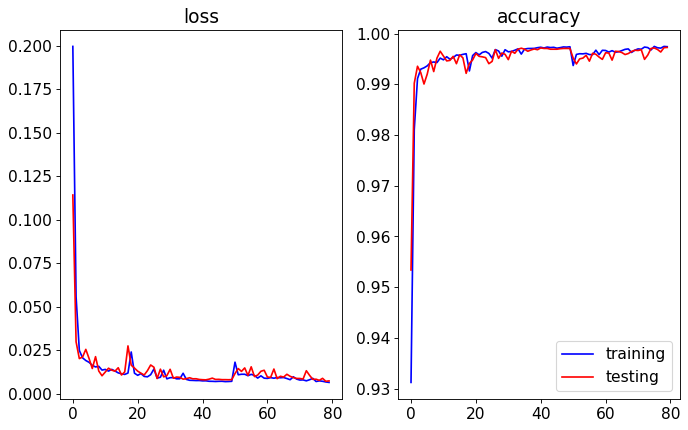

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


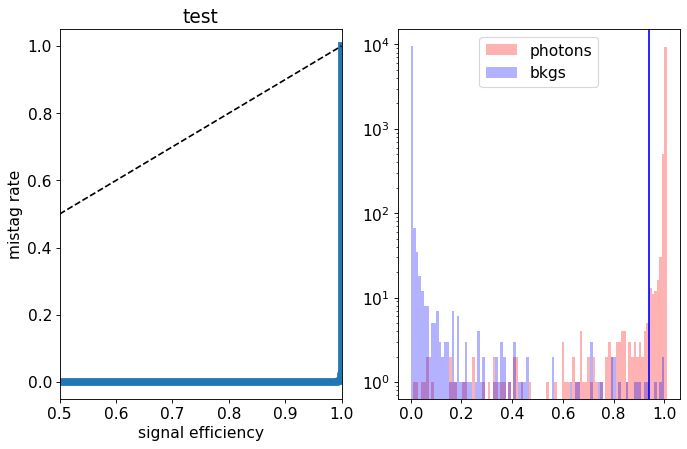

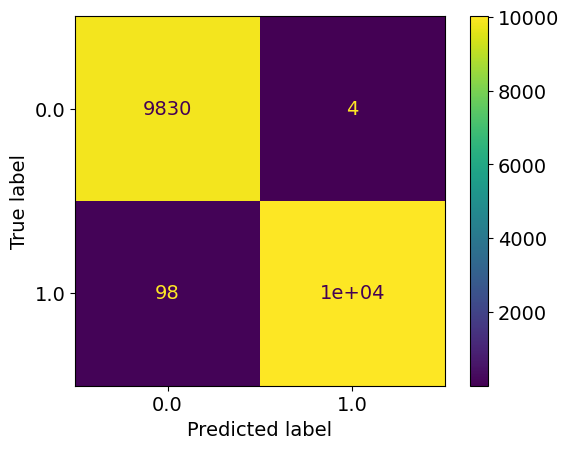

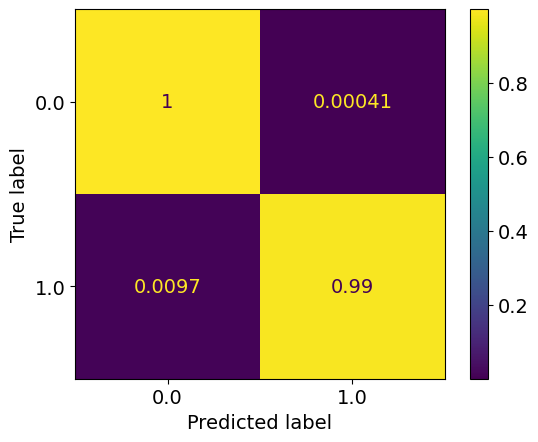

epoch: 80
Learning rate: 0.00034571449233923536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.006950899618540963
train acc: 0.99744385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.88it/s]


test loss: 0.008015065032797045
test acc: 0.9973438
new best acc: 0.9973438
epoch: 81
Learning rate: 0.00031615572738960855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.006666954493396846
train acc: 0.99743134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.009227519522777157
test acc: 0.9962913
epoch: 82
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.006320474989784835
train acc: 0.9975065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.0071417356803602375
test acc: 0.99714327
epoch: 83
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.0058637590566411124
train acc: 0.997707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.04it/s]


test loss: 0.007885711808579372
test acc: 0.9970431
epoch: 84
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.005964655370806878
train acc: 0.997707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.008511557971360162
test acc: 0.99679244
epoch: 85
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.006036844149704522
train acc: 0.9976819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.00712131003563306
test acc: 0.99739385
new best acc: 0.99739385
epoch: 86
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.005945927067963812
train acc: 0.99774456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.007109652851153549
test acc: 0.997444
new best acc: 0.997444
epoch: 87
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.005592930366402918
train acc: 0.99774456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.007345609692171873
test acc: 0.99739385
epoch: 88
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.005801259651224115
train acc: 0.9976945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.00726887966191177
test acc: 0.9971934
epoch: 89
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.005766861305138677
train acc: 0.99780726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.007100583498386721
test acc: 0.99729365


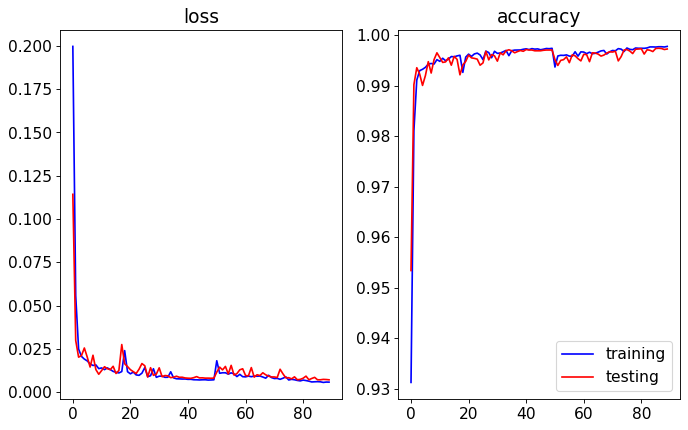

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


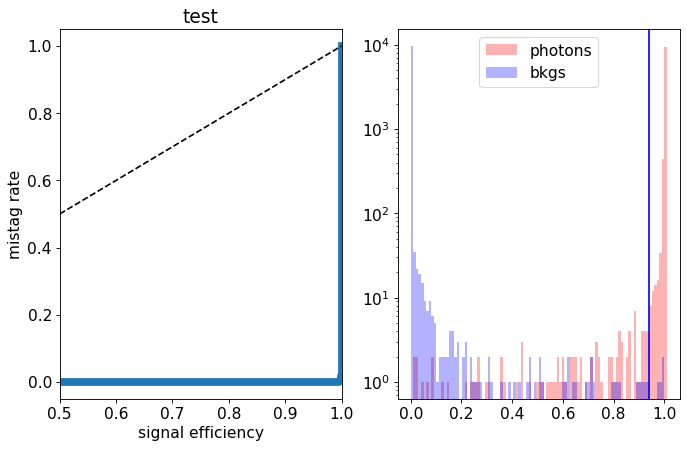

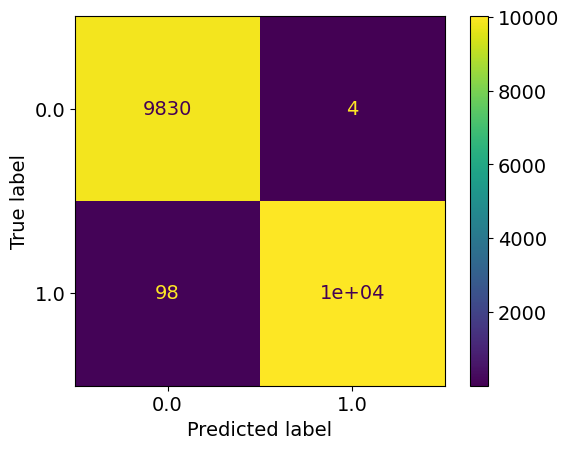

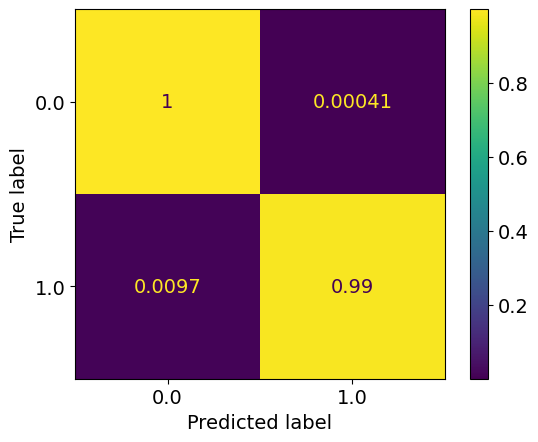

epoch: 90
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.005508204955880664
train acc: 0.9978699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.007547752834130626
test acc: 0.99739385
epoch: 91
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.24it/s]


train loss: 0.00553014977402243
train acc: 0.99789494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.006691935574053787
test acc: 0.997444
epoch: 92
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.005430467354058033
train acc: 0.99789494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.007227718544206308
test acc: 0.9974941
new best acc: 0.9974941
epoch: 93
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.005325524170740521
train acc: 0.99793255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.04it/s]


test loss: 0.00708544861545841
test acc: 0.9974941
epoch: 94
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.005165792278399858
train acc: 0.9981581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.007091525277835043
test acc: 0.99739385
epoch: 95
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.005162647372127316
train acc: 0.99793255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.007207835089716622
test acc: 0.9975442
new best acc: 0.9975442
epoch: 96
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.004953463767727403
train acc: 0.9980829


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.22it/s]


test loss: 0.006818986841073424
test acc: 0.9973438
epoch: 97
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.0052682434802930524
train acc: 0.99790746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.56it/s]


test loss: 0.007291195958661025
test acc: 0.9976946
new best acc: 0.9976946
epoch: 98
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.0052562144014496985
train acc: 0.9979451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.51it/s]


test loss: 0.006853049768217127
test acc: 0.9977447
new best acc: 0.9977447
epoch: 99
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.52it/s]


train loss: 0.005083462275482572
train acc: 0.99807036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.006888380000258193
test acc: 0.9977447


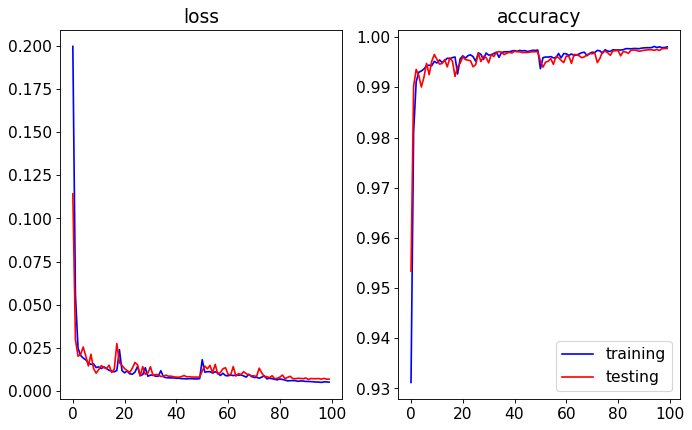

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


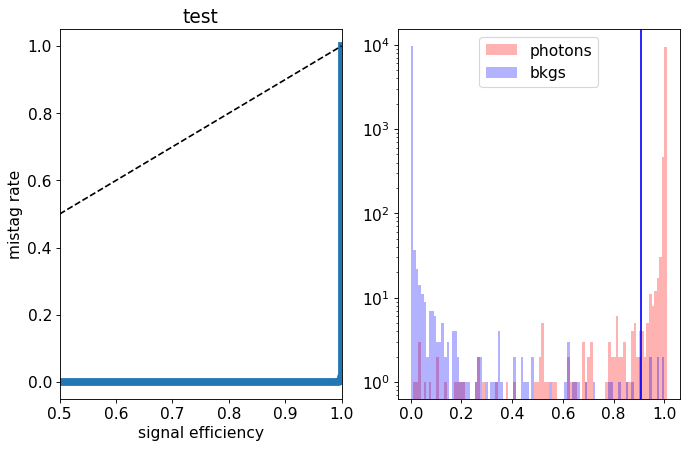

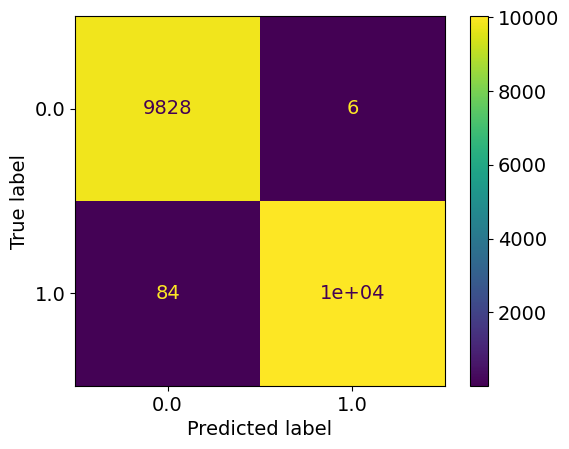

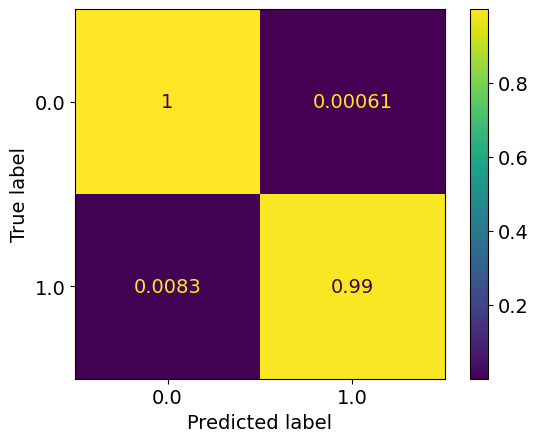

epoch: 100
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.011220592940641035
train acc: 0.99584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.22it/s]


test loss: 0.02083644626990837
test acc: 0.9934847
epoch: 101
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.012430058096565041
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.00849776022369042
test acc: 0.9970431
epoch: 102
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.008530580277950851
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.01911708988550612
test acc: 0.99463737
epoch: 103
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.013202635596554949
train acc: 0.9953388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.010418111023575287
test acc: 0.99594045
epoch: 104
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.26it/s]


train loss: 0.008164032360012365
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.99it/s]


test loss: 0.009602960438796264
test acc: 0.99624115
epoch: 105
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.007971655261840101
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.012899893500349102
test acc: 0.9947376
epoch: 106
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.008124216277324263
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.82it/s]


test loss: 0.007906755837372175
test acc: 0.9969428
epoch: 107
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.007963353864424653
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.22it/s]


test loss: 0.011414044769480824
test acc: 0.9958903
epoch: 108
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.007989247548276757
train acc: 0.9972183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.07it/s]


test loss: 0.009527673301122645
test acc: 0.996592
epoch: 109
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.008225836069067922
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.008394295938641709
test acc: 0.9969428


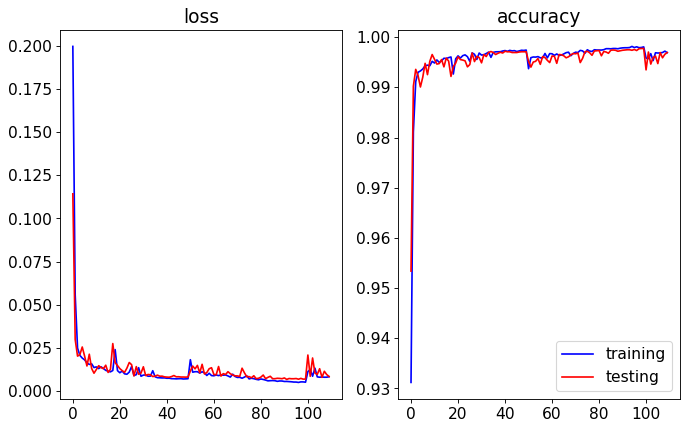

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


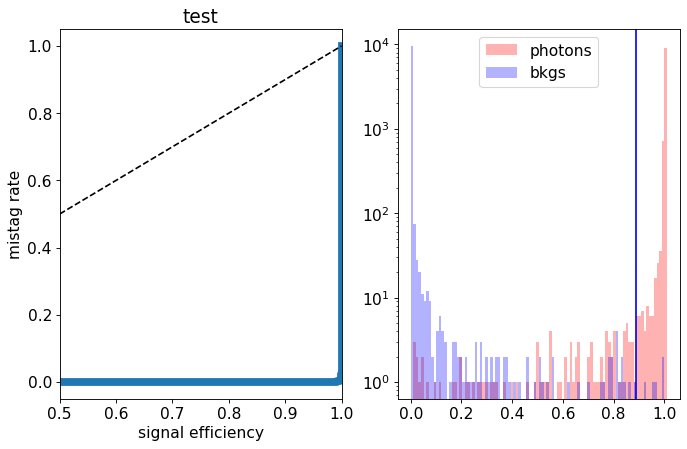

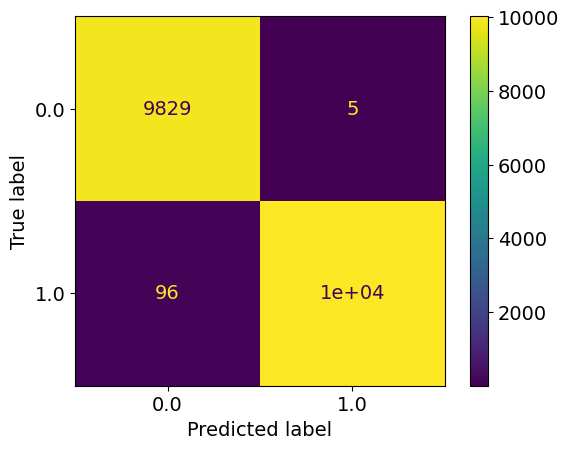

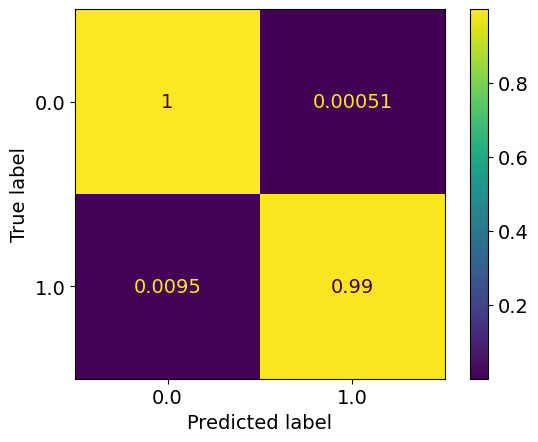

epoch: 110
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.007265422840239115
train acc: 0.9974063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.0073747077018625155
test acc: 0.9969428
epoch: 111
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.0070715349909515855
train acc: 0.99731857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.007662113512838807
test acc: 0.99684256
epoch: 112
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.007397509828764153
train acc: 0.9972308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.87it/s]


test loss: 0.00961547570563305
test acc: 0.99654186
epoch: 113
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.007950825139721304
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.008235600927625509
test acc: 0.99699295
epoch: 114
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008108906085148354
train acc: 0.99701786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.013526702916030498
test acc: 0.9944369
epoch: 115
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.006925802604567238
train acc: 0.9973687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.007435097559423679
test acc: 0.9972435
epoch: 116
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.006353095978317728
train acc: 0.99764436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


test loss: 0.007468057440265137
test acc: 0.99679244
epoch: 117
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.00672954354051092
train acc: 0.9973687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.007820004212108496
test acc: 0.9968927
epoch: 118
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0069300714623289
train acc: 0.9974564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.008916868682717904
test acc: 0.99684256
epoch: 119
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.006244424104878234
train acc: 0.9975566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.00811770566061194
test acc: 0.9970431


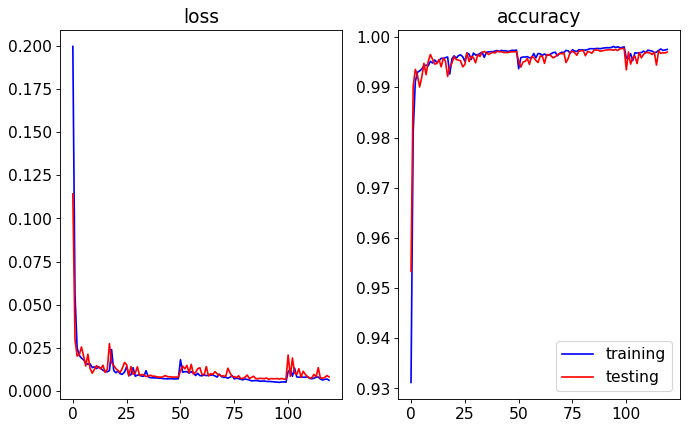

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


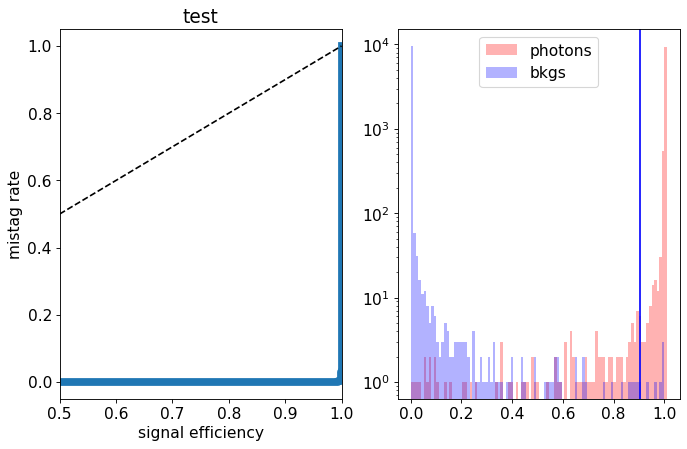

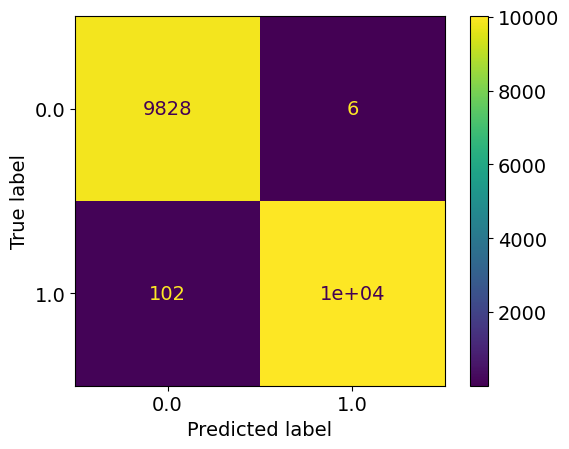

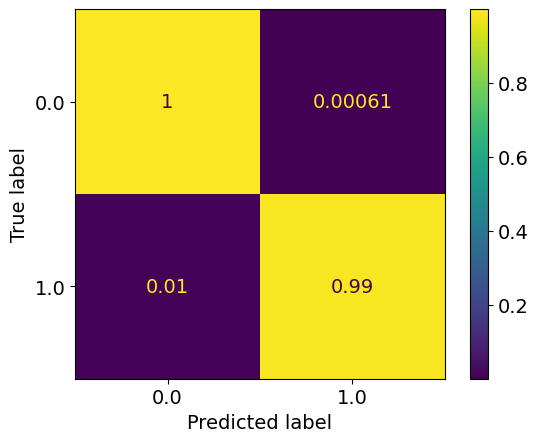

epoch: 120
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00691757226057017
train acc: 0.9977822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.012613645282245296
test acc: 0.9954393
epoch: 121
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.017331284999937763
train acc: 0.9943364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.00860783172538504
test acc: 0.99679244
epoch: 122
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.007550957530679286
train acc: 0.9971933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.45it/s]


test loss: 0.0077814219916677654
test acc: 0.99679244
epoch: 123
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.006811431865370576
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.007205902146832908
test acc: 0.99739385
epoch: 124
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.006349718601724302
train acc: 0.99746895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.007663997859173619
test acc: 0.99709314
epoch: 125
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.006435605250351103
train acc: 0.997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.08it/s]


test loss: 0.007870676947812386
test acc: 0.99699295
epoch: 126
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.006420210435496315
train acc: 0.9975316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.006559111457403667
test acc: 0.9976445
epoch: 127
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.005785761070272663
train acc: 0.99775714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007053469294024741
test acc: 0.9973438
epoch: 128
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.005835094067898258
train acc: 0.99775714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.007983426217619768
test acc: 0.99674237
epoch: 129
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.006069458352938644
train acc: 0.9975817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.006907660154598381
test acc: 0.99739385


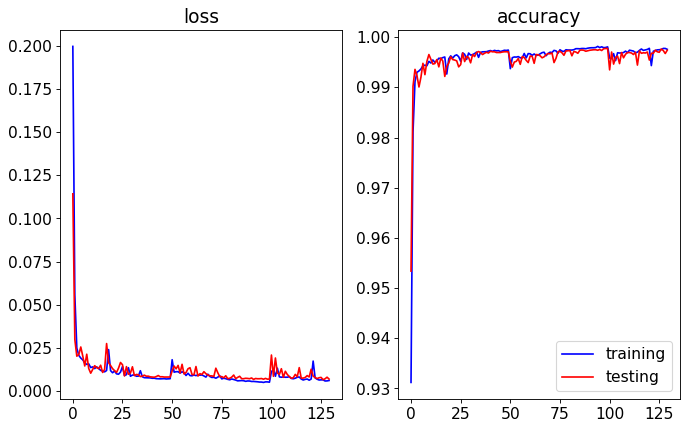

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


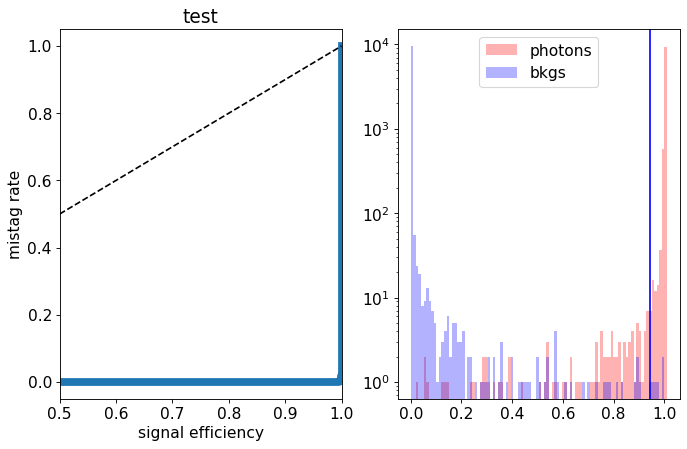

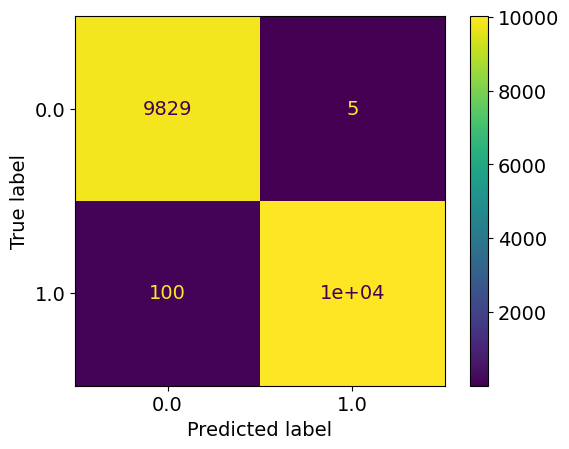

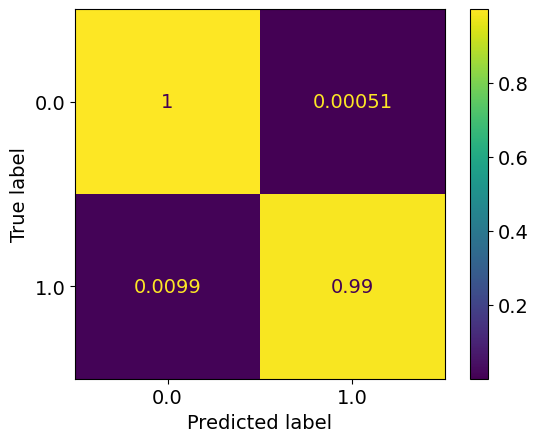

epoch: 130
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.005570208612975401
train acc: 0.99793255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.010836938882301398
test acc: 0.9955896
epoch: 131
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.005885879263940351
train acc: 0.9976819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.49it/s]


test loss: 0.008998314360403182
test acc: 0.99674237
epoch: 132
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.006564591658086929
train acc: 0.99744385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.006799327545141911
test acc: 0.9976445
epoch: 133
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.005252731398829397
train acc: 0.9981455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.006464279690536547
test acc: 0.9976946
epoch: 134
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.005315548939710316
train acc: 0.99785733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.006977144202477682
test acc: 0.9976445
epoch: 135
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.005107864137189879
train acc: 0.99807036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.006881333281532587
test acc: 0.9975442
epoch: 136
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.00597145505786618
train acc: 0.9977822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.75it/s]


test loss: 0.006602251018835779
test acc: 0.99739385
epoch: 137
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.005070931792047236
train acc: 0.99809545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.006542691361734315
test acc: 0.9977948
new best acc: 0.9977948
epoch: 138
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.005011086630230551
train acc: 0.998133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.02it/s]


test loss: 0.006448510267278727
test acc: 0.9976946
epoch: 139
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.004980388973186212
train acc: 0.9980829


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.006644024000064854
test acc: 0.9977948


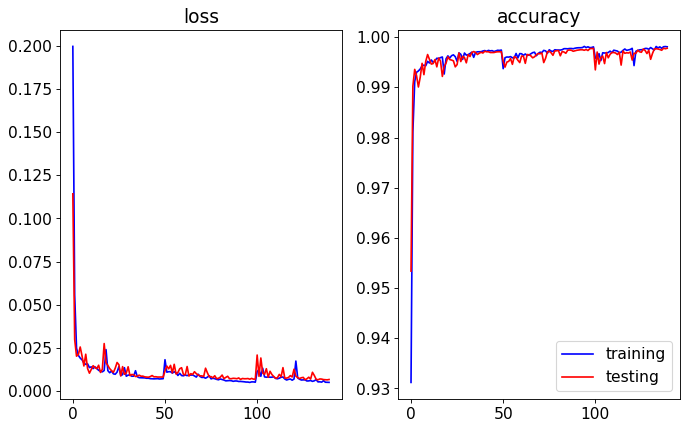

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


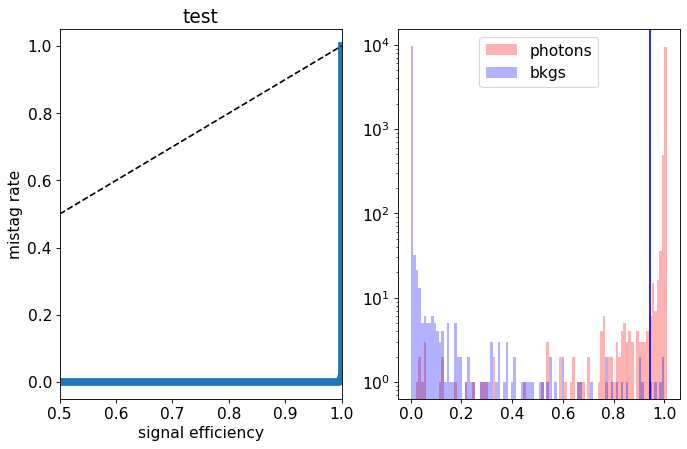

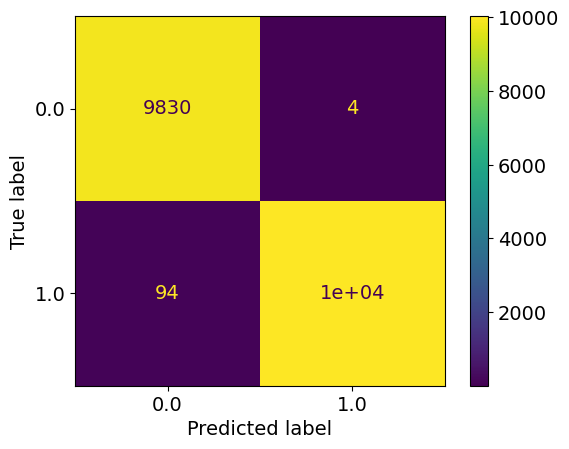

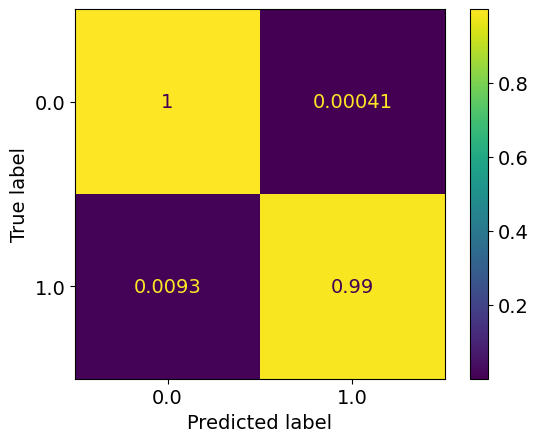

epoch: 140
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.004951347207488754
train acc: 0.99819565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.006973158328465241
test acc: 0.99784493
new best acc: 0.99784493
epoch: 141
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.004796196252225614
train acc: 0.99822074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.006221243389197351
test acc: 0.9976946
epoch: 142
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.004854593578241279
train acc: 0.9983335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.09it/s]


test loss: 0.006832585971364204
test acc: 0.9976445
epoch: 143
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.0046548697203047254
train acc: 0.9981706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.006317825809888104
test acc: 0.99759436
epoch: 144
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.004623736062655295
train acc: 0.99818313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.006194823216099073
test acc: 0.9976946
epoch: 145
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.004771744609013643
train acc: 0.99819565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.006208497502324034
test acc: 0.99789506
new best acc: 0.99789506
epoch: 146
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.004699514183866724
train acc: 0.99818313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.006255297849694376
test acc: 0.9976445
epoch: 147
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.004540883793288061
train acc: 0.9982834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.006344806717927842
test acc: 0.9976946
epoch: 148
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.004547861492544293
train acc: 0.9982082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.006199265490388772
test acc: 0.9977447
epoch: 149
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.004739484065577193
train acc: 0.99819565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.006223172524615246
test acc: 0.9976946


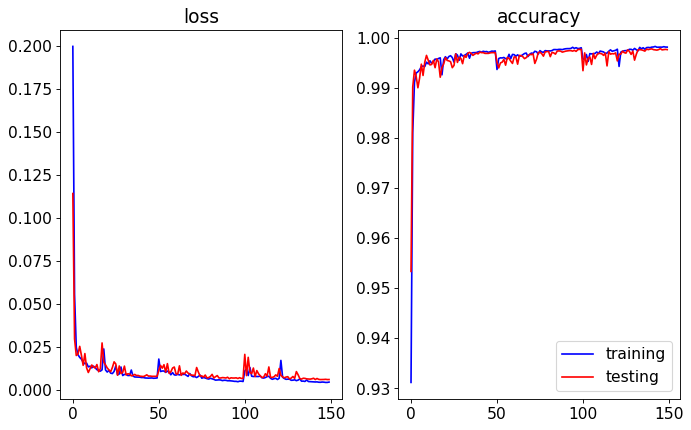

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


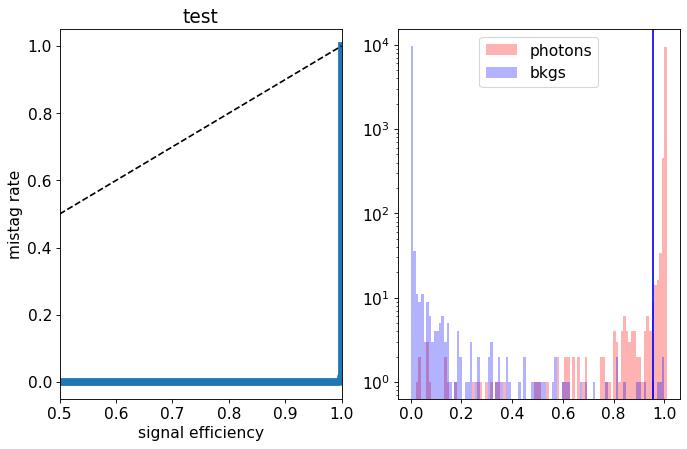

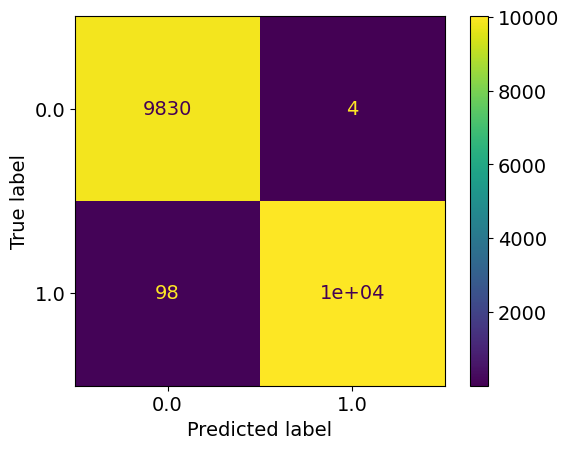

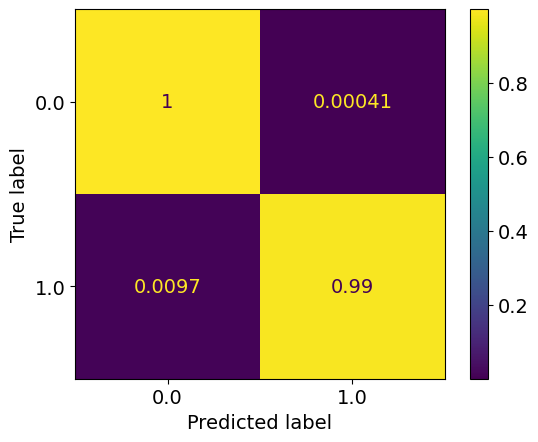

epoch: 150
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008724991553982132
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.00790456693057957
test acc: 0.99714327
epoch: 151
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.00854096426940541
train acc: 0.9967923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.012309541076640873
test acc: 0.9951386
epoch: 152
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.007314798790408097
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.009419849489966188
test acc: 0.99649173
epoch: 153
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009113868372525704
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.00912856003132594
test acc: 0.99649173
epoch: 154
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0075103066915493295
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.013723284584771404
test acc: 0.9955896
epoch: 155
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008182857108064372
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.09it/s]


test loss: 0.008050721919383197
test acc: 0.99699295
epoch: 156
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.007508207080406206
train acc: 0.99726844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.72it/s]


test loss: 0.011807501750916024
test acc: 0.99584025
epoch: 157
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.007873992901295424
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.008341193000566871
test acc: 0.99684256
epoch: 158
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.006729886687270352
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.009465903516256195
test acc: 0.99649173
epoch: 159
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.006180053875684287
train acc: 0.9974188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.31it/s]


test loss: 0.010940989212352125
test acc: 0.99614096


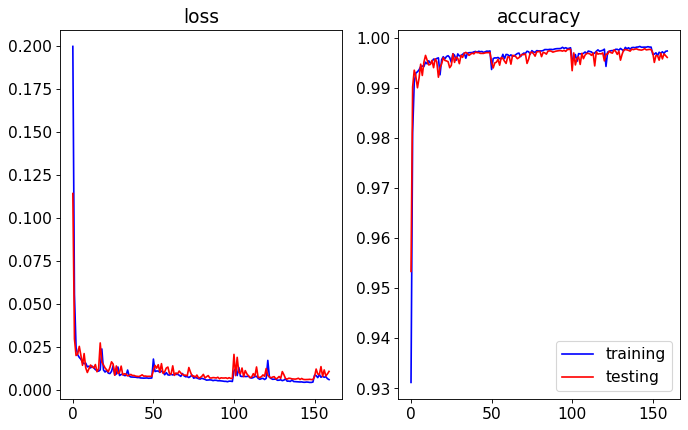

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


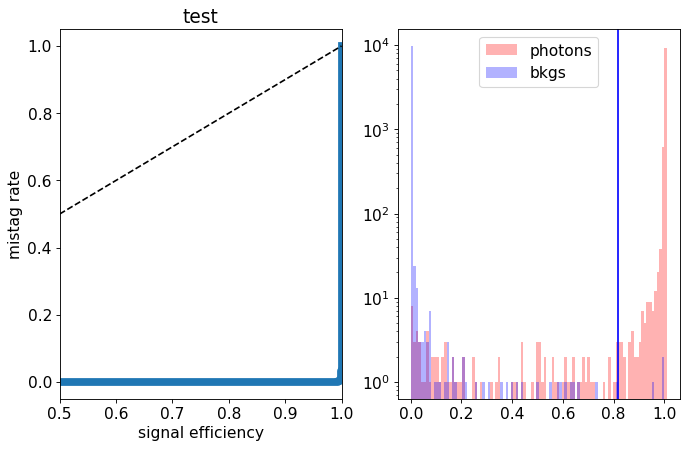

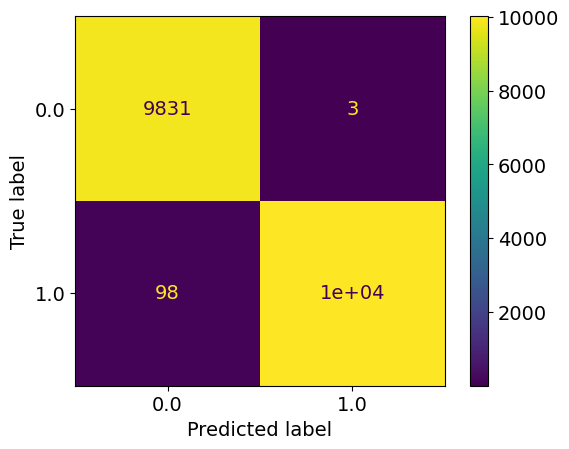

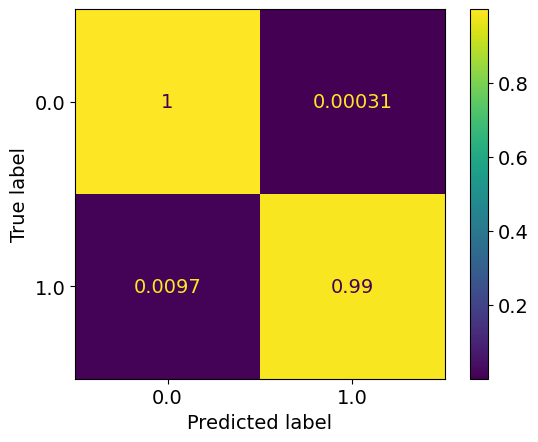

epoch: 160
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009104005093234521
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.07440546297413461
test acc: 0.9709317
epoch: 161
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.026799575853119813
train acc: 0.9915422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.015053974307032631
test acc: 0.99503833
epoch: 162
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.010231446756272395
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.011466771713458002
test acc: 0.9955896
epoch: 163
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009963741703671333
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.01121356021544403
test acc: 0.99584025
epoch: 164
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.008679147108672786
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.009635370508904624
test acc: 0.9963414
epoch: 165
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00831640879501964
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.008379739664686733
test acc: 0.99714327
epoch: 166
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.007236827459510367
train acc: 0.9972183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.010550979699473828
test acc: 0.99594045
epoch: 167
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.007292149893621525
train acc: 0.99731857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.007772760988754111
test acc: 0.99709314
epoch: 168
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0070585421100932124
train acc: 0.99731857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.12it/s]


test loss: 0.008804491914548528
test acc: 0.99639153
epoch: 169
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00637075608240444
train acc: 0.99780726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.00872589138281696
test acc: 0.99684256


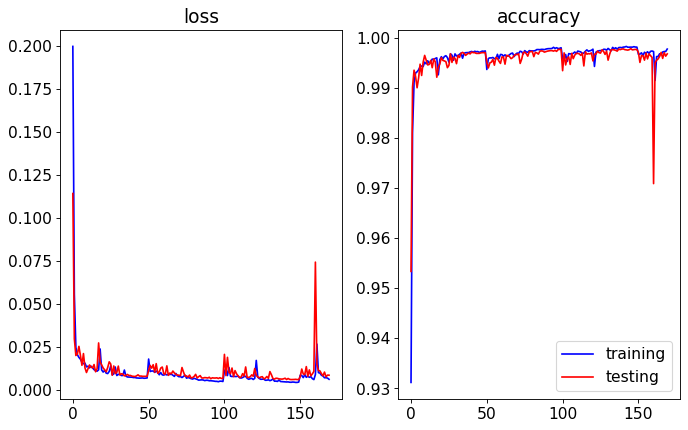

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


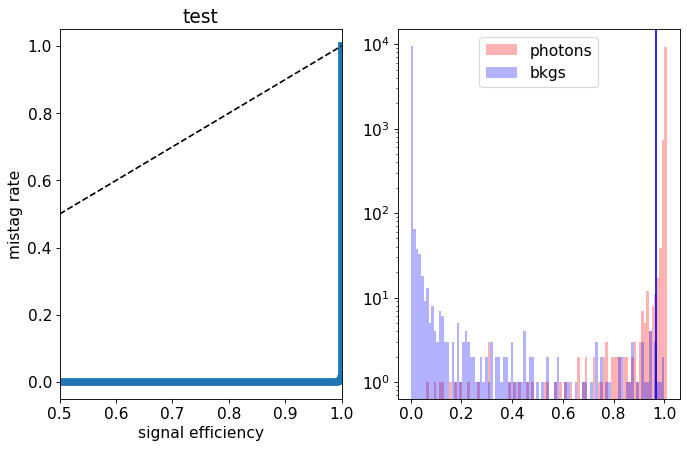

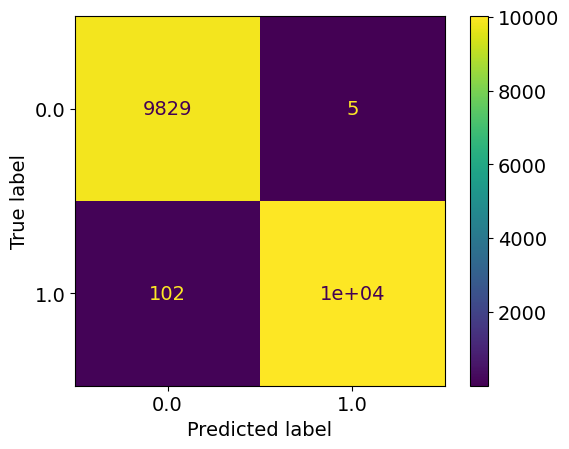

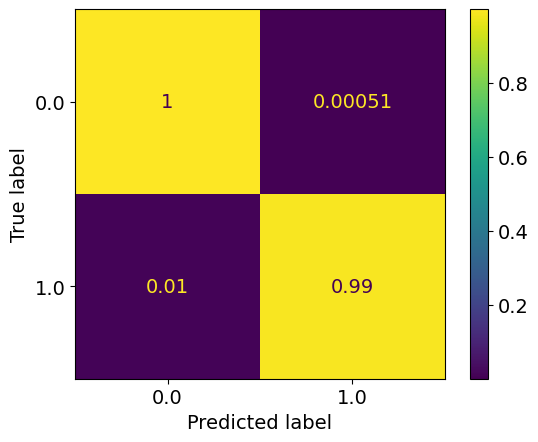

epoch: 170
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.006673844133172733
train acc: 0.9974564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.009444979801842505
test acc: 0.99669224
epoch: 171
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.006609980200990511
train acc: 0.997519


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]


test loss: 0.008206722686094615
test acc: 0.99684256
epoch: 172
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.006763552523875321
train acc: 0.99743134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.90it/s]


test loss: 0.00968235791386927
test acc: 0.99699295
epoch: 173
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.006057363392213105
train acc: 0.9975817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.008957835215636912
test acc: 0.99684256
epoch: 174
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.005853121601342251
train acc: 0.99776965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.008095167592674604
test acc: 0.99674237
epoch: 175
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.006090198529886608
train acc: 0.997707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011281257510691992
test acc: 0.99639153
epoch: 176
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00631404830117512
train acc: 0.99746895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.008100792447187226
test acc: 0.99669224
epoch: 177
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008038208796034582
train acc: 0.9979451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.012871072086615159
test acc: 0.99523884
epoch: 178
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.014608172738035
train acc: 0.99481255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.008564504062044708
test acc: 0.99674237
epoch: 179
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.005875940956983285
train acc: 0.9977195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.009544180072707069
test acc: 0.99669224


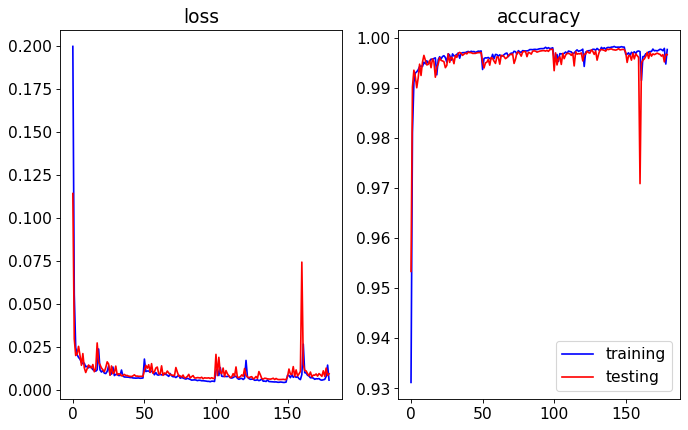

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


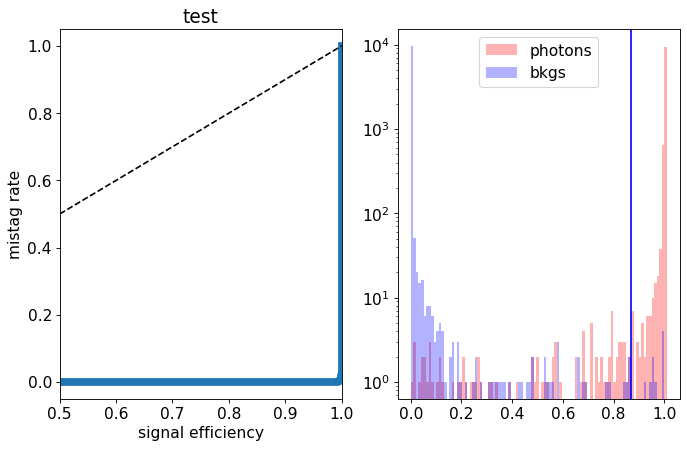

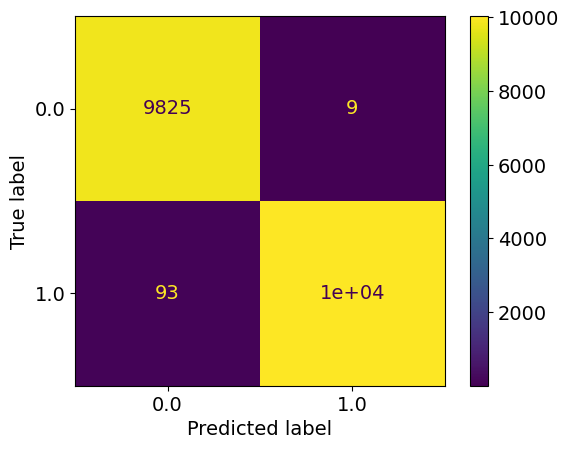

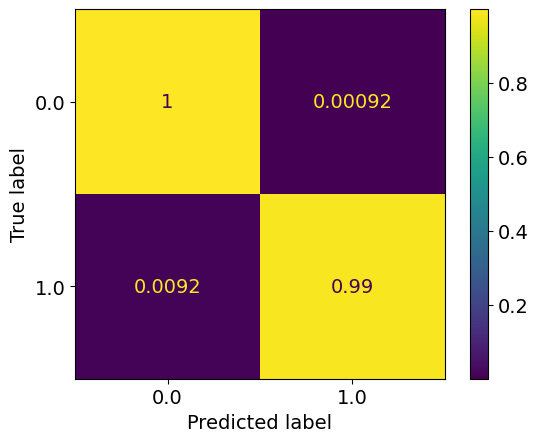

epoch: 180
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.005474636444846714
train acc: 0.9978699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.007556657638976022
test acc: 0.9972435
epoch: 181
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.005158188082573104
train acc: 0.9981455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.008344811274368754
test acc: 0.99709314
epoch: 182
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.005415771793575832
train acc: 0.99802023


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.007280227137551478
test acc: 0.99729365
epoch: 183
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.005172750928672617
train acc: 0.99805784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.007998415762010743
test acc: 0.9971934
epoch: 184
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0052267043579037695
train acc: 0.9980453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.009014663752168417
test acc: 0.99709314
epoch: 185
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.004932178858094874
train acc: 0.99822074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.25it/s]


test loss: 0.007963113852276686
test acc: 0.99714327
epoch: 186
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.0048261639791886786
train acc: 0.998133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008336177136858596
test acc: 0.9972435
epoch: 187
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.004652348301251821
train acc: 0.99822074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.007556238973526941
test acc: 0.997444
epoch: 188
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.004793490229897529
train acc: 0.99823326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007485946539364865
test acc: 0.99739385
epoch: 189
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.0049610359378336275
train acc: 0.99818313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.00746262957502896
test acc: 0.99699295


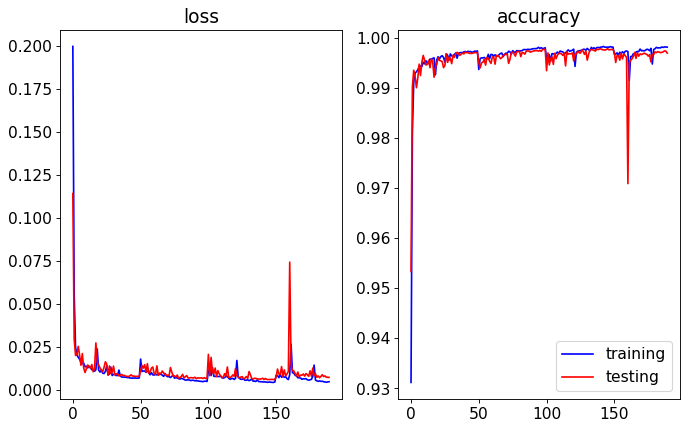

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


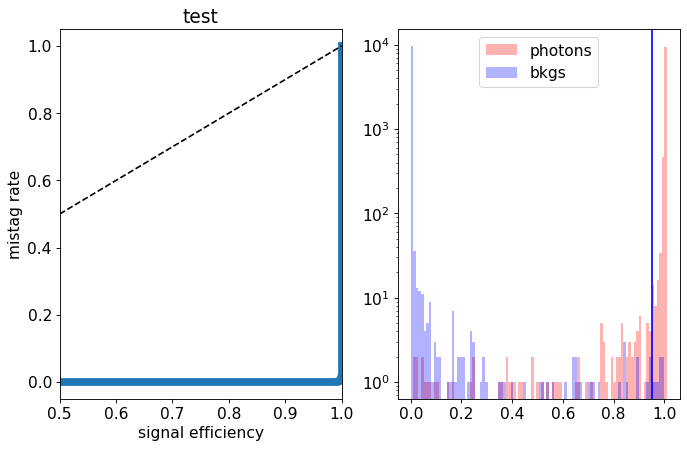

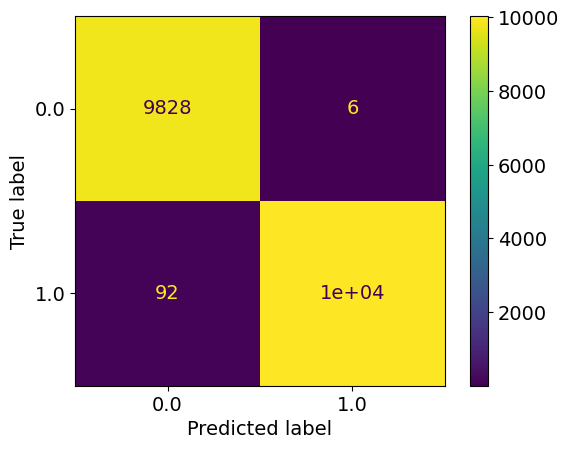

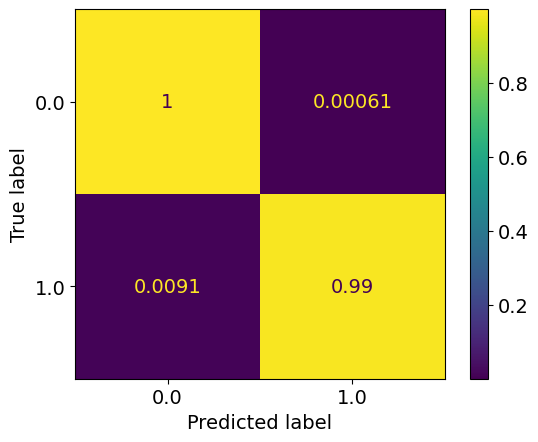

epoch: 190
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00495525449752792
train acc: 0.99805784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.007823851852342212
test acc: 0.9972435
epoch: 191
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.004950707190610997
train acc: 0.99823326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.0075421442983069405
test acc: 0.9969428
epoch: 192
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.004768616426258292
train acc: 0.9982082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.0077019760022213795
test acc: 0.9970431
epoch: 193
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.004447191204067438
train acc: 0.9984087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.007486304144763648
test acc: 0.99699295
epoch: 194
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.004252902236143838
train acc: 0.9984087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.0075265765130204864
test acc: 0.99714327
epoch: 195
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.004397769522880678
train acc: 0.99837106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.007493809961220797
test acc: 0.9970431
epoch: 196
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.004381646970345862
train acc: 0.9983084


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007504570634302902
test acc: 0.9970431
epoch: 197
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.004352178749082777
train acc: 0.99835855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.008597292670267908
test acc: 0.9970431
epoch: 198
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.004304132581659591
train acc: 0.99834603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.007578458920333479
test acc: 0.9970431
epoch: 199
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.004432661984813578
train acc: 0.9983084


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.007802928679773365
test acc: 0.9970431


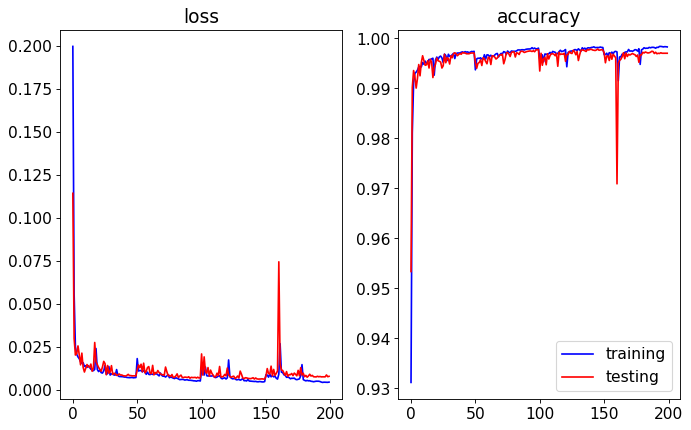

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


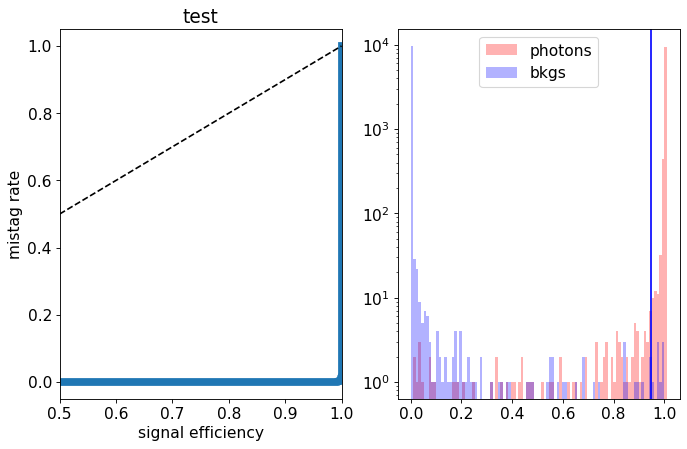

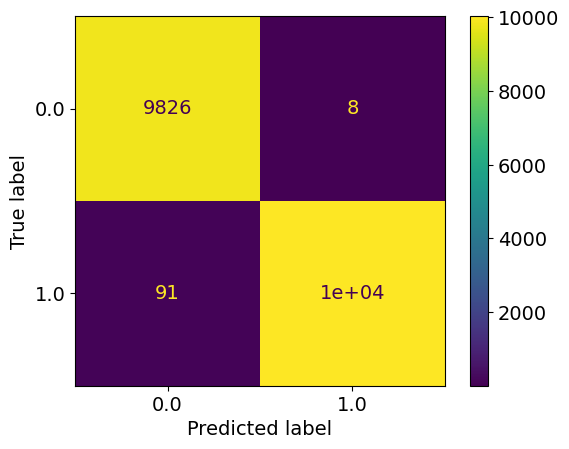

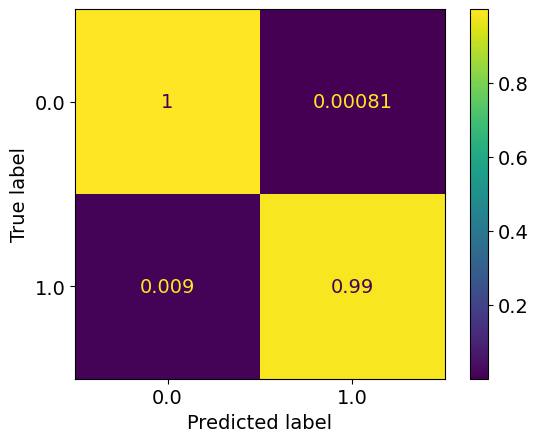

epoch: 200
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.009708417970475253
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.011045090532313813
test acc: 0.9960908
epoch: 201
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0077599658406645395
train acc: 0.99731857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.008445002837106586
test acc: 0.99669224
epoch: 202
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008790496868095264
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.12it/s]


test loss: 0.010697172893046895
test acc: 0.9962913
epoch: 203
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.006593791971287978
train acc: 0.99773204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.010044573347412926
test acc: 0.9963414
epoch: 204
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00823434358684228
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.011236421216060133
test acc: 0.9962913
epoch: 205
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.0069039910926520275
train acc: 0.99729353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.01101905841171495
test acc: 0.99669224
epoch: 206
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.006149959305662717
train acc: 0.9978448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.0071852677244939565
test acc: 0.9973438
epoch: 207
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.006166559461011031
train acc: 0.99775714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.008146173745284186
test acc: 0.99714327
epoch: 208
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.005776422816502384
train acc: 0.9977822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.008418345522573766
test acc: 0.99709314
epoch: 209
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.006590336349735304
train acc: 0.99743134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.008226369449403137
test acc: 0.9970431


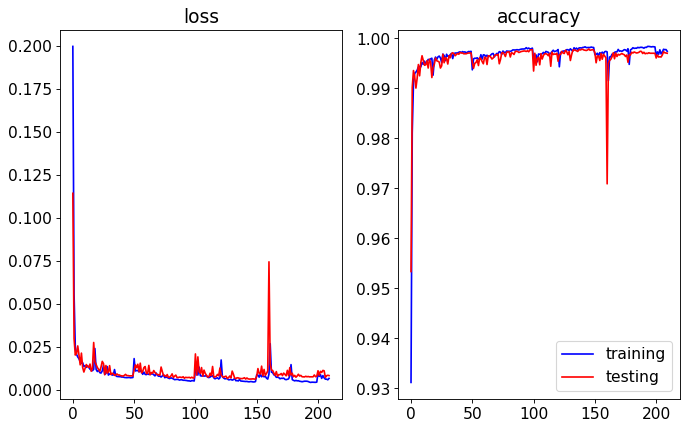

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


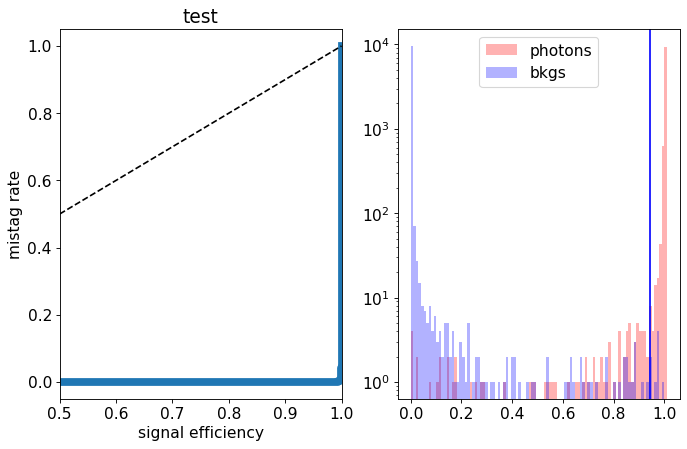

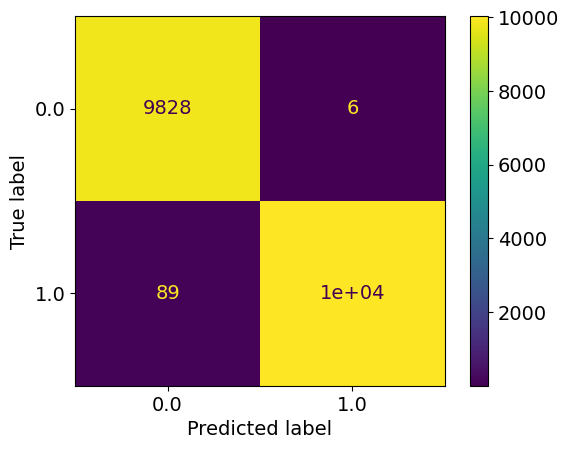

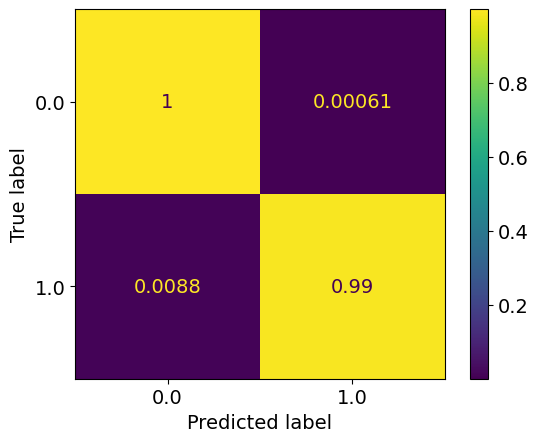

epoch: 210
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.006332075933112625
train acc: 0.9977947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.00760427101597409
test acc: 0.9972435
epoch: 211
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.005873773225121384
train acc: 0.9976694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.00907384289551855
test acc: 0.9970431
epoch: 212
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.005515767730820929
train acc: 0.9978699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007360052043462501
test acc: 0.99699295
epoch: 213
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.005629614814368786
train acc: 0.99792004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.00884548032498809
test acc: 0.9969428
epoch: 214
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.005793701534362774
train acc: 0.99774456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008808396340635441
test acc: 0.9973438
epoch: 215
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.0058891357106431175
train acc: 0.9976569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.69it/s]


test loss: 0.007856273681254071
test acc: 0.9970431
epoch: 216
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.005388068473974326
train acc: 0.99802023


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.64it/s]


test loss: 0.00934347920701839
test acc: 0.99674237
epoch: 217
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.005306312221106435
train acc: 0.99802023


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.80it/s]


test loss: 0.007961875296827844
test acc: 0.99709314
epoch: 218
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.004881827928173478
train acc: 0.99827087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.68it/s]


test loss: 0.00815242892542087
test acc: 0.9973438
epoch: 219
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.005088872490914447
train acc: 0.99809545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.008044362862539641
test acc: 0.99699295


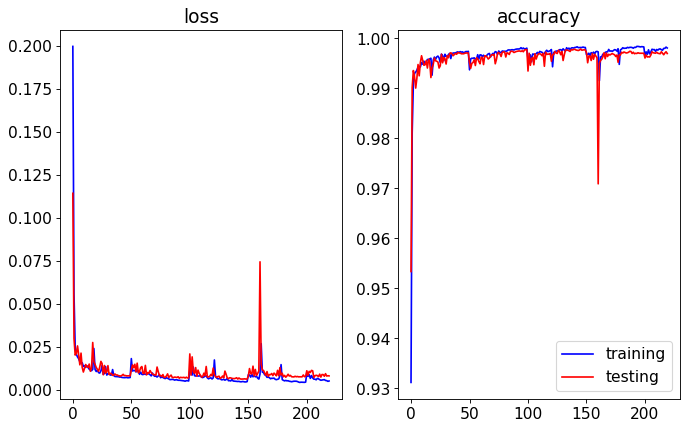

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.23it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


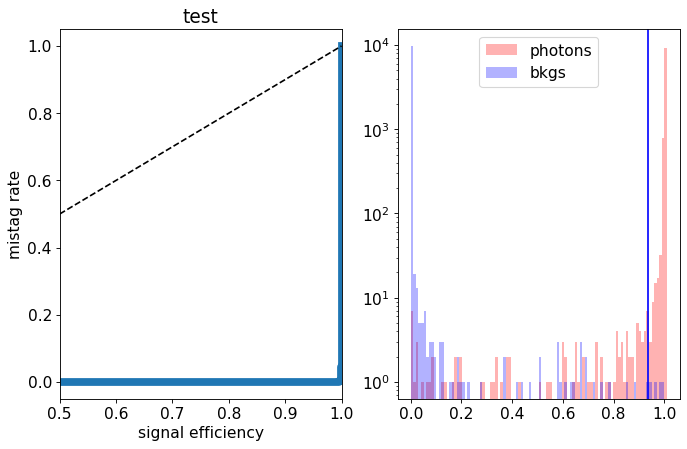

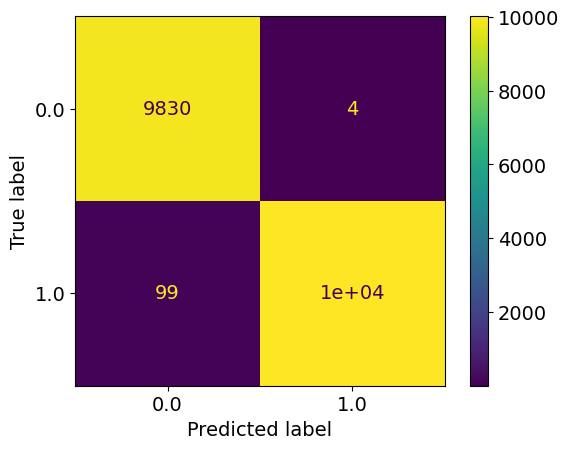

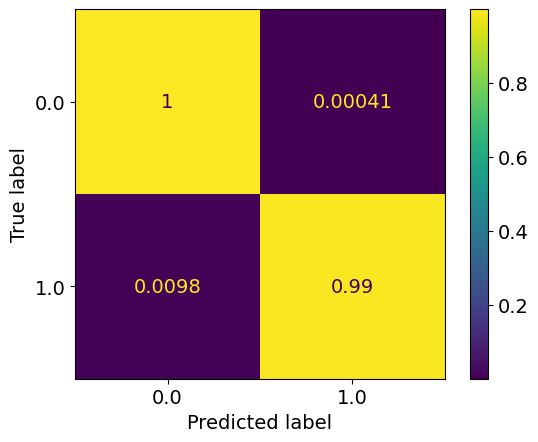

epoch: 220
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.005065748148605161
train acc: 0.99809545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.63it/s]


test loss: 0.007940961089094771
test acc: 0.99739385
epoch: 221
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.004887186873807154
train acc: 0.9981455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.67it/s]


test loss: 0.009985295374302523
test acc: 0.9966421
epoch: 222
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.005459348125767254
train acc: 0.99827087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.011237951721448232
test acc: 0.9960407
epoch: 223
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.007498502140124537
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.62it/s]


test loss: 0.008809068996924907
test acc: 0.99699295
epoch: 224
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.004657016388330418
train acc: 0.9981455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]


test loss: 0.00938487697738524
test acc: 0.9970431
epoch: 225
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.004583544308730718
train acc: 0.9982082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007996076793300317
test acc: 0.9971934
epoch: 226
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.00418878031306035
train acc: 0.99834603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008469868513844524
test acc: 0.9973438
epoch: 227
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004349460490996521
train acc: 0.99834603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.008997941977748483
test acc: 0.99699295
epoch: 228
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.004321974194219854
train acc: 0.99838364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.007831769510042197
test acc: 0.997444
epoch: 229
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0041348250037005615
train acc: 0.9984463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.55it/s]


test loss: 0.008307347894194262
test acc: 0.9974941


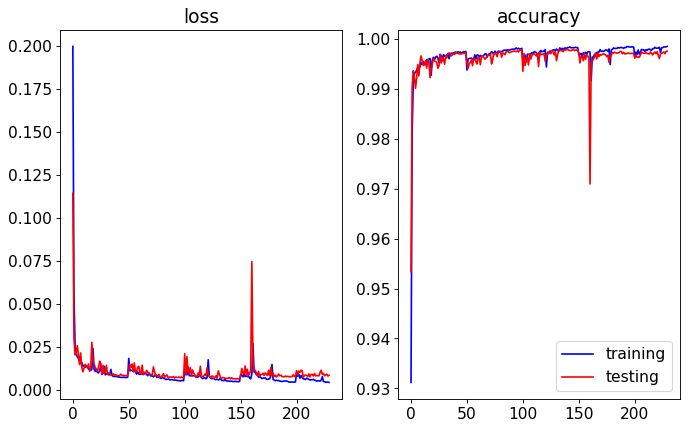

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


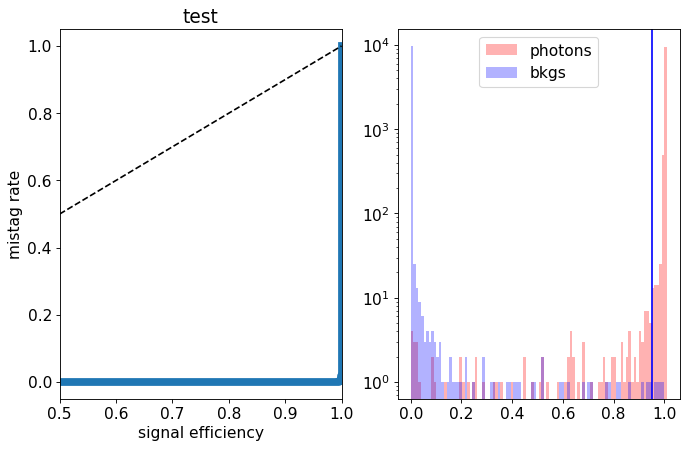

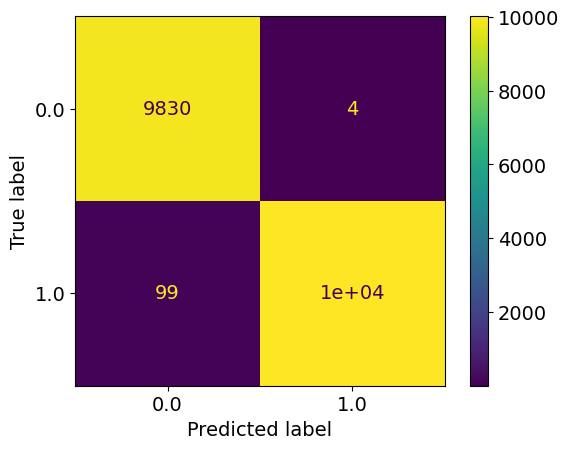

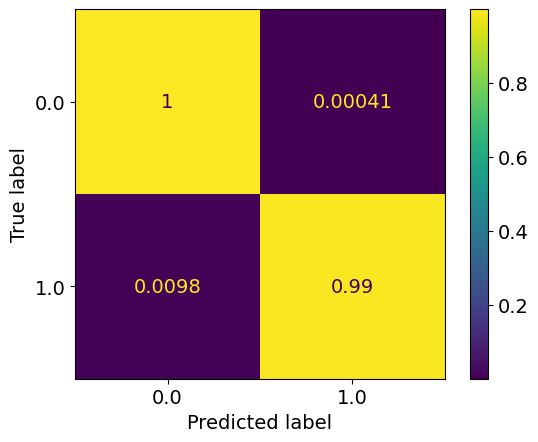

epoch: 230
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.003892097257923877
train acc: 0.99839616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.008126185310710058
test acc: 0.99729365
epoch: 231
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003980705875836798
train acc: 0.99850893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.007645826628825436
test acc: 0.9972435
epoch: 232
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003656745958113476
train acc: 0.9986217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.17it/s]


test loss: 0.007056406990587301
test acc: 0.9973438
epoch: 233
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0038144529365452587
train acc: 0.99853396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.008548189929570071
test acc: 0.99699295
epoch: 234
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0035866395930443376
train acc: 0.99850893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008114165923496544
test acc: 0.9973438
epoch: 235
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0035693160186095856
train acc: 0.9987846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.007808347655501326
test acc: 0.9971934
epoch: 236
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0032941471683659127
train acc: 0.9986217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.007520358653410393
test acc: 0.9974941
epoch: 237
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.0032596327978828767
train acc: 0.9989224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.007587802295080002
test acc: 0.997444
epoch: 238
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003321286028216359
train acc: 0.9987345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.0073206816964289725
test acc: 0.9974941
epoch: 239
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.27it/s]


train loss: 0.0031844767577444036
train acc: 0.9988347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.007760430904026554
test acc: 0.99739385


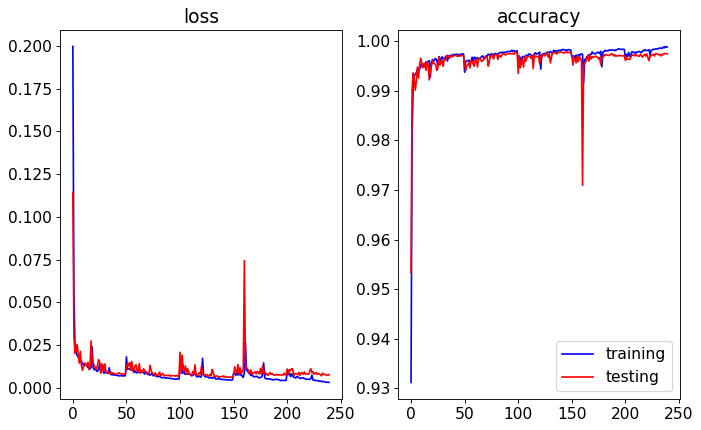

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


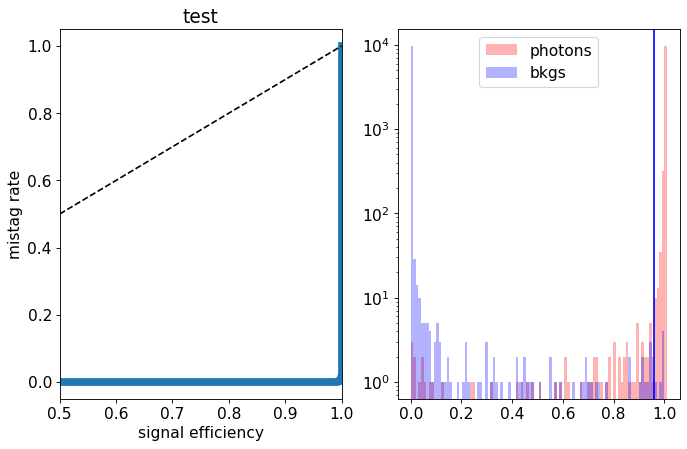

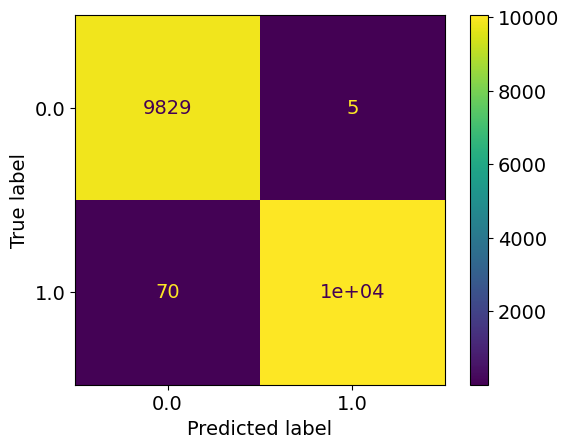

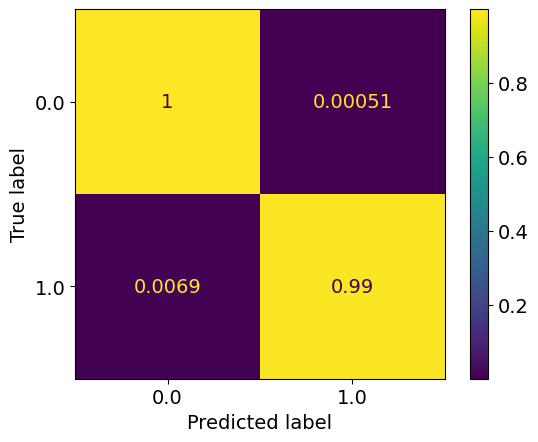

epoch: 240
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003226258522881292
train acc: 0.9987595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.0077549587667282835
test acc: 0.99739385
epoch: 241
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.00310687415239682
train acc: 0.99884725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.00760905110013589
test acc: 0.9973438
epoch: 242
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.003185313905409026
train acc: 0.99882215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.007598188317120623
test acc: 0.9971934
epoch: 243
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0031313982302646165
train acc: 0.99882215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.007878199949011426
test acc: 0.99729365
epoch: 244
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.003020086762751033
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.08it/s]


test loss: 0.008015934011970838
test acc: 0.9972435
epoch: 245
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.0030636968629503608
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.007947725577276502
test acc: 0.99729365
epoch: 246
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.0029189357033118737
train acc: 0.9988848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.44it/s]


test loss: 0.008335227524666526
test acc: 0.99739385
epoch: 247
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.0029836130627487237
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.007687545116127962
test acc: 0.99739385
epoch: 248
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.0029561734893173816
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.67it/s]


test loss: 0.0076931921426234215
test acc: 0.9973438
epoch: 249
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.002825395279384128
train acc: 0.9989224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.68it/s]


test loss: 0.008120896328310825
test acc: 0.9973438


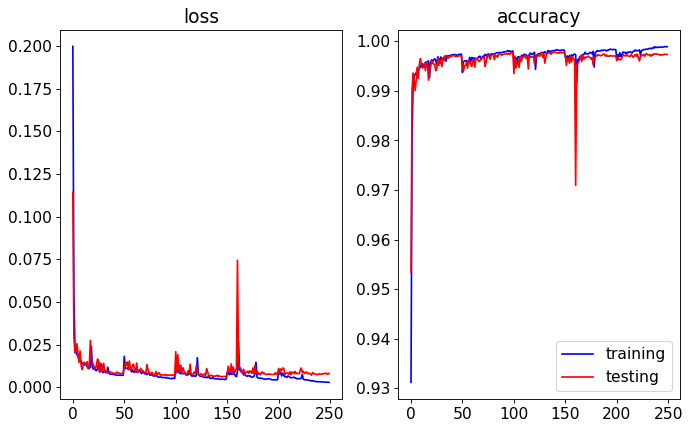

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


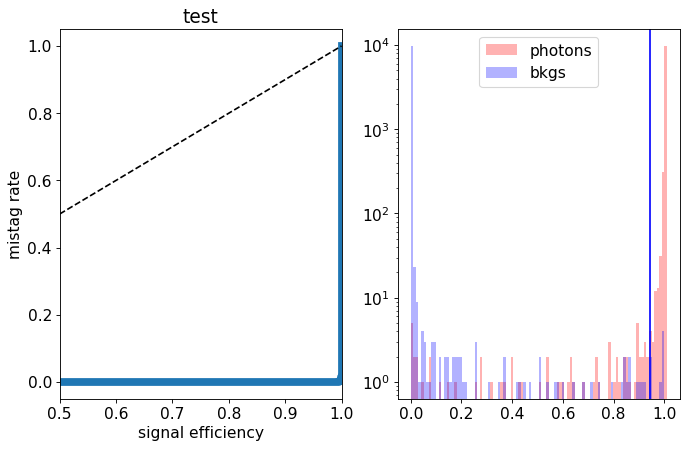

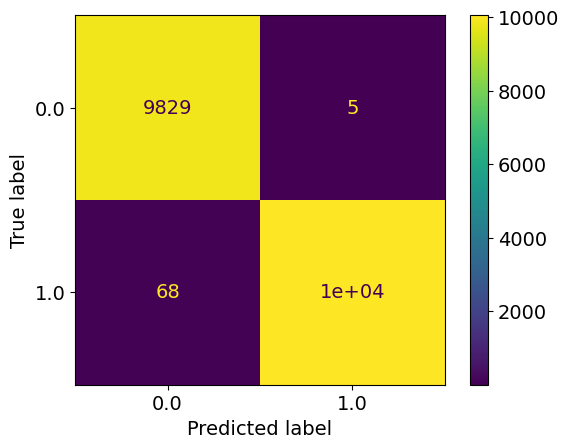

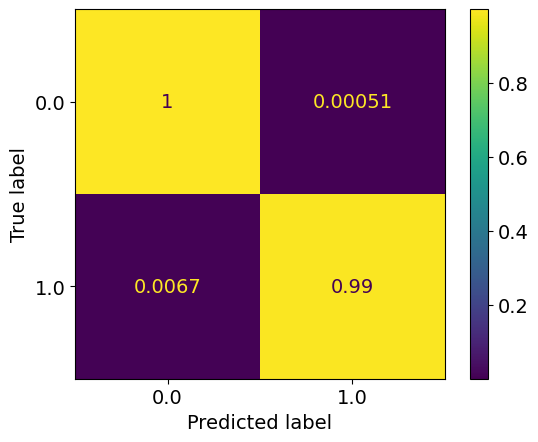

epoch: 250
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.00792395241133044
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.61it/s]


test loss: 0.008055019576097359
test acc: 0.99709314
epoch: 251
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.008323135236423695
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.008727206290453015
test acc: 0.9969428
epoch: 252
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.005635795877254561
train acc: 0.9977822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.007322209868053666
test acc: 0.99729365
epoch: 253
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.005305171831369351
train acc: 0.99805784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.007210296837215805
test acc: 0.99759436
epoch: 254
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.005308169802772871
train acc: 0.99785733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.012393176474742015
test acc: 0.99624115
epoch: 255
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.006664527446106088
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008674791236818932
test acc: 0.99679244
epoch: 256
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.005190003654505055
train acc: 0.99790746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.01001405270953375
test acc: 0.9966421
epoch: 257
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.005340920933678663
train acc: 0.9979451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.00978186443406979
test acc: 0.99669224
epoch: 258
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.005477063674062713
train acc: 0.99793255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.012044359025928904
test acc: 0.99639153
epoch: 259
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004950251952628442
train acc: 0.9981581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.009507405932869433
test acc: 0.99679244


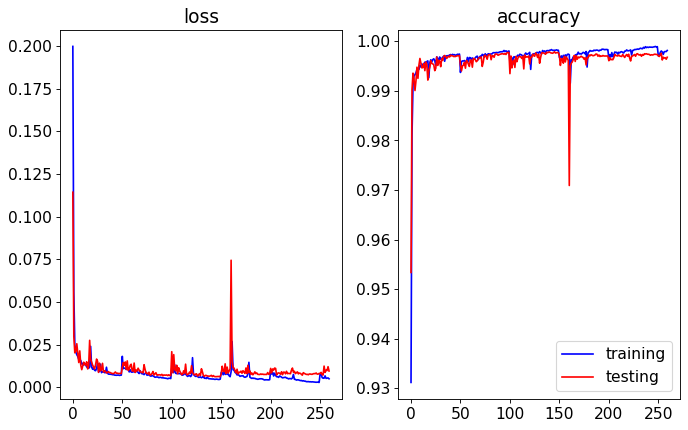

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


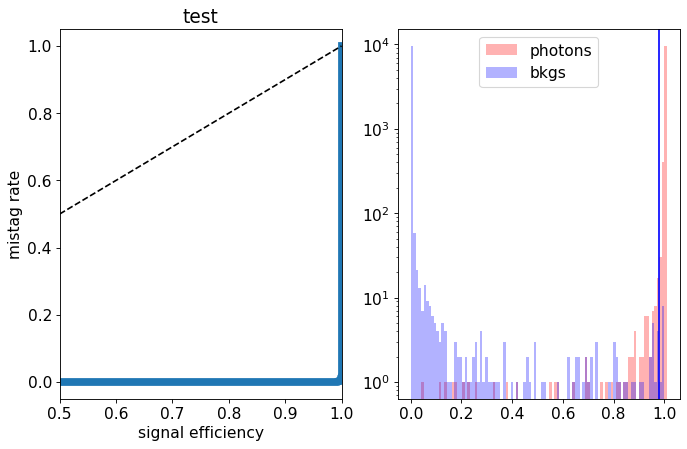

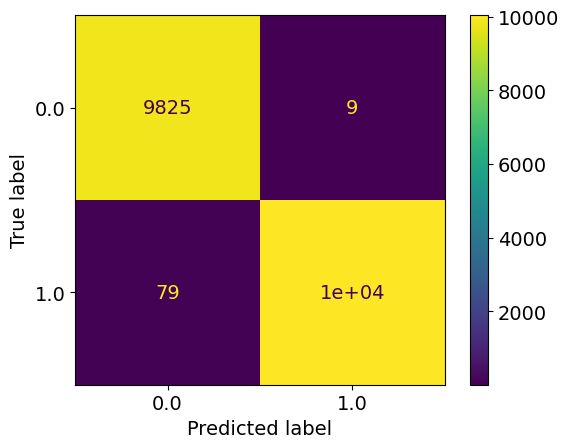

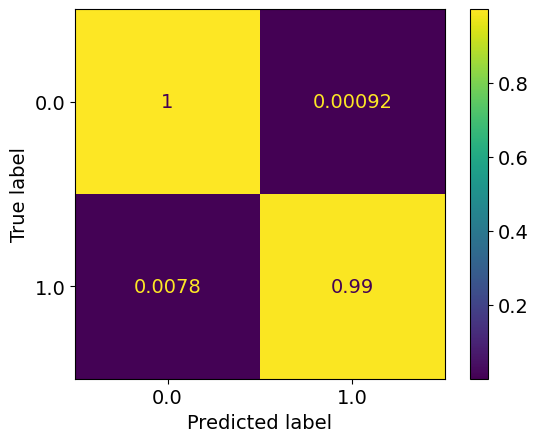

epoch: 260
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.005222484946654134
train acc: 0.99774456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.013560382560279001
test acc: 0.99639153
epoch: 261
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004690641090543176
train acc: 0.9982082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.010446499814861454
test acc: 0.99684256
epoch: 262
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.005323453167733729
train acc: 0.9979576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.79it/s]


test loss: 0.008692923655925208
test acc: 0.99714327
epoch: 263
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004428224865932862
train acc: 0.9984588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008896764724340755
test acc: 0.9969428
epoch: 264
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.005016824509155739
train acc: 0.9979952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.007052289234707132
test acc: 0.9976946
epoch: 265
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.0040435542980062494
train acc: 0.99839616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.00875364052669337
test acc: 0.9971934
epoch: 266
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.004657211368054566
train acc: 0.9982834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008134526019121575
test acc: 0.997444
epoch: 267
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0041005461332961615
train acc: 0.9984212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.008593493740430431
test acc: 0.9970431
epoch: 268
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.003995432124801441
train acc: 0.9984212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.00877322762286948
test acc: 0.99709314
epoch: 269
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.004097386093127652
train acc: 0.99827087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008543552392545868
test acc: 0.9972435


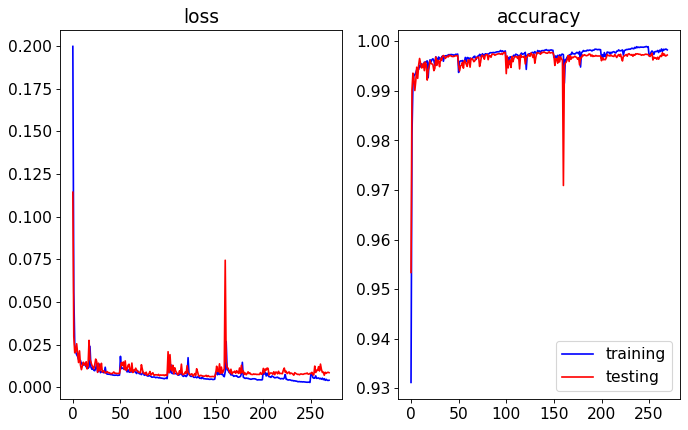

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


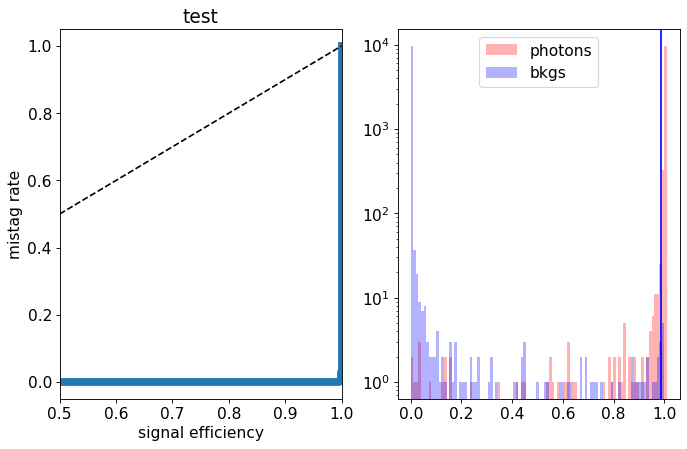

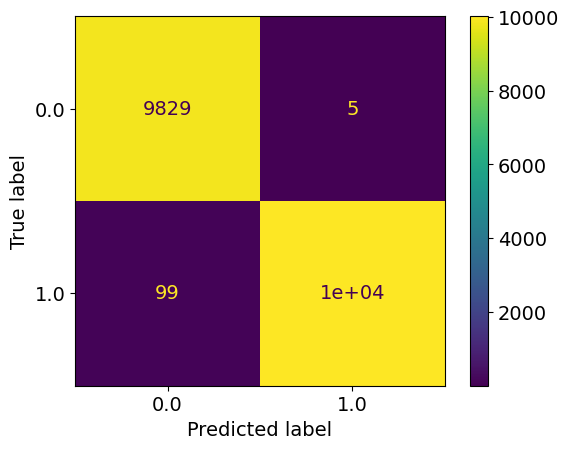

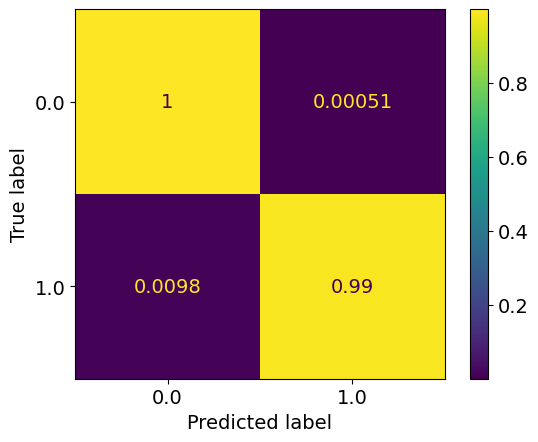

epoch: 270
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004231699810683929
train acc: 0.9982583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.007454357397578219
test acc: 0.997444
epoch: 271
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0035076069870595334
train acc: 0.9987846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.007885524586634026
test acc: 0.997444
epoch: 272
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003940943991149291
train acc: 0.99839616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.0085233943646017
test acc: 0.99729365
epoch: 273
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.003581719681455097
train acc: 0.9986718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.008469666112004608
test acc: 0.9970431
epoch: 274
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003865527717838387
train acc: 0.9984087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.008916331752355773
test acc: 0.9971934
epoch: 275
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0035725088150752185
train acc: 0.9986342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.00946658241274931
test acc: 0.997444
epoch: 276
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003379660543670518
train acc: 0.99869686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.00860971195898481
test acc: 0.99739385
epoch: 277
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0031032603012081388
train acc: 0.99872196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.007971060083946213
test acc: 0.9971934
epoch: 278
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.003090065283116035
train acc: 0.99880964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008046404631921392
test acc: 0.9971934
epoch: 279
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0027541158560779877
train acc: 0.9988974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.007941537039347595
test acc: 0.9972435


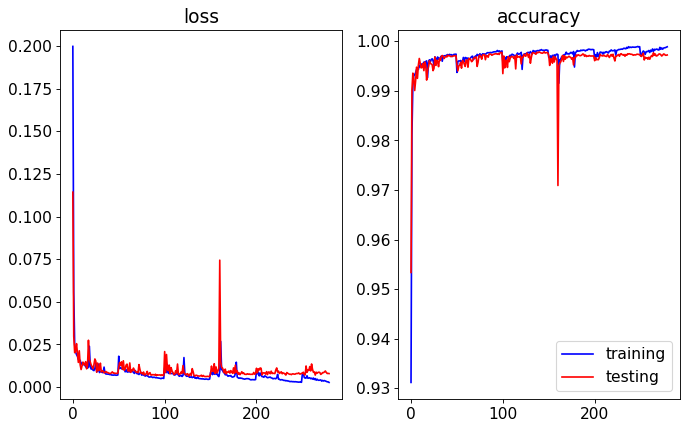

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


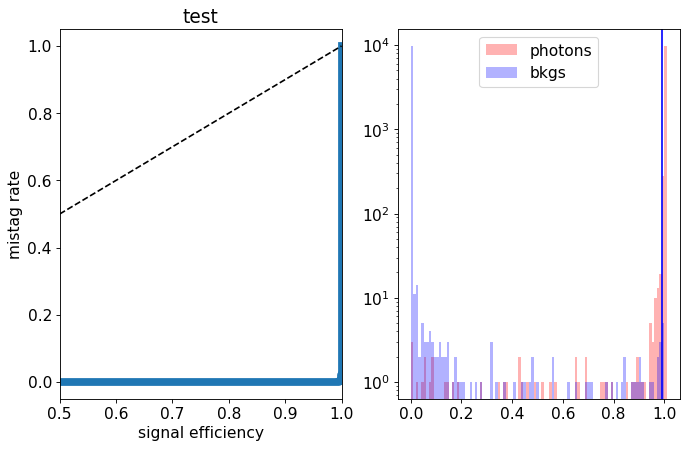

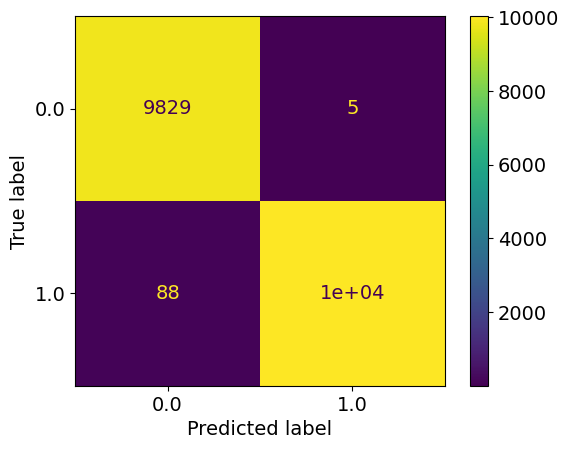

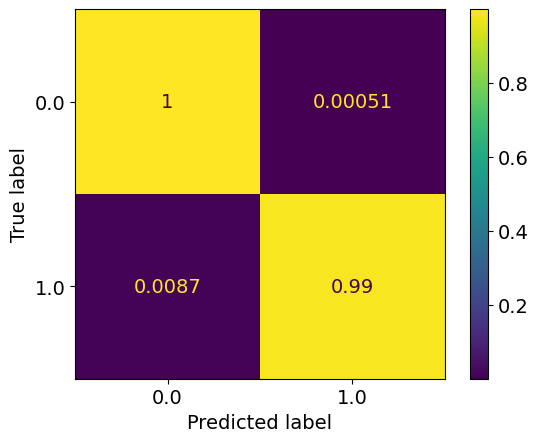

epoch: 280
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003134717169201842
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008464229320559432
test acc: 0.9974941
epoch: 281
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0026446522368594252
train acc: 0.99899757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.009454492842076648
test acc: 0.9977447
epoch: 282
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0028154535969401335
train acc: 0.9988848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.00865874001508072
test acc: 0.9973438
epoch: 283
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0026341303951085138
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008706078091403042
test acc: 0.9976445
epoch: 284
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0022758116194463176
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.009226077329966595
test acc: 0.9973438
epoch: 285
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002336176237560124
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.009041773724568295
test acc: 0.9976946
epoch: 286
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.003100679526589863
train acc: 0.99911034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.010422775905360194
test acc: 0.99714327
epoch: 287
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.004892176526719772
train acc: 0.99843377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.008491214747931842
test acc: 0.9971934
epoch: 288
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.002777507722751566
train acc: 0.9988723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.008427034191246255
test acc: 0.99729365
epoch: 289
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0025470560677644948
train acc: 0.9989349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.008406411886967897
test acc: 0.997444


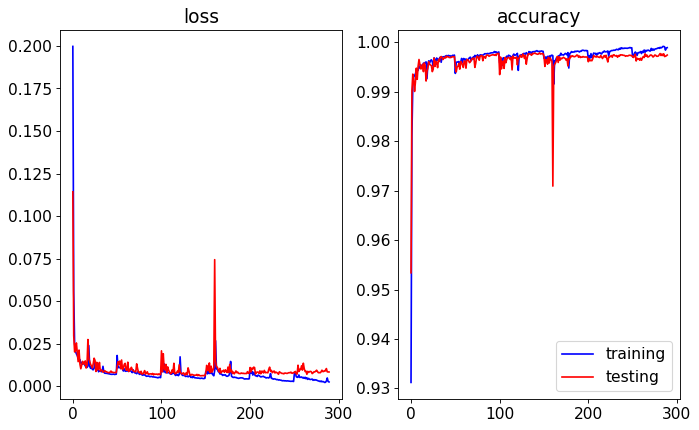

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


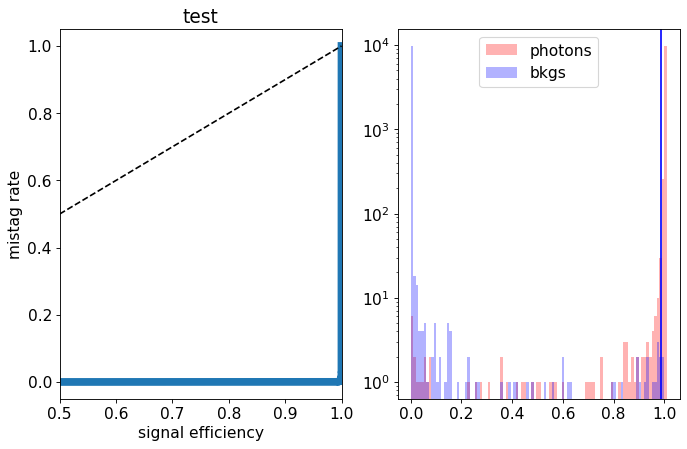

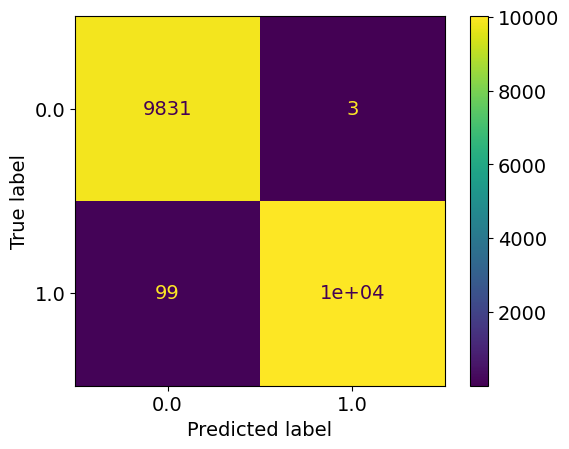

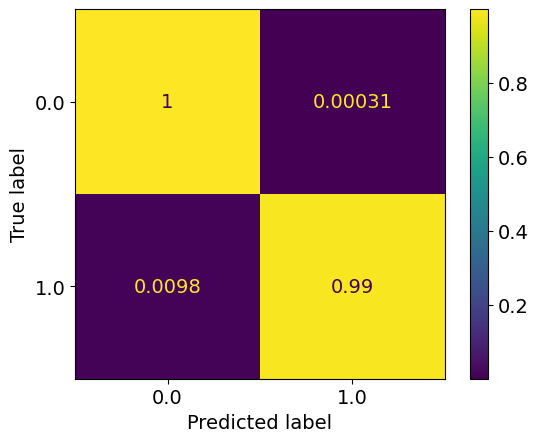

epoch: 290
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002131830028525602
train acc: 0.9992106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.008698010068602505
test acc: 0.9972435
epoch: 291
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.002122686499423076
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.008666490090784946
test acc: 0.9973438
epoch: 292
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0021807299180819344
train acc: 0.9991229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.15it/s]


test loss: 0.009732230178248273
test acc: 0.99759436
epoch: 293
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002165148058935953
train acc: 0.99911034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.009299903086310438
test acc: 0.9974941
epoch: 294
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0021445642857420965
train acc: 0.9992482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.008920718595618382
test acc: 0.9971934
epoch: 295
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.0019851695148977106
train acc: 0.9992106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008861674738428145
test acc: 0.99729365
epoch: 296
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0022031443794359273
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.008958114022200736
test acc: 0.997444
epoch: 297
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002073952934253286
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.008823532326834324
test acc: 0.99729365
epoch: 298
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002115816210925235
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008829475603252993
test acc: 0.99729365
epoch: 299
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002069903578028889
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008985919463478187
test acc: 0.99729365


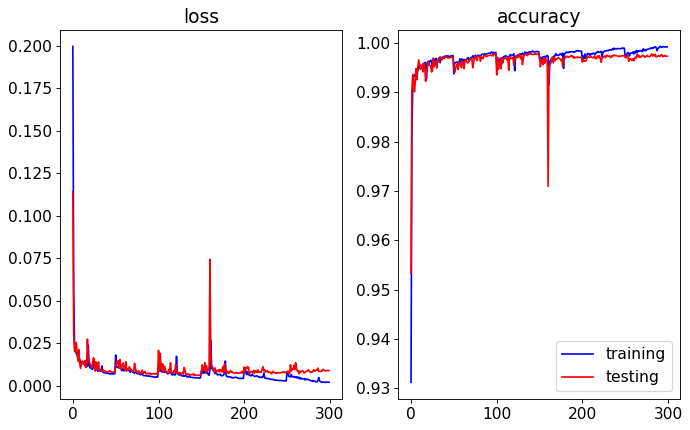

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


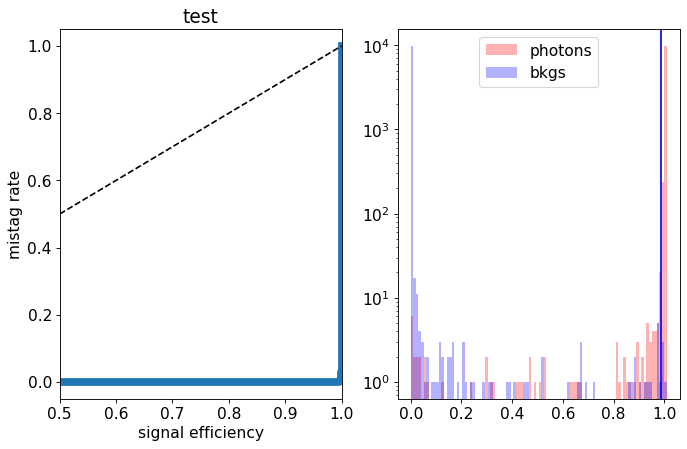

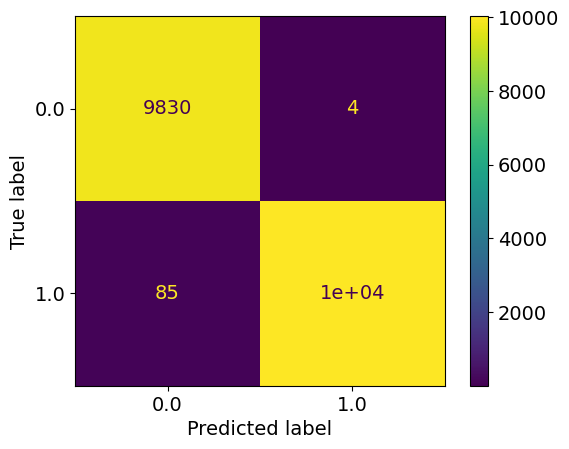

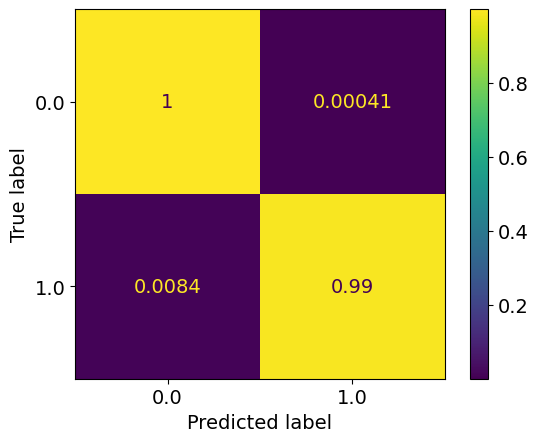

epoch: 300
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.005028120258457285
train acc: 0.9980077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.008948574539531632
test acc: 0.99699295
epoch: 301
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.005574790599717717
train acc: 0.9979952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.009277205071959864
test acc: 0.99679244
epoch: 302
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004309653801400017
train acc: 0.9984087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.01931612822569578
test acc: 0.9951386
epoch: 303
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.006601003031554778
train acc: 0.9975817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.01023030677007388
test acc: 0.9969428
epoch: 304
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004117427205732275
train acc: 0.9984212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008449126939761782
test acc: 0.997444
epoch: 305
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0038438156759062325
train acc: 0.99855906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.32it/s]


test loss: 0.009503923251245664
test acc: 0.9971934
epoch: 306
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0035020117571453306
train acc: 0.9985841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008367691028123611
test acc: 0.9976445
epoch: 307
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.004355259987614229
train acc: 0.99834603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.007793222357577179
test acc: 0.99739385
epoch: 308
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.0047826221075464035
train acc: 0.99819565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.007884476844029611
test acc: 0.997444
epoch: 309
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.004015394462634735
train acc: 0.9984463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.007964367033256328
test acc: 0.9970431


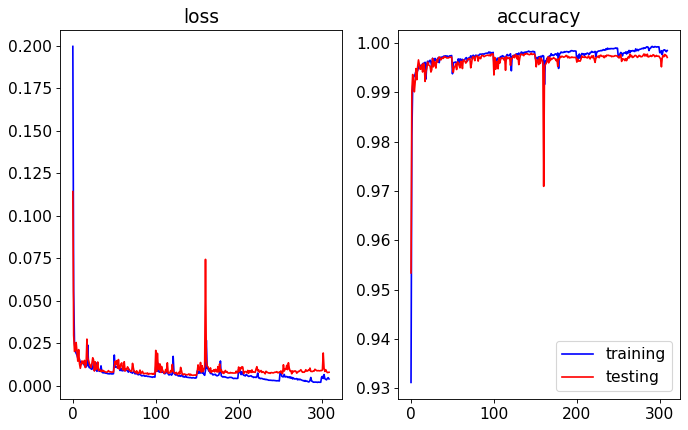

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


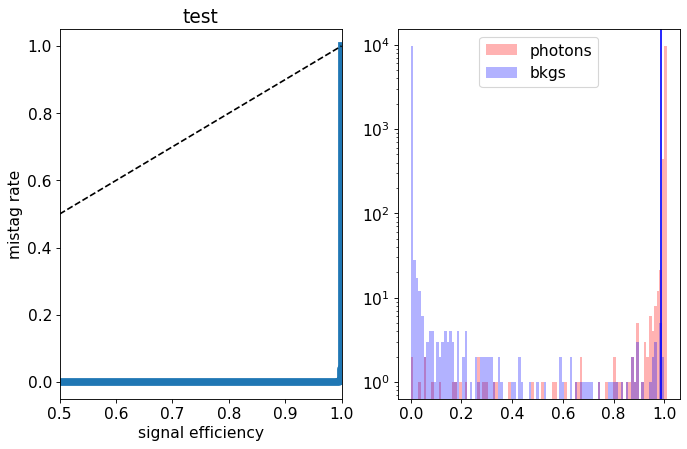

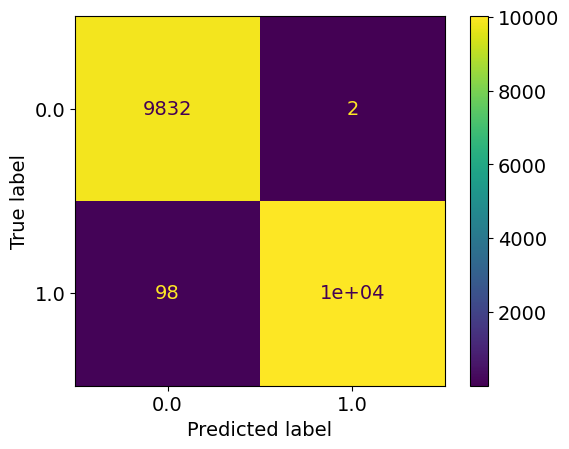

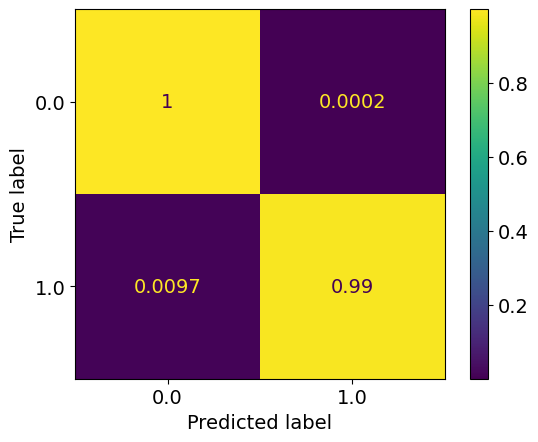

epoch: 310
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.003801418640362621
train acc: 0.9985966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.008869405572220464
test acc: 0.99739385
epoch: 311
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004281244611666122
train acc: 0.99823326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007339424332124455
test acc: 0.9975442
epoch: 312
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.003945378334489095
train acc: 0.99843377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.010480336477485253
test acc: 0.99699295
epoch: 313
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0038564925280026264
train acc: 0.99853396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.008958461529212347
test acc: 0.99709314
epoch: 314
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0033459509013754095
train acc: 0.9987595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008989516261863173
test acc: 0.99684256
epoch: 315
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.008261792376057446
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.007592187278479447
test acc: 0.99714327
epoch: 316
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0037863419843844567
train acc: 0.9985841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.008377505214679438
test acc: 0.9973438
epoch: 317
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003952816287715878
train acc: 0.99848384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.010967405612652381
test acc: 0.99649173
epoch: 318
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.004014459802419872
train acc: 0.99848384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.49it/s]


test loss: 0.007518837085466229
test acc: 0.997444
epoch: 319
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0032782501057498402
train acc: 0.9987595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.009157992164974156
test acc: 0.9971934


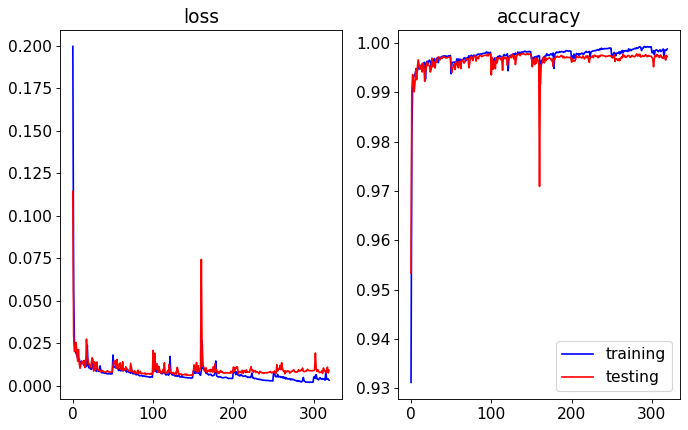

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


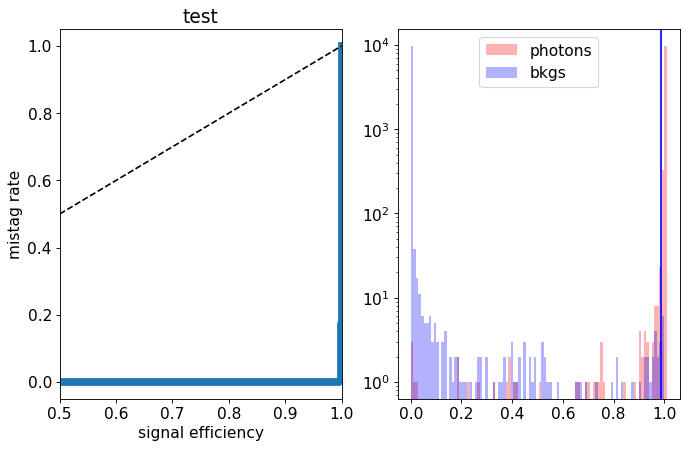

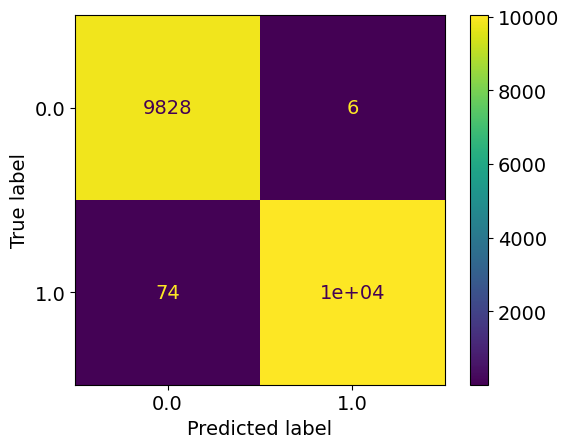

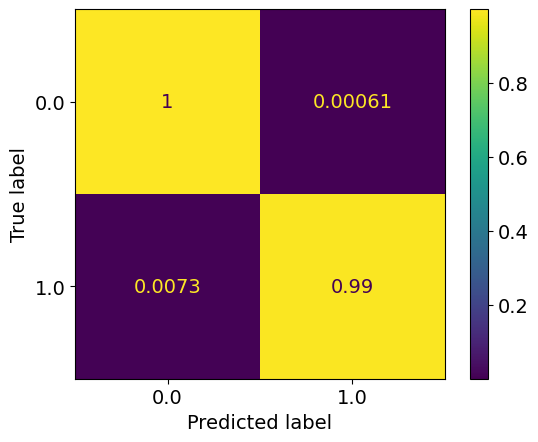

epoch: 320
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.004308176814528953
train acc: 0.9983084


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.009454101217510042
test acc: 0.9971934
epoch: 321
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.003419438441447547
train acc: 0.9985841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.00901100943241652
test acc: 0.99709314
epoch: 322
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0031091773049791217
train acc: 0.99868435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.15it/s]


test loss: 0.012127292680602027
test acc: 0.99684256
epoch: 323
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003067693618667458
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007955914324745262
test acc: 0.9972435
epoch: 324
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.003008270326022488
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.008765526497775093
test acc: 0.997444
epoch: 325
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002831815632131355
train acc: 0.9987595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.009537913564332378
test acc: 0.99684256
epoch: 326
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002841338674372408
train acc: 0.9988974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.008720553677823558
test acc: 0.9973438
epoch: 327
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002738754915747029
train acc: 0.9988974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.010741054621094544
test acc: 0.99714327
epoch: 328
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0028314156745093883
train acc: 0.9988848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.009677073853227365
test acc: 0.9971934
epoch: 329
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002684378862266297
train acc: 0.99884725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.008866310098229031
test acc: 0.997444


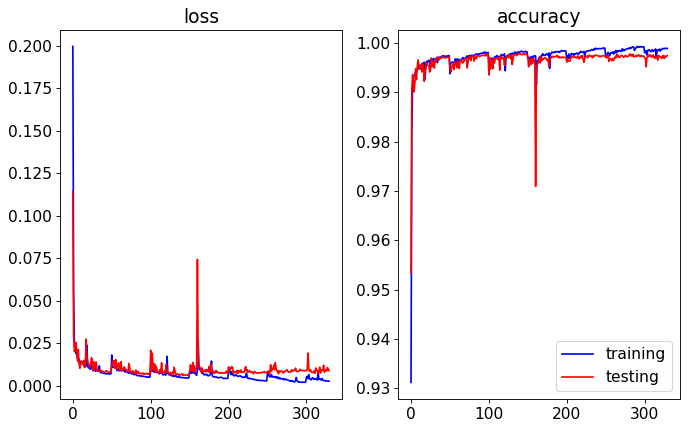

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


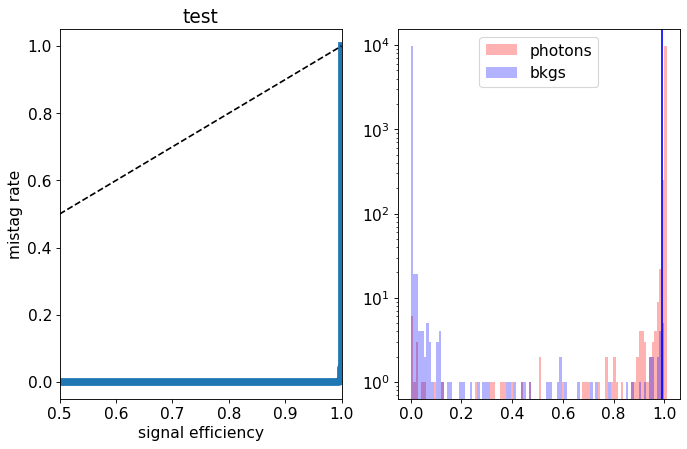

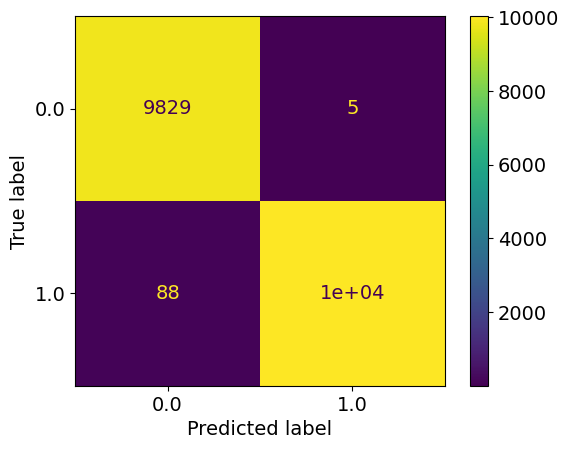

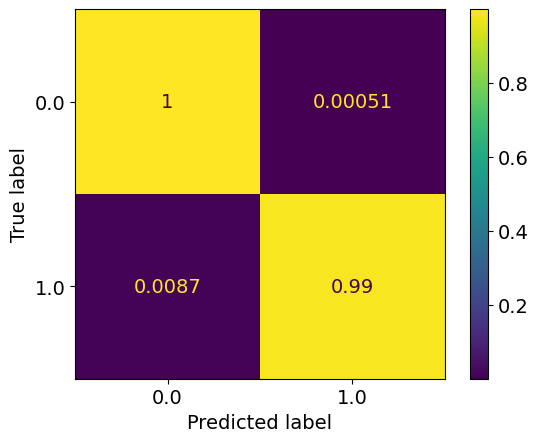

epoch: 330
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00228565681882445
train acc: 0.9990728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.00918150580015636
test acc: 0.99714327
epoch: 331
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002255806385551635
train acc: 0.9990603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.009685288099075585
test acc: 0.99714327
epoch: 332
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.002149236161633088
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.0100257591539583
test acc: 0.99714327
epoch: 333
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0019702367719792706
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.010209516407271354
test acc: 0.9973438
epoch: 334
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0018983555048392169
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.011605025331364767
test acc: 0.99739385
epoch: 335
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0024766180420067656
train acc: 0.9990728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.83it/s]


test loss: 0.009864055001156991
test acc: 0.997444
epoch: 336
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.00312037331754416
train acc: 0.9989099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.010371062431659084
test acc: 0.997444
epoch: 337
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.002096333429121774
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.010322453516076113
test acc: 0.99729365
epoch: 338
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.002899249787319672
train acc: 0.9989475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.009708927101361469
test acc: 0.9972435
epoch: 339
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0018148669616674998
train acc: 0.9992607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.01010569405683354
test acc: 0.9973438


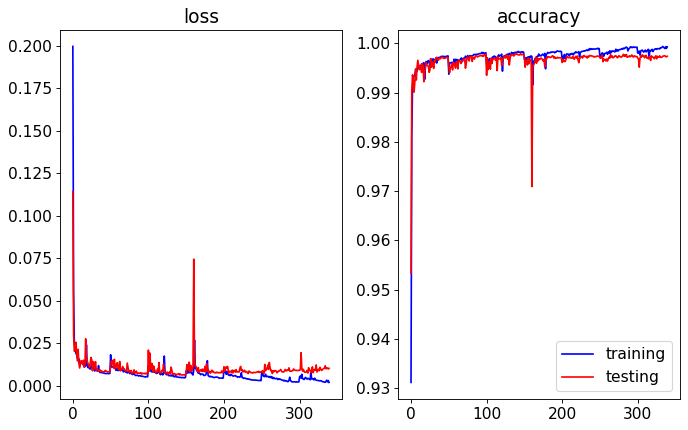

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


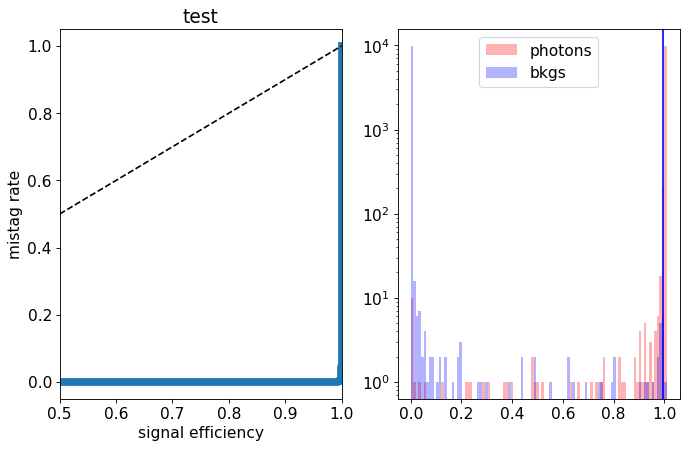

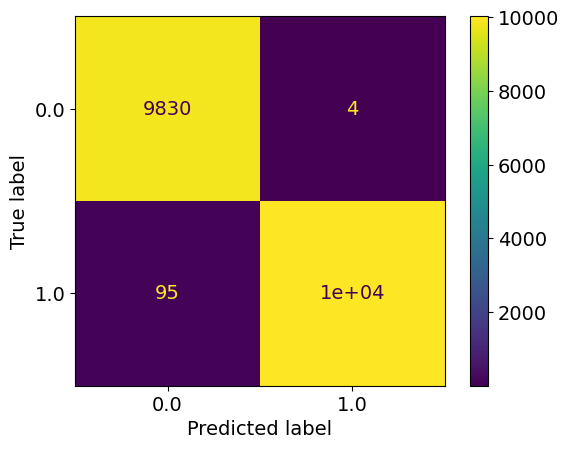

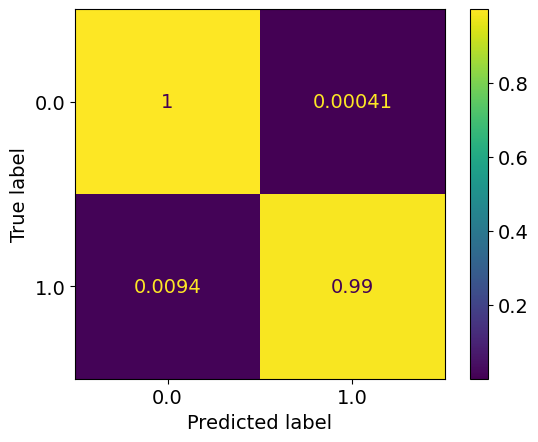

epoch: 340
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.0018930364214964344
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.010133377587461675
test acc: 0.99729365
epoch: 341
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0017024611034182964
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.01064994100263849
test acc: 0.99729365
epoch: 342
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.001842867816679206
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.010557232955975718
test acc: 0.9973438
epoch: 343
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0018651331620547814
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.010581575959804468
test acc: 0.99729365
epoch: 344
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0016683231666564694
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.010364866671058253
test acc: 0.997444
epoch: 345
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0015639706067158434
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.012047241864767036
test acc: 0.9972435
epoch: 346
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.001574724292092313
train acc: 0.99934846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.010536101045652365
test acc: 0.99729365
epoch: 347
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0017512957255986742
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.010510678846825987
test acc: 0.9971934
epoch: 348
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0017737756536631674
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.39it/s]


test loss: 0.011217063987821936
test acc: 0.9971934
epoch: 349
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0015975729774222193
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.010546800510704035
test acc: 0.9971934


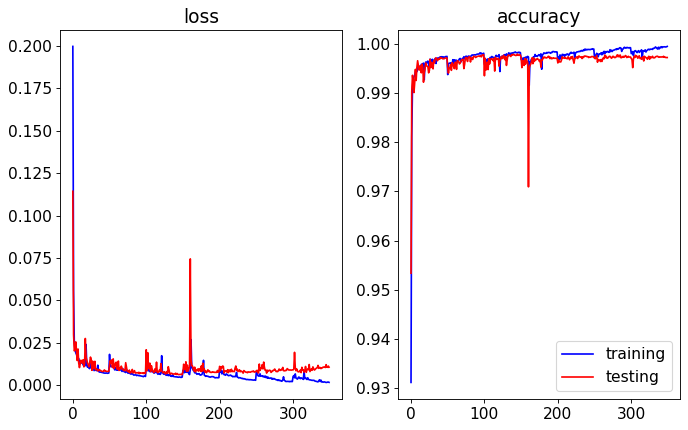

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


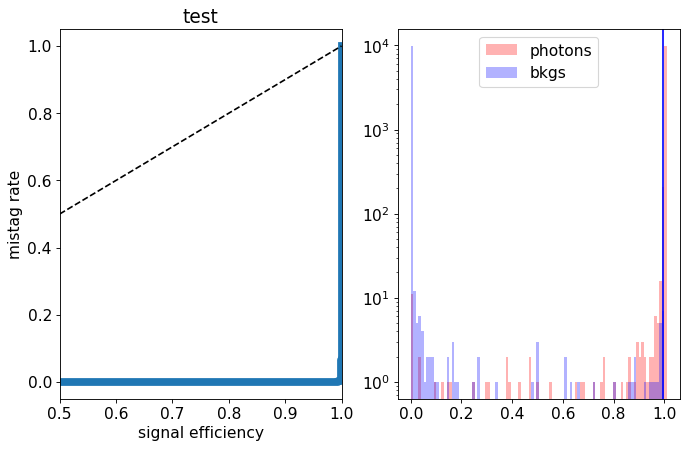

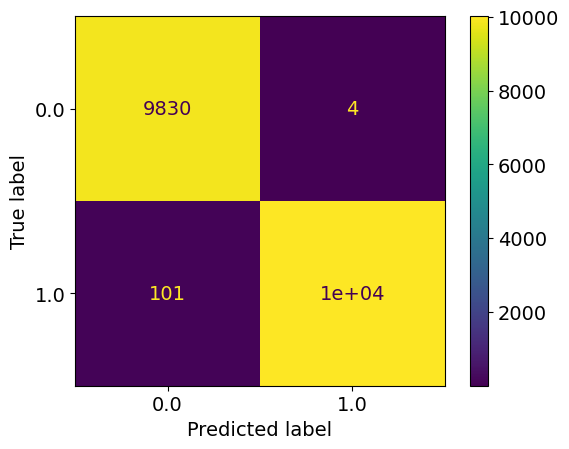

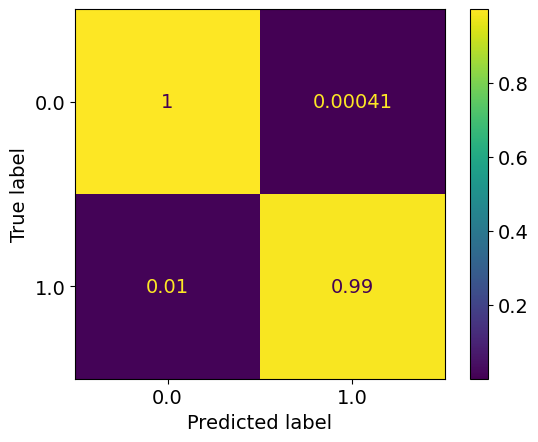

epoch: 350
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.008828642775003587
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.008761619892217876
test acc: 0.9970431
epoch: 351
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004711549309492389
train acc: 0.9980453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.00937228750113076
test acc: 0.9971934
epoch: 352
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004068979444833613
train acc: 0.99835855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.23it/s]


test loss: 0.00956771970146185
test acc: 0.9972435
epoch: 353
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00418158151676748
train acc: 0.9984087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.009830346734173979
test acc: 0.99739385
epoch: 354
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004450000358891843
train acc: 0.9984212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.007712368642815444
test acc: 0.9974941
epoch: 355
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.004849061172902097
train acc: 0.99819565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.009466246239539674
test acc: 0.99714327
epoch: 356
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0035009697608414294
train acc: 0.99855906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.009561481366451035
test acc: 0.997444
epoch: 357
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.003505592264133808
train acc: 0.9985841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008942760966045385
test acc: 0.9975442
epoch: 358
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004181135735459758
train acc: 0.99850893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.01304302535872386
test acc: 0.99644166
epoch: 359
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.005633198800357754
train acc: 0.9979576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.007864033569229137
test acc: 0.9974941


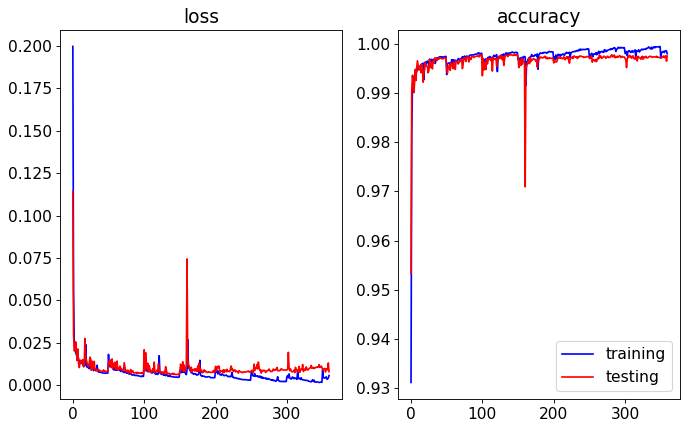

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


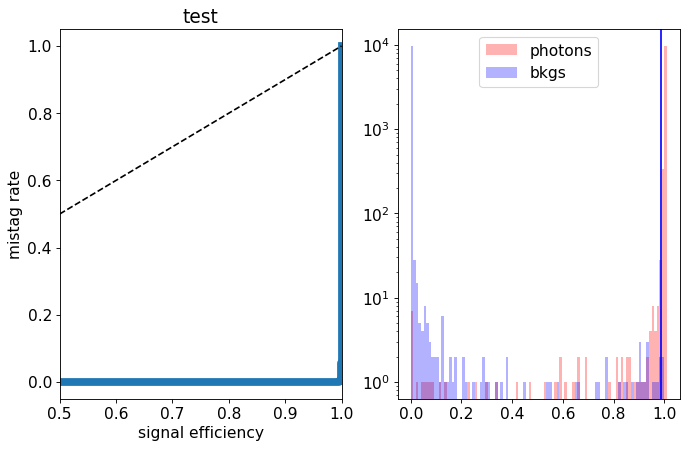

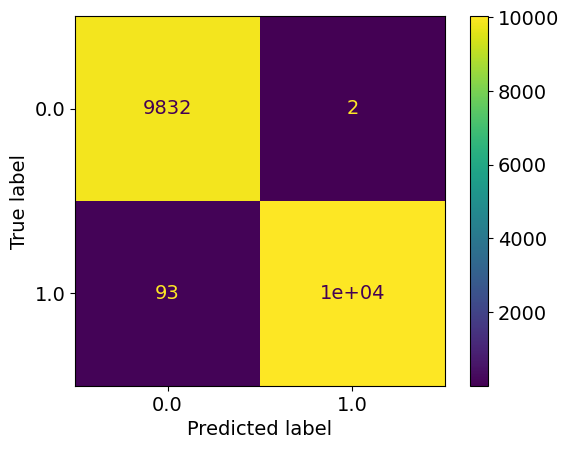

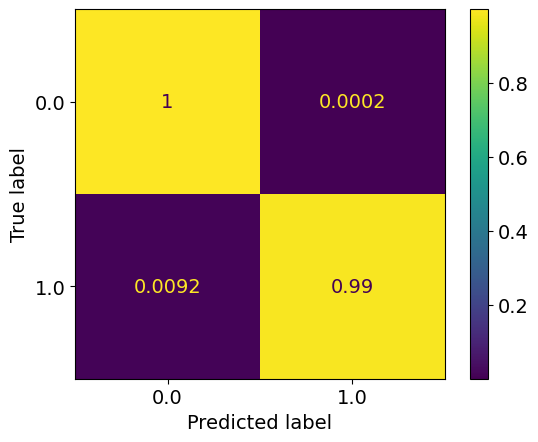

epoch: 360
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0038451605938841864
train acc: 0.99854654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.00723425524227102
test acc: 0.9975442
epoch: 361
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0029987703641867103
train acc: 0.9987846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.008734281014767475
test acc: 0.9974941
epoch: 362
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00311651243871612
train acc: 0.9987094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.007973223261668702
test acc: 0.9972435
epoch: 363
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.0029853520355748392
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.012542366366901928
test acc: 0.9966421
epoch: 364
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0027823130286962366
train acc: 0.9988723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.009079075267971562
test acc: 0.99729365
epoch: 365
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0030328867413036685
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.44it/s]


test loss: 0.009366963507679483
test acc: 0.9971934
epoch: 366
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002796787221168008
train acc: 0.9989349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.009153891394496039
test acc: 0.99709314
epoch: 367
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0024233658484818254
train acc: 0.99899757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.010770338161632132
test acc: 0.9972435
epoch: 368
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.002939236809103436
train acc: 0.99884725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.008485967937731938
test acc: 0.99759436
epoch: 369
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002538830800132466
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.009755059514324838
test acc: 0.99729365


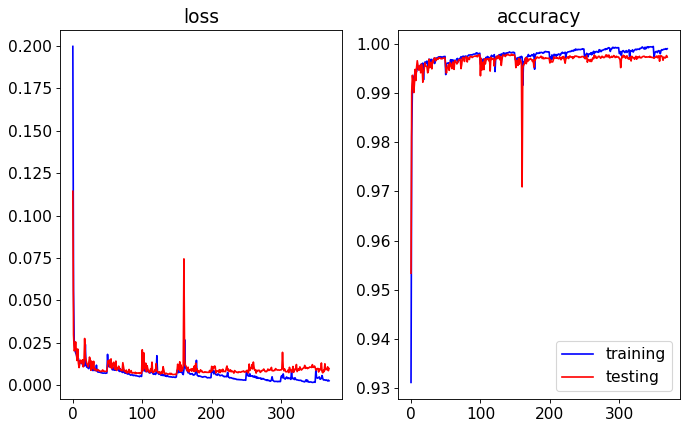

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


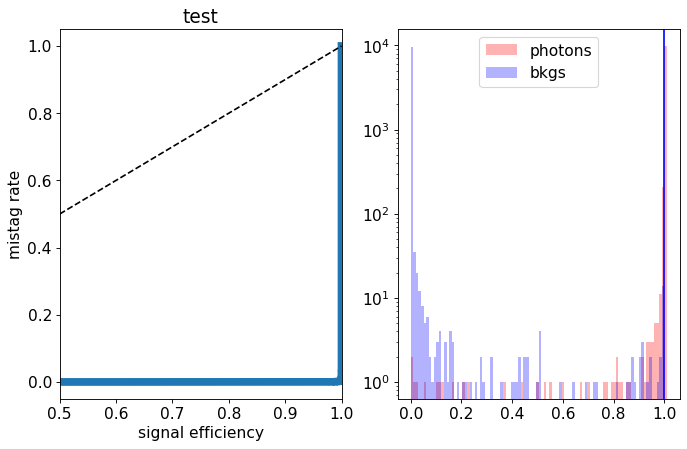

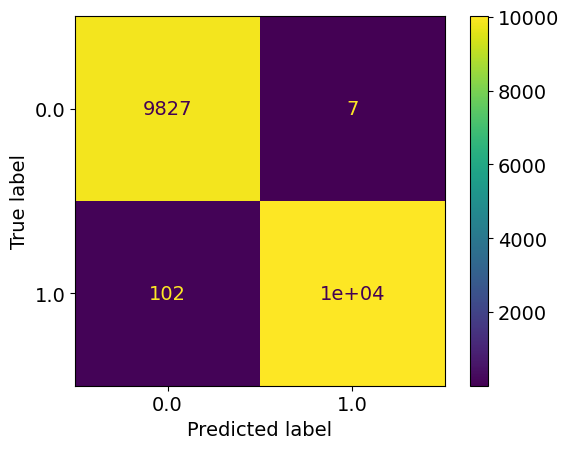

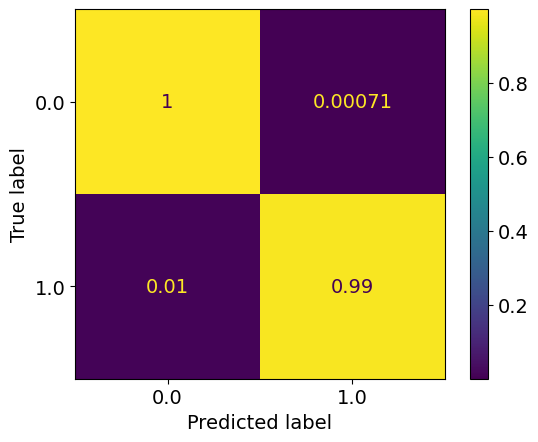

epoch: 370
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.002870215598799839
train acc: 0.9990853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008407484368517008
test acc: 0.99759436
epoch: 371
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.005126983807376441
train acc: 0.9981455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.010609023348746738
test acc: 0.99709314
epoch: 372
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.0026971345869785195
train acc: 0.99884725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008576597041717511
test acc: 0.99729365
epoch: 373
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002449603174247739
train acc: 0.99914795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008949118276231113
test acc: 0.9975442
epoch: 374
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0022785263131407532
train acc: 0.99914795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.01074118210860487
test acc: 0.99729365
epoch: 375
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0022481485282581284
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.009227709900348118
test acc: 0.99714327
epoch: 376
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0025164158347725355
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.00866118719910874
test acc: 0.9973438
epoch: 377
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002057234002120876
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.009729055022463025
test acc: 0.99729365
epoch: 378
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0020353638062545936
train acc: 0.99916047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.009436636012490935
test acc: 0.99739385
epoch: 379
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0020517172938050443
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.01028504638131434
test acc: 0.9972435


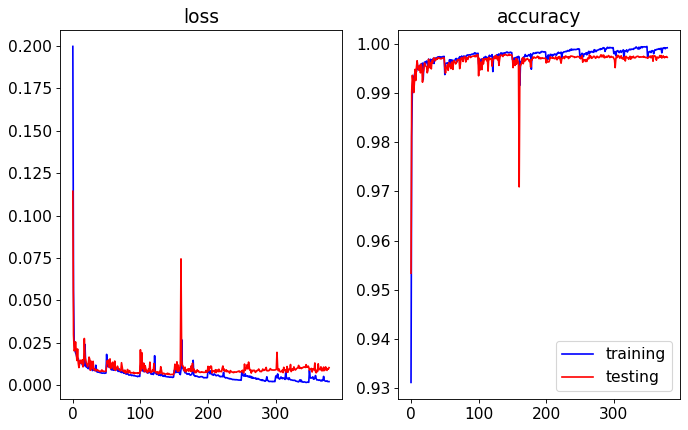

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


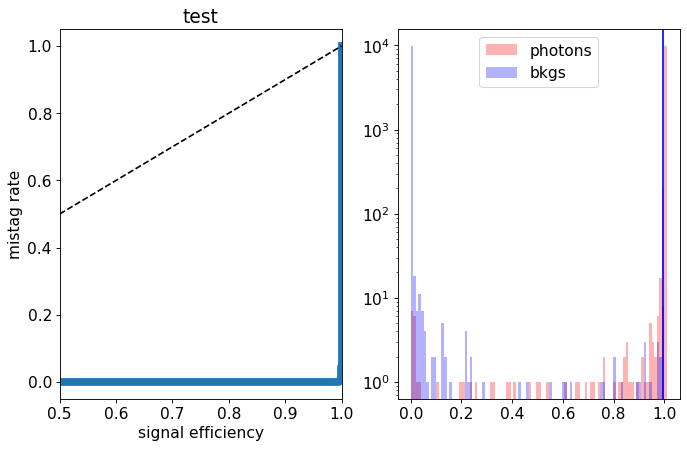

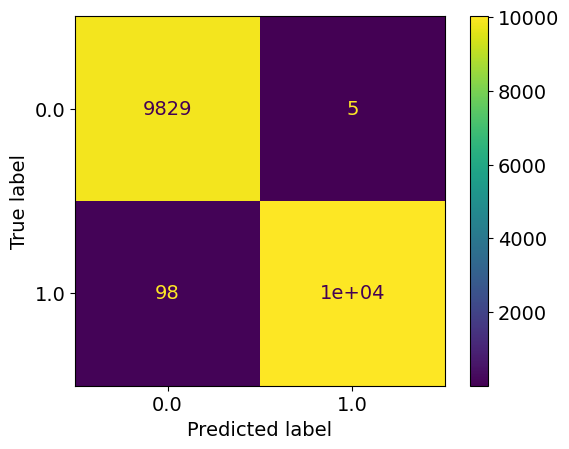

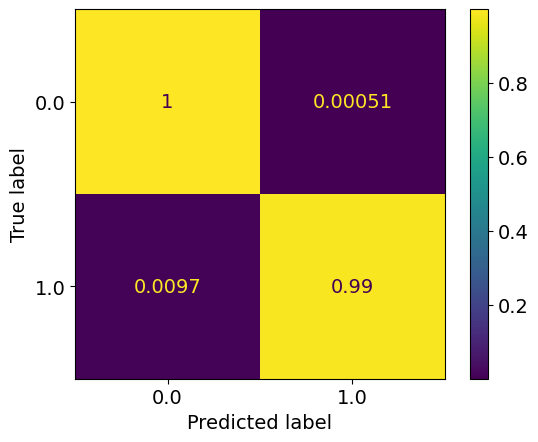

epoch: 380
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.0017816125180483576
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.00it/s]


test loss: 0.010321498049640521
test acc: 0.9973438
epoch: 381
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.0019028952301715068
train acc: 0.99927324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.67it/s]


test loss: 0.010021534971790114
test acc: 0.99739385
epoch: 382
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.0020094459064171474
train acc: 0.9992106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.009833340100800236
test acc: 0.99714327
epoch: 383
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0016335381142605627
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.01013952354728912
test acc: 0.99709314
epoch: 384
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0015924077914819667
train acc: 0.99944866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011540873935326304
test acc: 0.99739385
epoch: 385
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.001603822730584255
train acc: 0.999386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.009950809416633385
test acc: 0.9974941
epoch: 386
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0012488752085281533
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.010152130632538019
test acc: 0.99739385
epoch: 387
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0012811835362292676
train acc: 0.9995239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.01053488683197322
test acc: 0.9975442
epoch: 388
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.001421176733680086
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.011269022892627297
test acc: 0.99729365
epoch: 389
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0014197993166362721
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.010472915306309005
test acc: 0.99739385


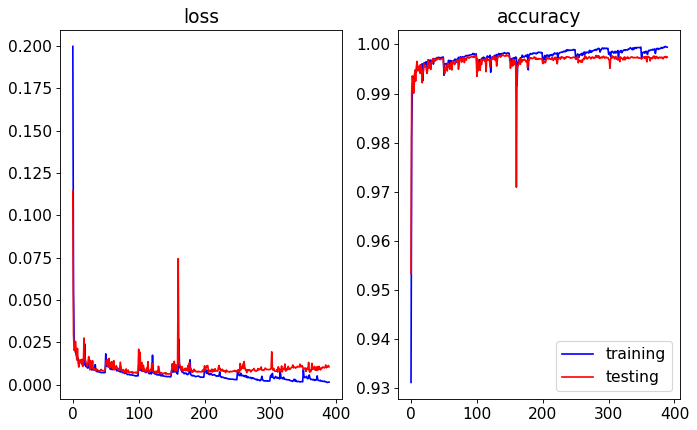

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


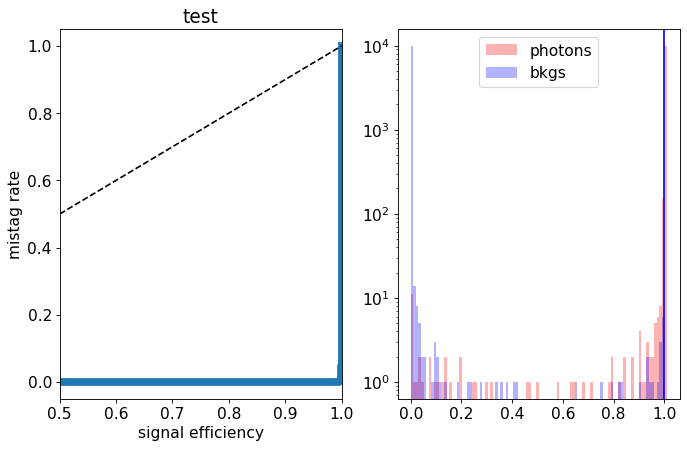

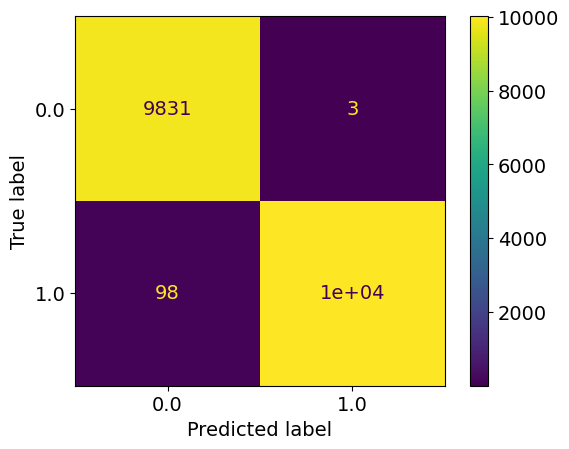

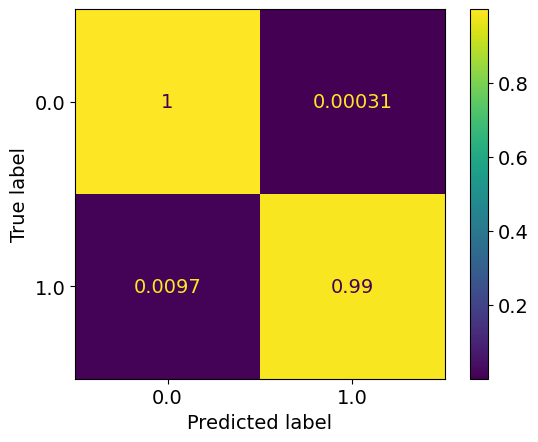

epoch: 390
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0012315576796769374
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011479253803426057
test acc: 0.99739385
epoch: 391
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0012148565655031654
train acc: 0.9995865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.010759016839034196
test acc: 0.99759436
epoch: 392
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.001280637500905008
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.010917010553277899
test acc: 0.99739385
epoch: 393
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0012476560086383977
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.41it/s]


test loss: 0.010619260068565114
test acc: 0.9974941
epoch: 394
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0010501351052812763
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.010809749916648691
test acc: 0.9975442
epoch: 395
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0011561754579189347
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.010716301598168845
test acc: 0.997444
epoch: 396
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0011342910868992096
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.010689812066275676
test acc: 0.99739385
epoch: 397
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0012004153159772845
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.0117004879814832
test acc: 0.9974941
epoch: 398
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0010968685621753423
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.010821162260192389
test acc: 0.9974941
epoch: 399
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0011105535874917087
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.01083644876780454
test acc: 0.9974941


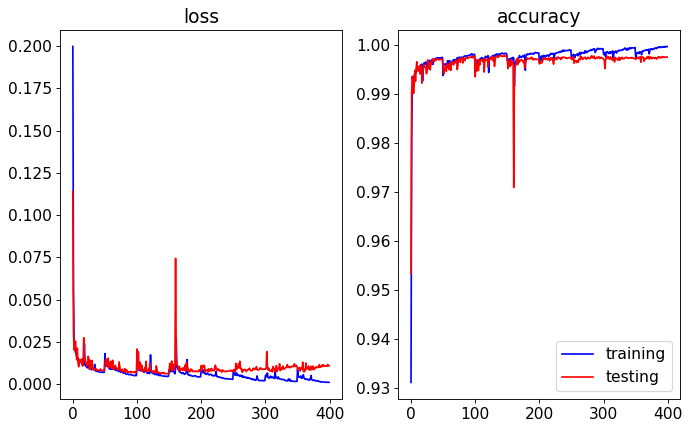

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


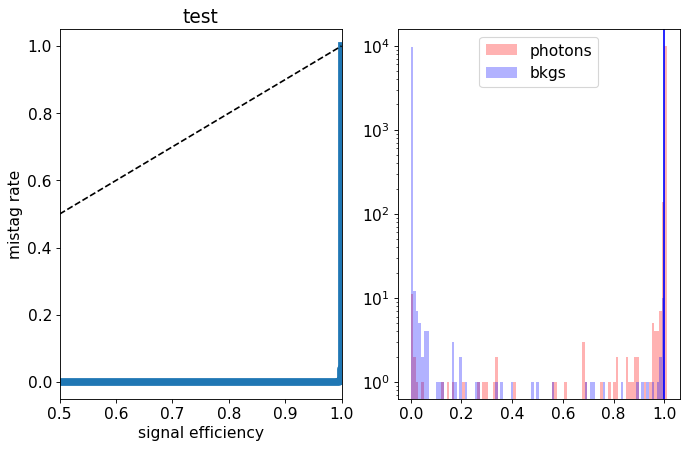

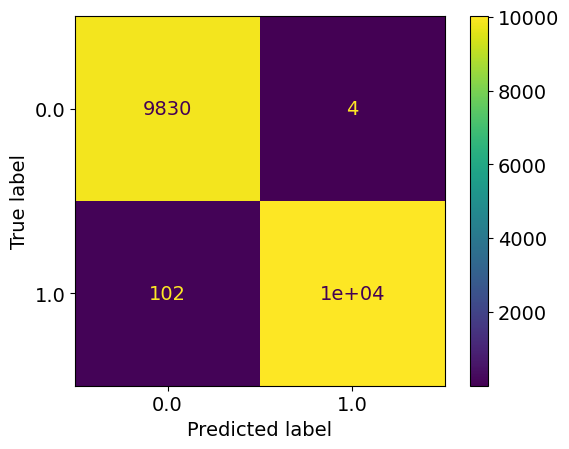

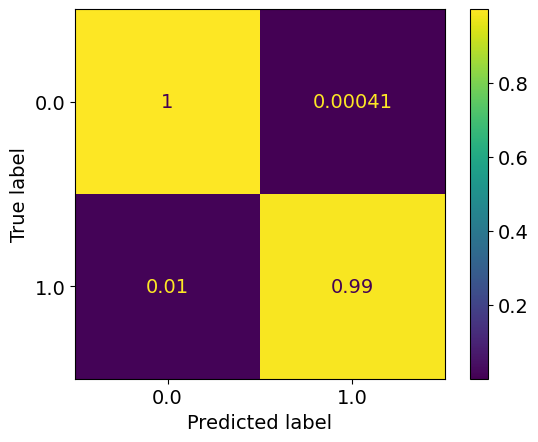

epoch: 400
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.009268719167063063
train acc: 0.99688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.010056763715350399
test acc: 0.9963414
epoch: 401
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004618480979843298
train acc: 0.9981581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.011591092772826361
test acc: 0.99679244
epoch: 402
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0036422991217283543
train acc: 0.99843377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.01073785781430642
test acc: 0.9968927
epoch: 403
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0037795959668942693
train acc: 0.9986342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.010342186850988689
test acc: 0.99684256
epoch: 404
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0032909748485598247
train acc: 0.9987094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.008876794067285065
test acc: 0.9972435
epoch: 405
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0032197950261691932
train acc: 0.9987094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.007527806248296709
test acc: 0.99699295
epoch: 406
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0033442887594796345
train acc: 0.9986342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.14it/s]


test loss: 0.01015921140445725
test acc: 0.997444
epoch: 407
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0033652333500026202
train acc: 0.9987345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.011173695372075172
test acc: 0.99684256
epoch: 408
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003172284830861148
train acc: 0.9987345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.010339412674725549
test acc: 0.99684256
epoch: 409
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0034089792829809762
train acc: 0.9986092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.011053084538349033
test acc: 0.9970431


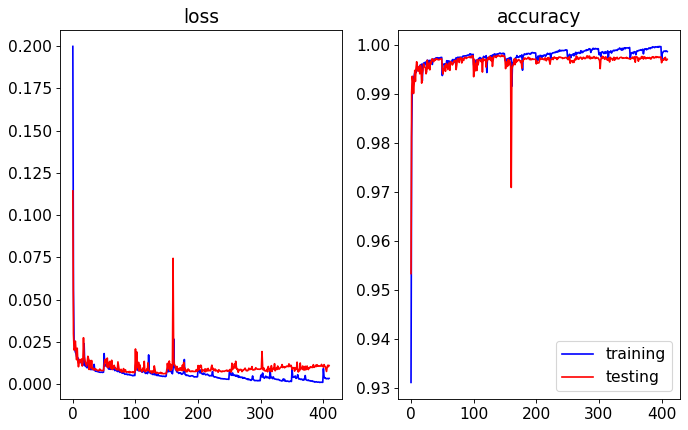

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


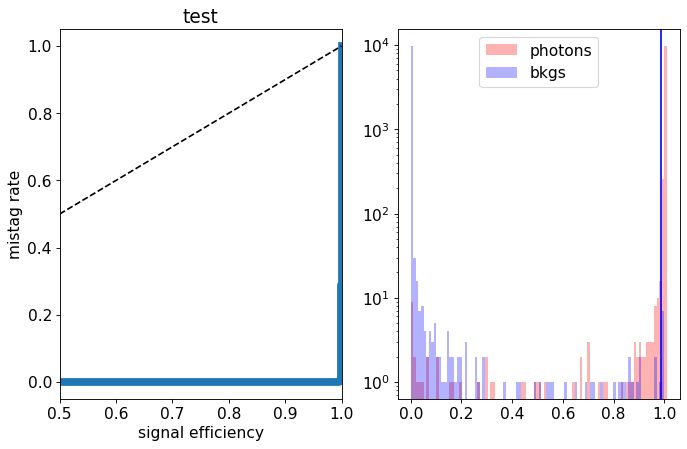

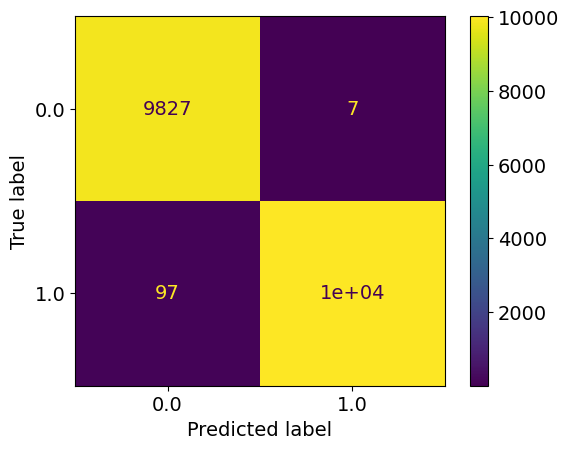

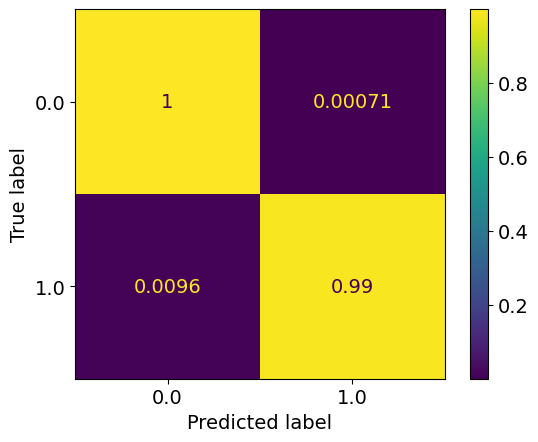

epoch: 410
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0033929051217577878
train acc: 0.99854654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.40it/s]


test loss: 0.007068961825793581
test acc: 0.9974941
epoch: 411
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0022196690973285286
train acc: 0.9990477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.010074677006581196
test acc: 0.99729365
epoch: 412
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002356032735894872
train acc: 0.9990978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.012660953653668164
test acc: 0.99674237
epoch: 413
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0027128203210415804
train acc: 0.9989224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.014421928163809591
test acc: 0.996191
epoch: 414
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003017010048599549
train acc: 0.9989099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.010596482666134013
test acc: 0.9970431
epoch: 415
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0029434717511484477
train acc: 0.99885976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.008795928482868476
test acc: 0.9974941
epoch: 416
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00285701787749273
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.009814899351942371
test acc: 0.99729365
epoch: 417
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.0022875060272092504
train acc: 0.9990728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.010952782471790937
test acc: 0.99679244
epoch: 418
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0021552169350339927
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.011104848094693325
test acc: 0.9972435
epoch: 419
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002518617250412955
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.16it/s]


test loss: 0.011451815454433124
test acc: 0.9970431


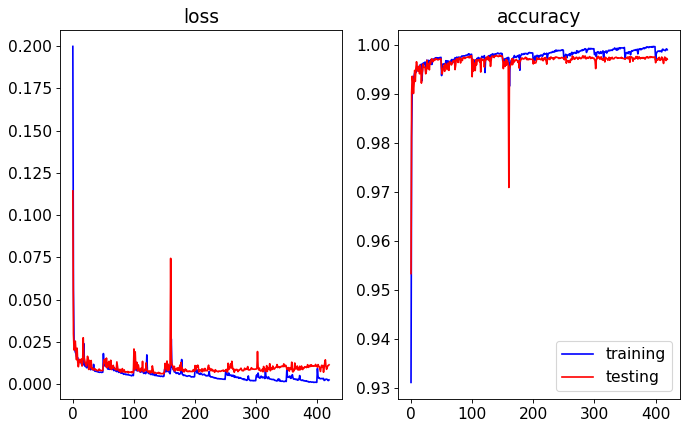

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


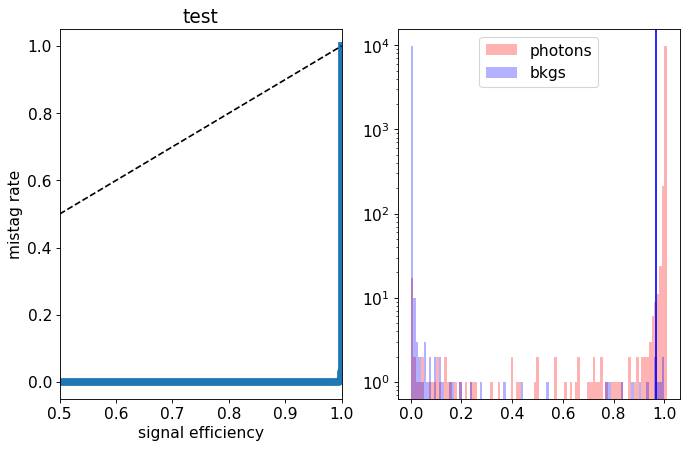

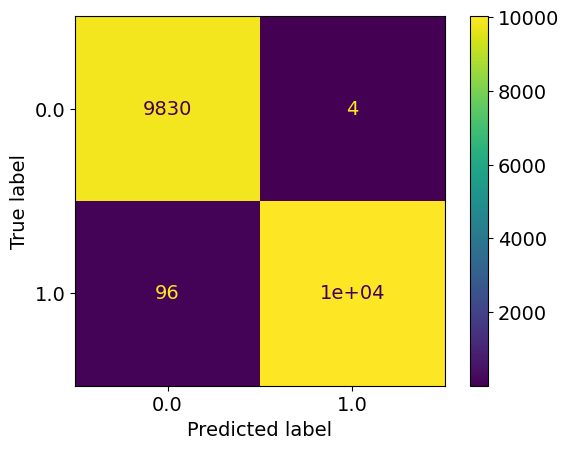

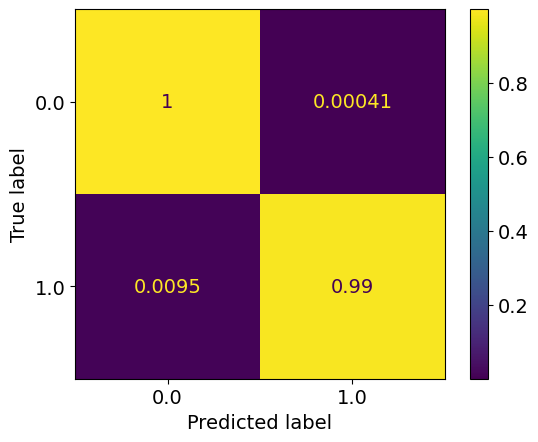

epoch: 420
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0034934896630419198
train acc: 0.9992357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.014960178278911104
test acc: 0.99654186
epoch: 421
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.013152833353404872
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.013203728964607067
test acc: 0.99674237
epoch: 422
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004741919162818283
train acc: 0.9982834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.009821981289539561
test acc: 0.99684256
epoch: 423
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002690028161986678
train acc: 0.99896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.29it/s]


test loss: 0.009231347272254746
test acc: 0.9971934
epoch: 424
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0022423744759119324
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.008827492769769914
test acc: 0.9975442
epoch: 425
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0021628628444534063
train acc: 0.99913543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.009491438276360413
test acc: 0.9972435
epoch: 426
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0019530971111997423
train acc: 0.9992106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.009604555605191682
test acc: 0.99739385
epoch: 427
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0017803661197790665
train acc: 0.9993359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.010160561355352163
test acc: 0.997444
epoch: 428
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0018318046259421985
train acc: 0.9992231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.009879327668065397
test acc: 0.99739385
epoch: 429
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0015454792196646246
train acc: 0.99943614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.01057726785342418
test acc: 0.99739385


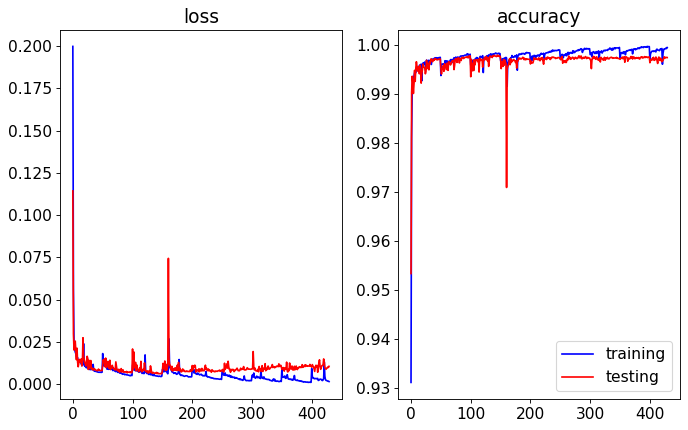

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


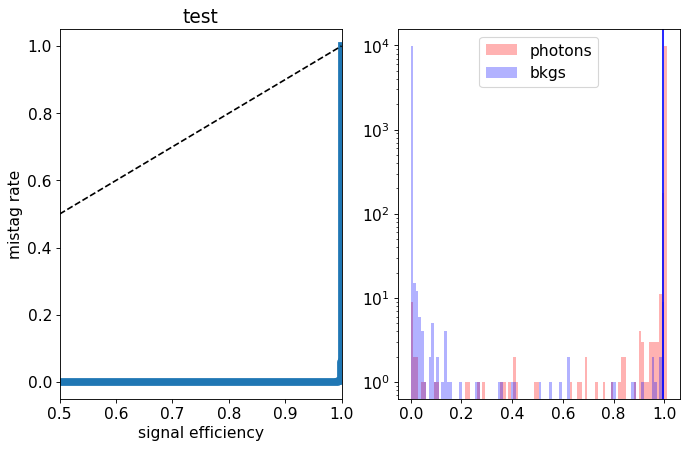

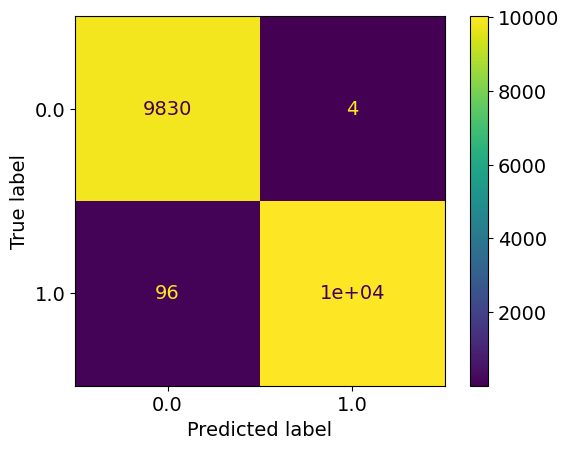

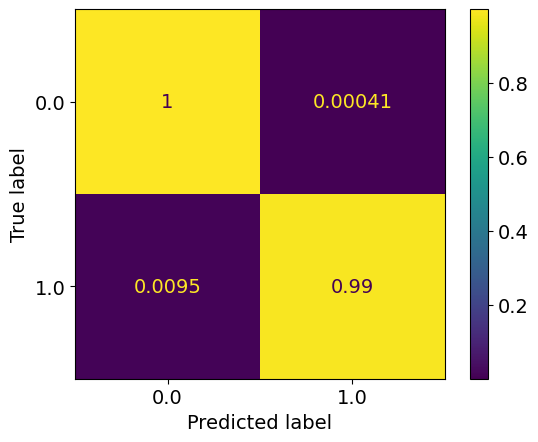

epoch: 430
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0015987459005835623
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.009717553361631015
test acc: 0.9975442
epoch: 431
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.001593630110349621
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011529275020139347
test acc: 0.99714327
epoch: 432
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0017205768186654292
train acc: 0.9993735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.010843222714945167
test acc: 0.9974941
epoch: 433
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0014558858920587063
train acc: 0.9993985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.0101683095580323
test acc: 0.9974941
epoch: 434
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0014115973590921398
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.012012421020806548
test acc: 0.9975442
epoch: 435
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0013097360489195832
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.012242562384926714
test acc: 0.9973438
epoch: 436
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0012924812626534648
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.27it/s]


test loss: 0.01058342805270192
test acc: 0.997444
epoch: 437
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0012410882747488684
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.010413453113334767
test acc: 0.9975442
epoch: 438
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.0011167930133422542
train acc: 0.9996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.01017525547921055
test acc: 0.9974941
epoch: 439
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0013196060010647955
train acc: 0.9994111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.011005832587911487
test acc: 0.997444


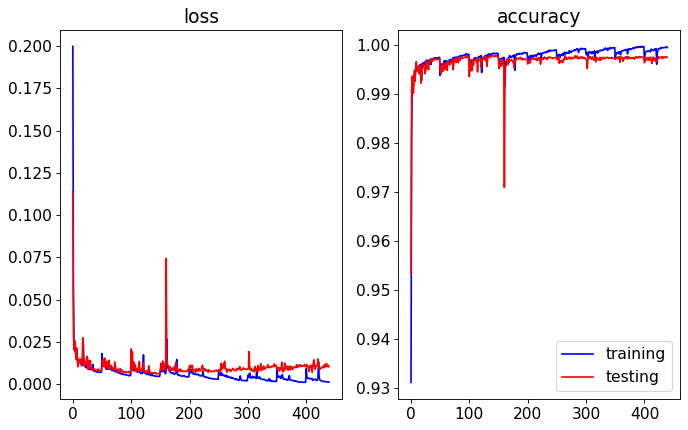

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


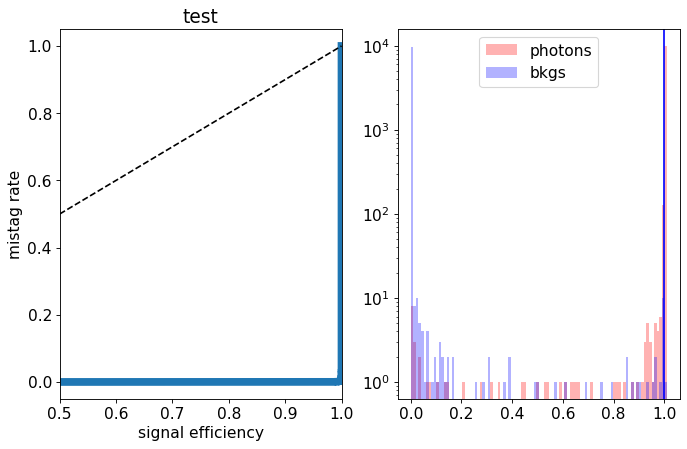

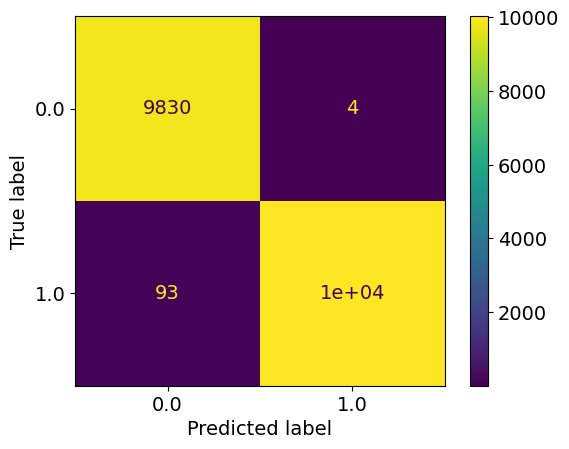

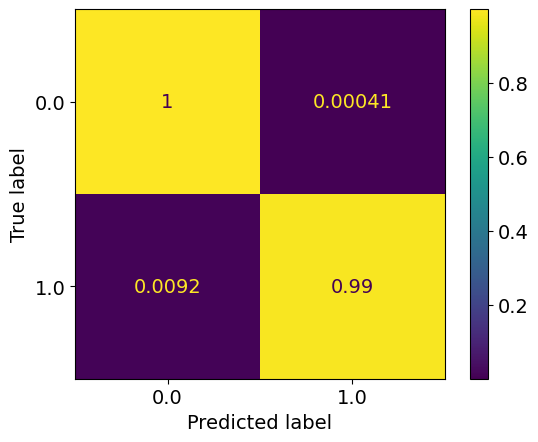

epoch: 440
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0013321561423154337
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.30it/s]


test loss: 0.010524588703661079
test acc: 0.997444
epoch: 441
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.0011448075323804744
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.01251567825281253
test acc: 0.99729365
epoch: 442
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.0012671259048296266
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.011470840019790237
test acc: 0.99729365
epoch: 443
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.001178131550781665
train acc: 0.9994988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.011200107156689816
test acc: 0.9972435
epoch: 444
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0010684818479630713
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.012560723444895464
test acc: 0.9972435
epoch: 445
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.0010620269572359914
train acc: 0.99959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011143237616432303
test acc: 0.9973438
epoch: 446
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.001048278997118427
train acc: 0.9996742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.011072743765479946
test acc: 0.9973438
epoch: 447
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0010417543904657376
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011074647977265532
test acc: 0.9973438
epoch: 448
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0010745531994871271
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011080975275677595
test acc: 0.9973438
epoch: 449
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0011511473158987483
train acc: 0.999574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.28it/s]


test loss: 0.01113389389392443
test acc: 0.9973438


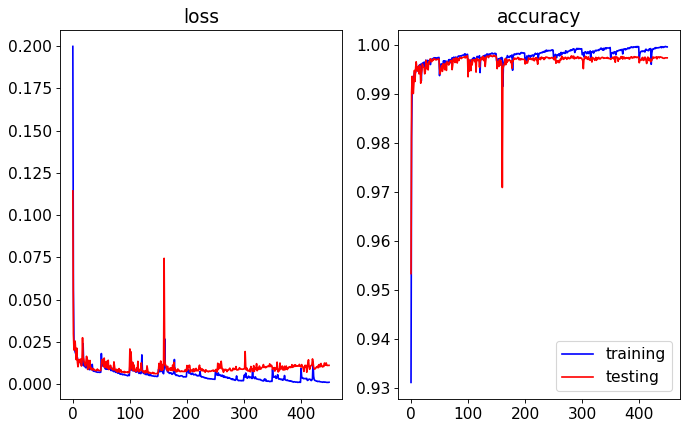

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


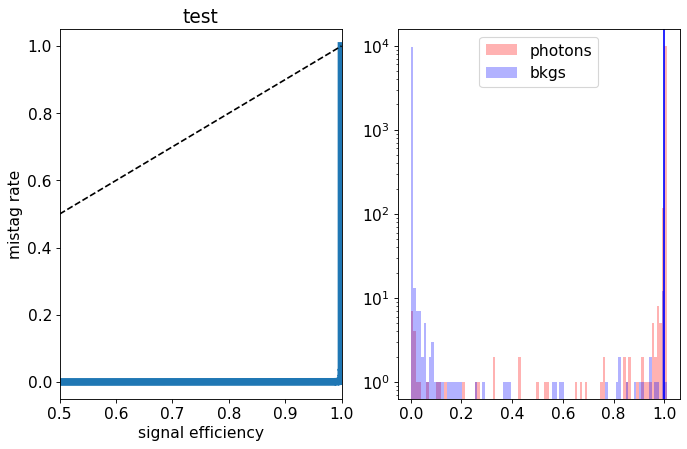

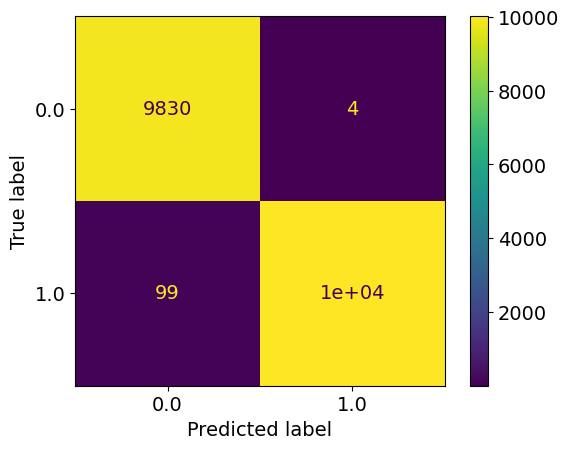

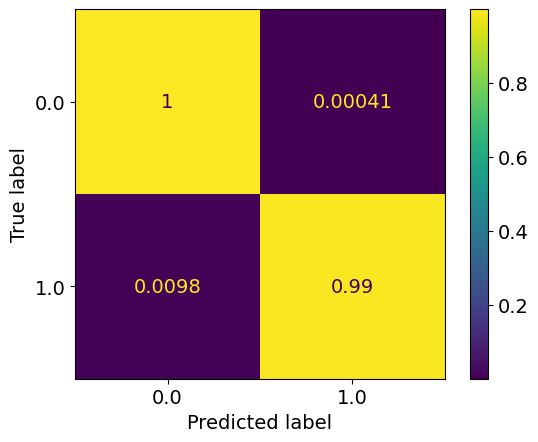

epoch: 450
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00504215659008145
train acc: 0.99819565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.01166919820378312
test acc: 0.9963414
epoch: 451
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.004662549663347607
train acc: 0.9982082


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.012198871694315183
test acc: 0.9968927
epoch: 452
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.004541996739194745
train acc: 0.99827087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.00840981113972649
test acc: 0.99739385
epoch: 453
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.003141423431473875
train acc: 0.99884725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.25it/s]


test loss: 0.010391789646425476
test acc: 0.9974941
epoch: 454
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.002977593682758265
train acc: 0.99880964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.010680690615973779
test acc: 0.99684256
epoch: 455
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0031666586138583883
train acc: 0.99865925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.012096168249520227
test acc: 0.99654186
epoch: 456
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.003071919147699381
train acc: 0.9988723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.008963915377307785
test acc: 0.997444
epoch: 457
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004257871880401662
train acc: 0.9984588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.010373118104967837
test acc: 0.99669224
epoch: 458
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.003344677151167772
train acc: 0.9987971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.012080981238635586
test acc: 0.996592
epoch: 459
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0028490859564666397
train acc: 0.9989224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.010486575037408756
test acc: 0.9971934


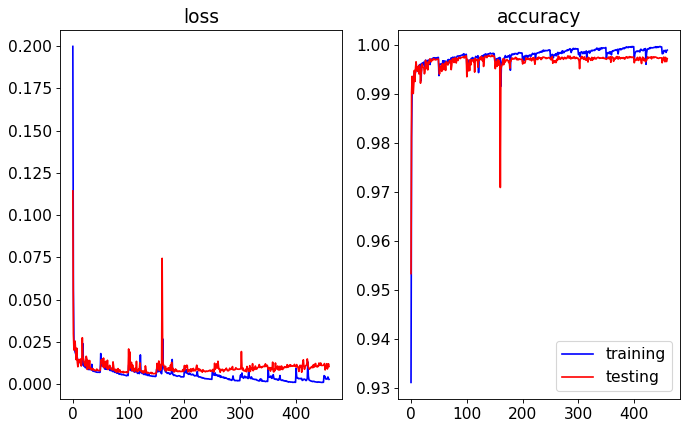

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


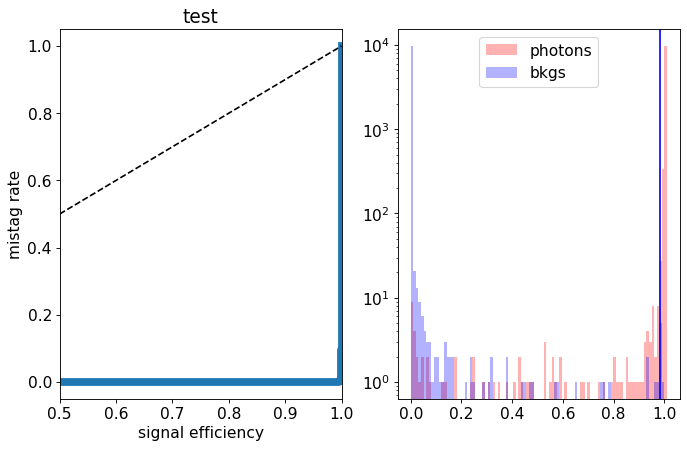

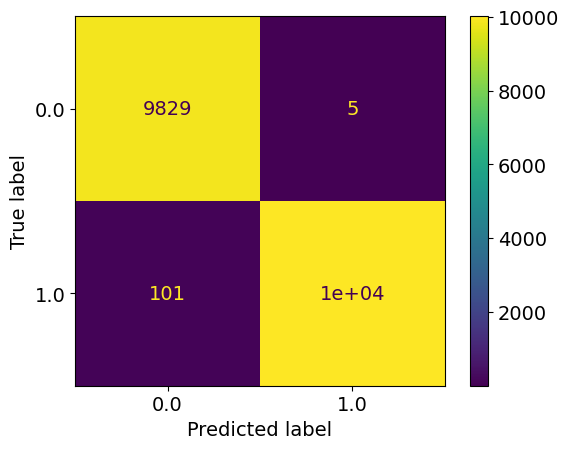

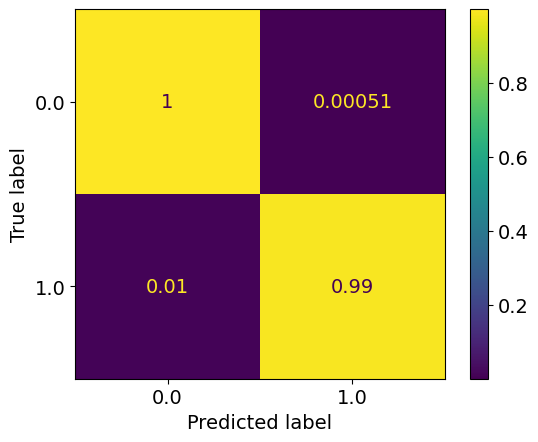

epoch: 460
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.0026724700432535415
train acc: 0.99897254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.009911232252574443
test acc: 0.99714327
epoch: 461
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.0019717844595934773
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.015557156098700087
test acc: 0.99654186
epoch: 462
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.002713035992885851
train acc: 0.9988848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


test loss: 0.011500537332561662
test acc: 0.9971934
epoch: 463
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.002114146493832818
train acc: 0.999173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.010294172054995322
test acc: 0.9971934
epoch: 464
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.0025118511135628773
train acc: 0.99898505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.011357757520112073
test acc: 0.99709314
epoch: 465
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.002669858043423662
train acc: 0.9989475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.009847197486712556
test acc: 0.9972435
epoch: 466
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.002244552758302641
train acc: 0.99918556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.31it/s]


test loss: 0.010374854786010367
test acc: 0.99714327
epoch: 467
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.004025533661240218
train acc: 0.9987094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.009734393037112621
test acc: 0.9971934
epoch: 468
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.002072381765106288
train acc: 0.99928576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.010187185933318688
test acc: 0.99739385
epoch: 469
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0017117293785121098
train acc: 0.99932337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.009944087574802004
test acc: 0.9973438


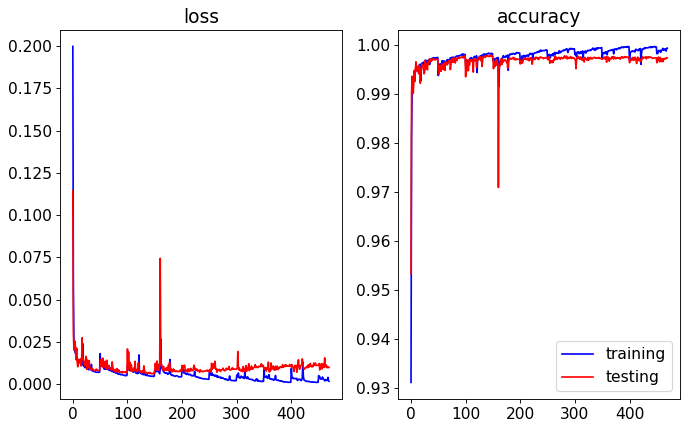

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


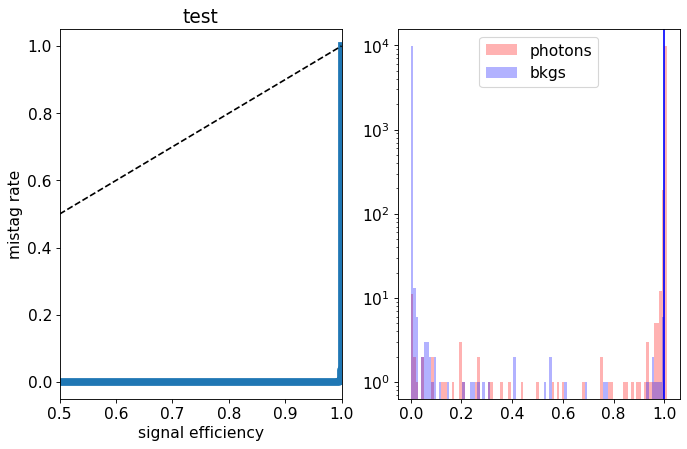

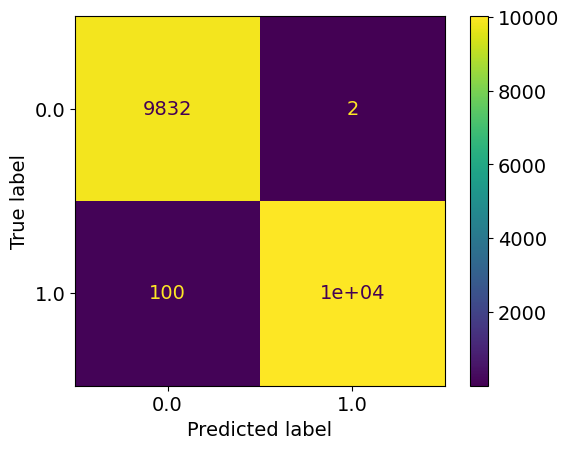

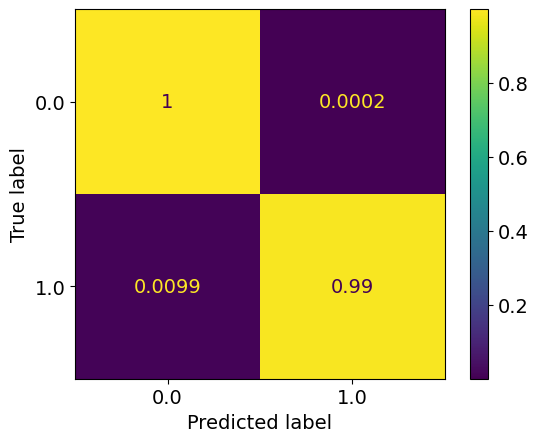

epoch: 470
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0017199630302833988
train acc: 0.99931085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.47it/s]


test loss: 0.013428711278025088
test acc: 0.9968927
epoch: 471
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0018860118462783642
train acc: 0.9991981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.49it/s]


test loss: 0.011484822597434259
test acc: 0.99714327
epoch: 472
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0017574913774785557
train acc: 0.9994236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.009830361068880474
test acc: 0.9972435
epoch: 473
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0017881217782898073
train acc: 0.9992482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.010361632401969367
test acc: 0.9971934
epoch: 474
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0014716164996028042
train acc: 0.99946123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.010249831001334208
test acc: 0.99729365
epoch: 475
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0014827367503530966
train acc: 0.99947375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.012923074760799543
test acc: 0.99709314
epoch: 476
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0014533236104975727
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.011676990806790855
test acc: 0.99709314
epoch: 477
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.00135387462822435
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.012618193152079852
test acc: 0.9970431
epoch: 478
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.58it/s]


train loss: 0.001186215857322748
train acc: 0.9995113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.012260033274822705
test acc: 0.99729365
epoch: 479
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.001207977321339954
train acc: 0.9995364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.23it/s]


test loss: 0.01207761351371814
test acc: 0.99714327


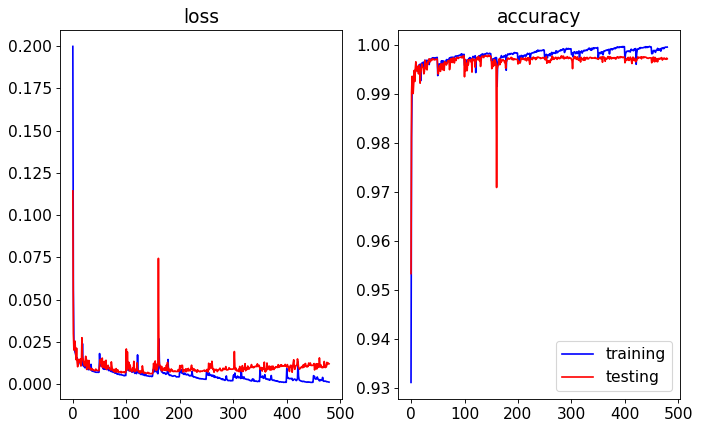

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


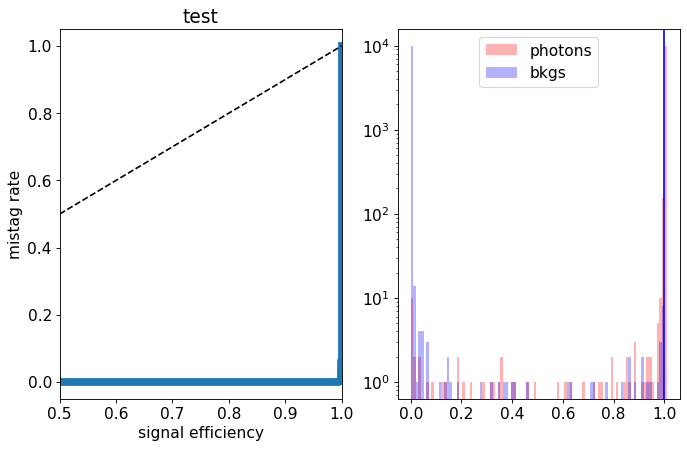

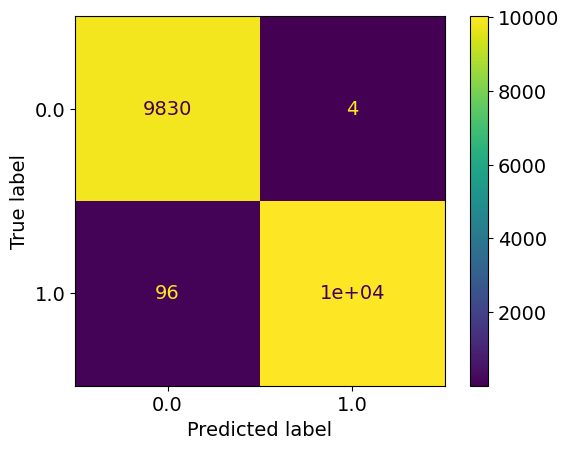

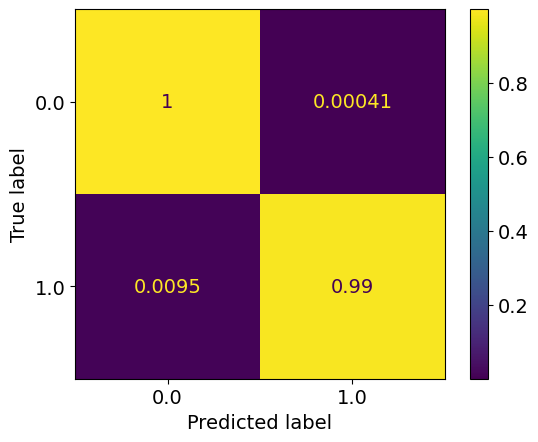

epoch: 480
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.0012673016436465052
train acc: 0.99948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.011064251687323978
test acc: 0.9974941
epoch: 481
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.0010386206158727873
train acc: 0.99961156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.013067229295997736
test acc: 0.9968927
epoch: 482
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.0009168388844126611
train acc: 0.9996617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.0117802017552034
test acc: 0.99729365
epoch: 483
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.0008801381646533288
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.27it/s]


test loss: 0.01305558429692824
test acc: 0.99714327
epoch: 484
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.0009545577163925334
train acc: 0.99959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.012916497811602312
test acc: 0.9973438
epoch: 485
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0008115346647509252
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.013114583441860946
test acc: 0.99729365
epoch: 486
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0007399887615621937
train acc: 0.9997243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.013795696445065593
test acc: 0.9973438
epoch: 487
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0007426570709596029
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.013031514928169438
test acc: 0.99714327
epoch: 488
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.0006471993603907376
train acc: 0.9998246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.012328589618491873
test acc: 0.9974941
epoch: 489
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.0008489348353014609
train acc: 0.9996993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.013766610984449097
test acc: 0.9973438


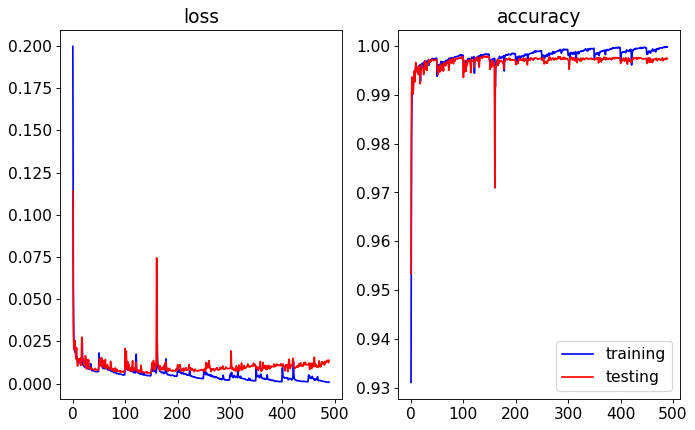

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


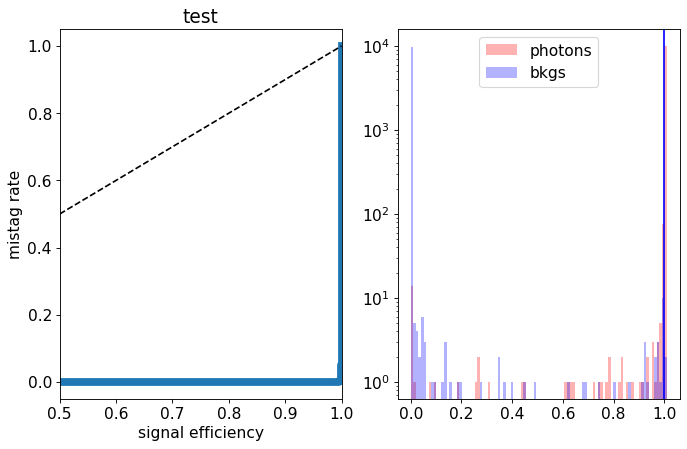

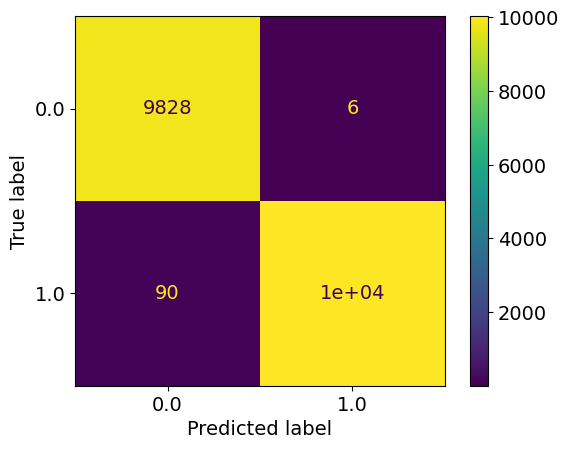

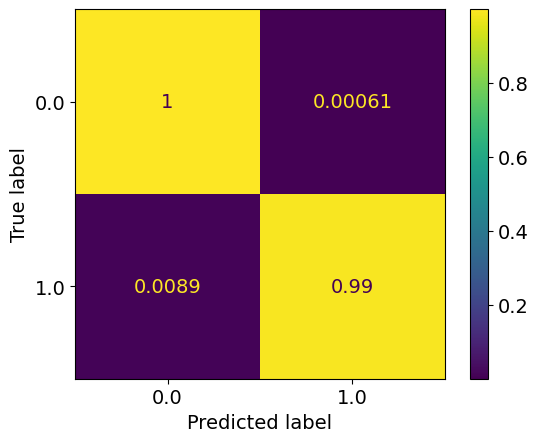

epoch: 490
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0007865776961805872
train acc: 0.9997118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.013825619887276897
test acc: 0.99714327
epoch: 491
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0006722511855200613
train acc: 0.99977446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.014931164857283448
test acc: 0.99729365
epoch: 492
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0006782648550977601
train acc: 0.9997995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.0135913228004938
test acc: 0.9972435
epoch: 493
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0005814058311226466
train acc: 0.999787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.01634344807466197
test acc: 0.9972435
epoch: 494
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0005747757099602971
train acc: 0.9998371


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.013897542087025774
test acc: 0.9972435
epoch: 495
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0006066909068198059
train acc: 0.99977446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.013335592630028259
test acc: 0.9971934
epoch: 496
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0006573350718017944
train acc: 0.99977446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.70it/s]


test loss: 0.013158198588424805
test acc: 0.99729365
epoch: 497
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0005925146995162037
train acc: 0.9998496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.48it/s]


test loss: 0.013132639923910842
test acc: 0.9971934
epoch: 498
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.0005977950346454263
train acc: 0.99973685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.013136103384766784
test acc: 0.9971934
epoch: 499
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.0005689824749955626
train acc: 0.9998246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.01313375831352747
test acc: 0.9971934


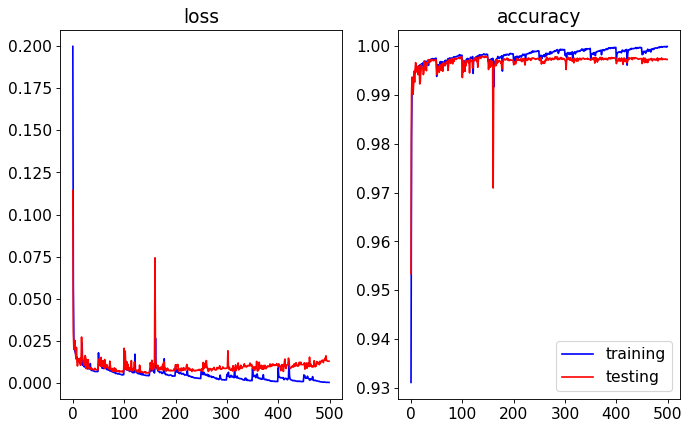

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


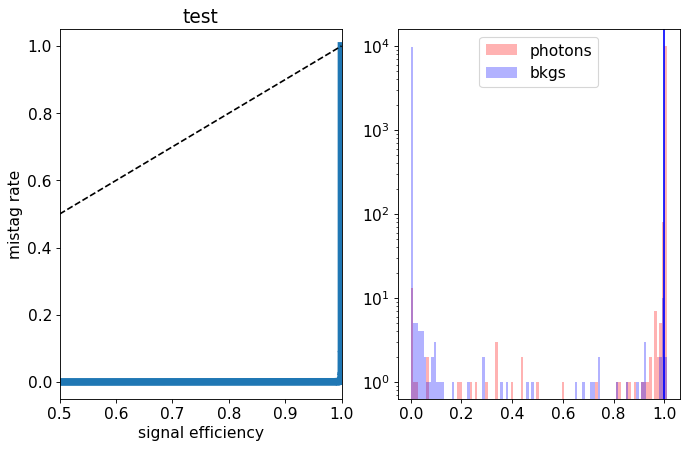

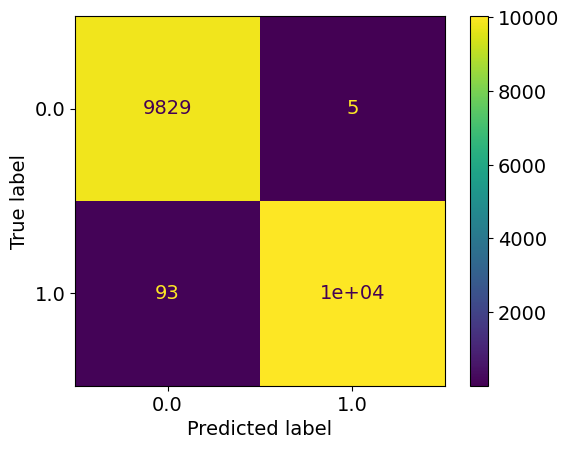

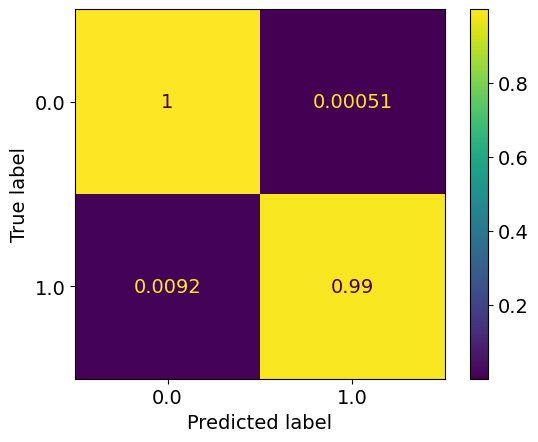

In [16]:
from tqdm import tqdm as tqdm

## OUTPUT directory
checkpoint_dir = out_dir
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [17]:
#print(epoch_size)

## Inference with model of last epoch

### Confusion matrix and Accuracy on test dataset

In [18]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


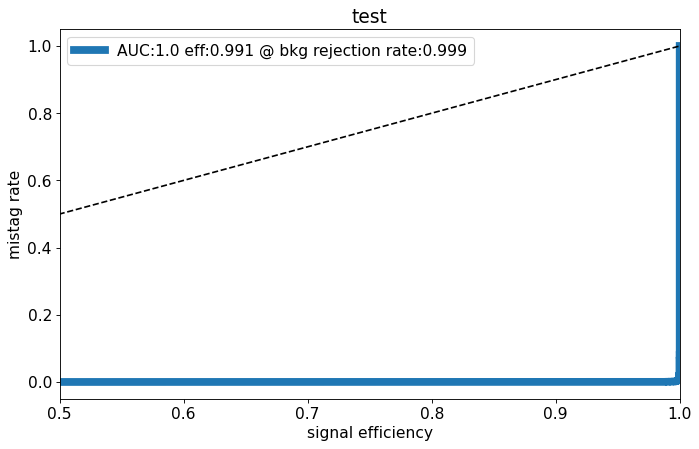

In [19]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

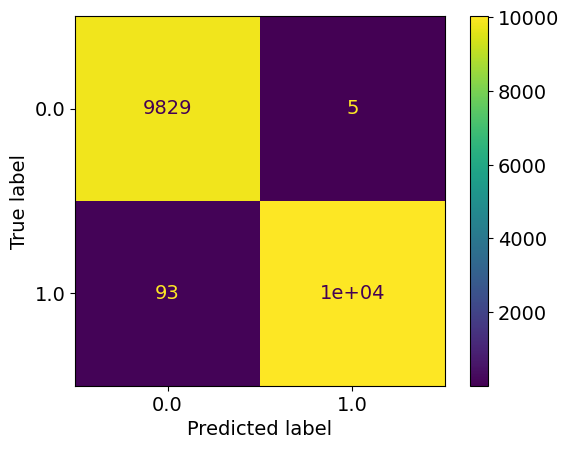

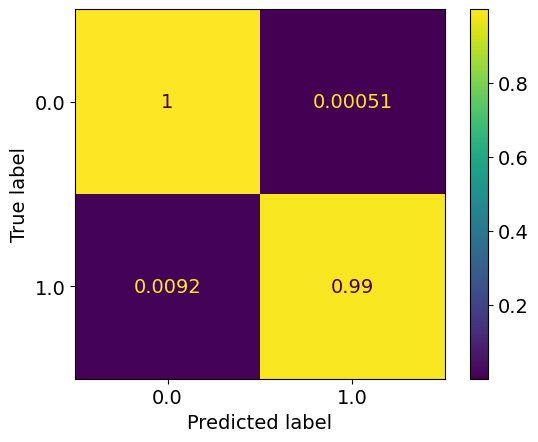

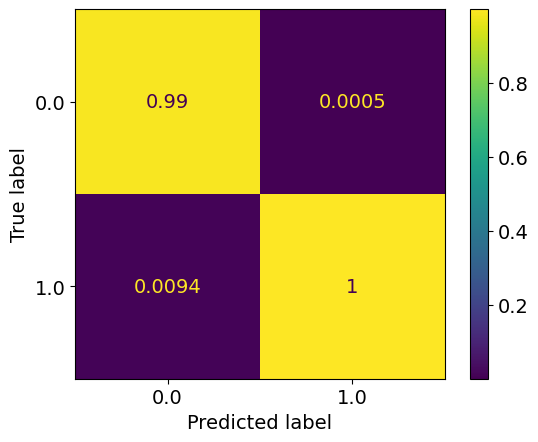

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()

## Inference with model of best accuracy checkpoint

### Load best accuracy checkpoint and define model

In [21]:
### REMEMBER: specify the correct input model

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model_load = torch.load(out_dir+"/model_checkpoint_bestacc.pth.tar")


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model.to(device)
model.load_state_dict(model_load["state_dict"])
model.eval()

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


MHA_model(
  (emb_inp): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ELU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ELU)
  )
  (transformer_encoder): RecursiveScriptModule(
    original_name=TransformerEncoder
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=TransformerEncoderLayer
        (self_attn): RecursiveScriptModule(
          original_name=MultiheadAttention
          (out_proj): RecursiveScriptModule(original_name=NonDynamicallyQuantizableLinear)
        )
        (linear1): RecursiveScriptModule(original_name=Linear)
        (dropout): RecursiveScriptModule(original_name=Dropout)
        (linear2): RecursiveScriptModule(original_name=Linear)
        (norm1): RecursiveScriptModule(original_name=LayerNorm)
        (norm2): RecursiveScriptModule(

### Confusion matrix and accuracy on test dataset (testloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.99789506
threshold : 0.8129709


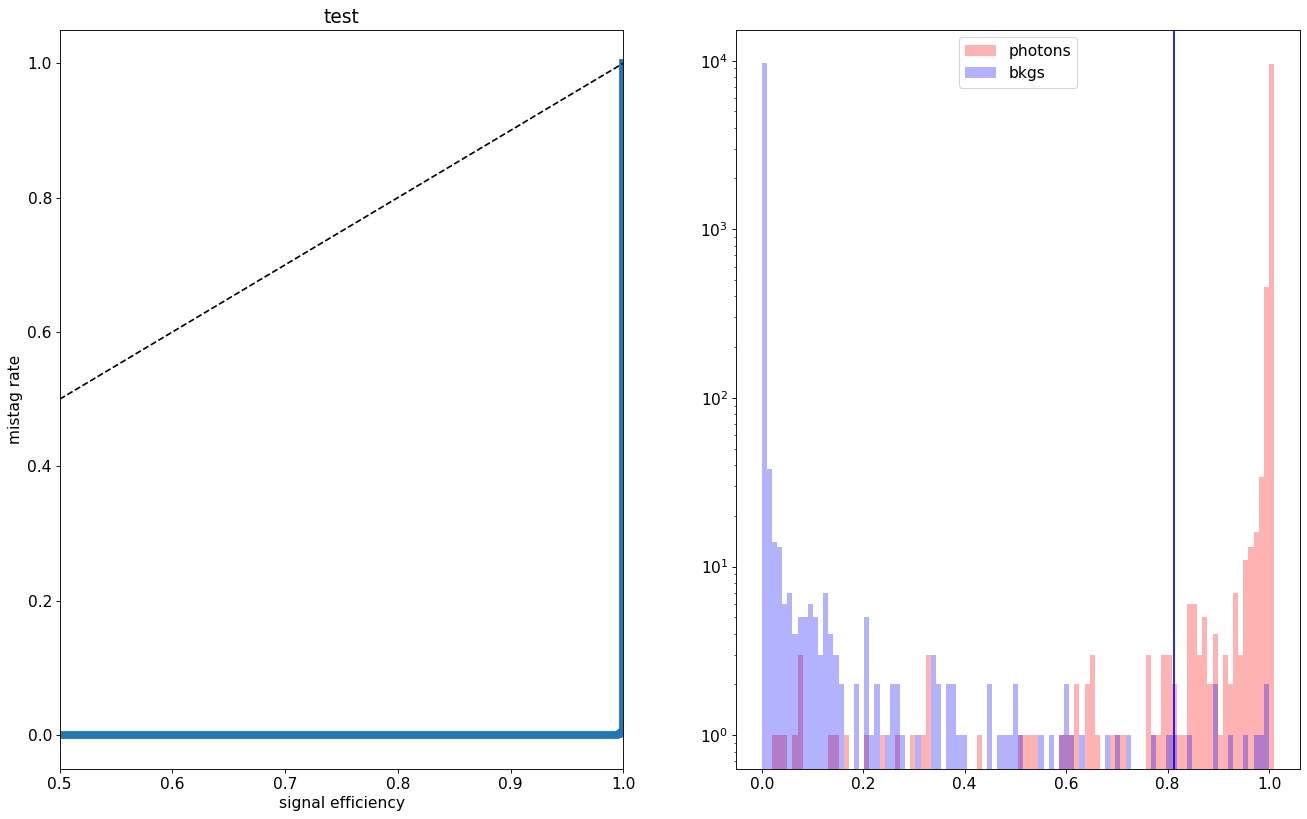

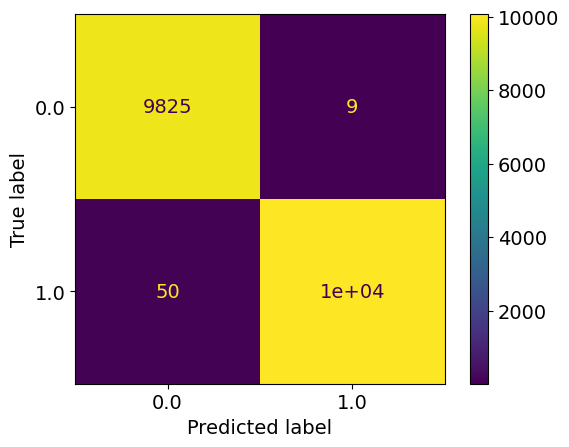

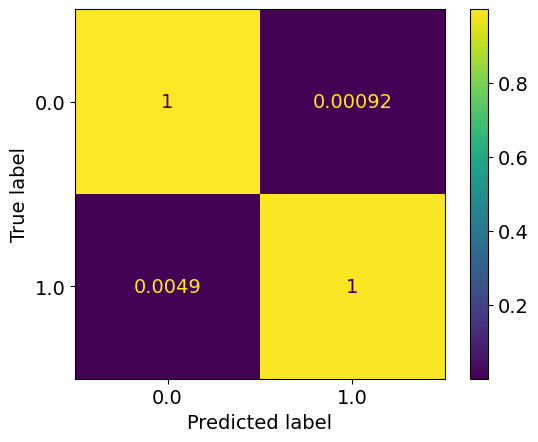

In [22]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

#        opt = np.where(np.hstack(op)>threshold90, 1, 0)
#        if (ip == 1)&(opt == 0):
#            mispredpho.append(datax.detach().cpu().numpy())
#        elif (ip == 0)&(opt == 1):
#            mispredbkg.append(datax.detach().cpu().numpy())

        
        
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_test = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_test = k
        break
print("threshold :",threshold90_test)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_test,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_test, 1, 0), normalize="true")
plt.show()

### Confusion matrix and accuracy on full dataset (totalloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:12<00:00, 13.72it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9982859
threshold : 0.8485298


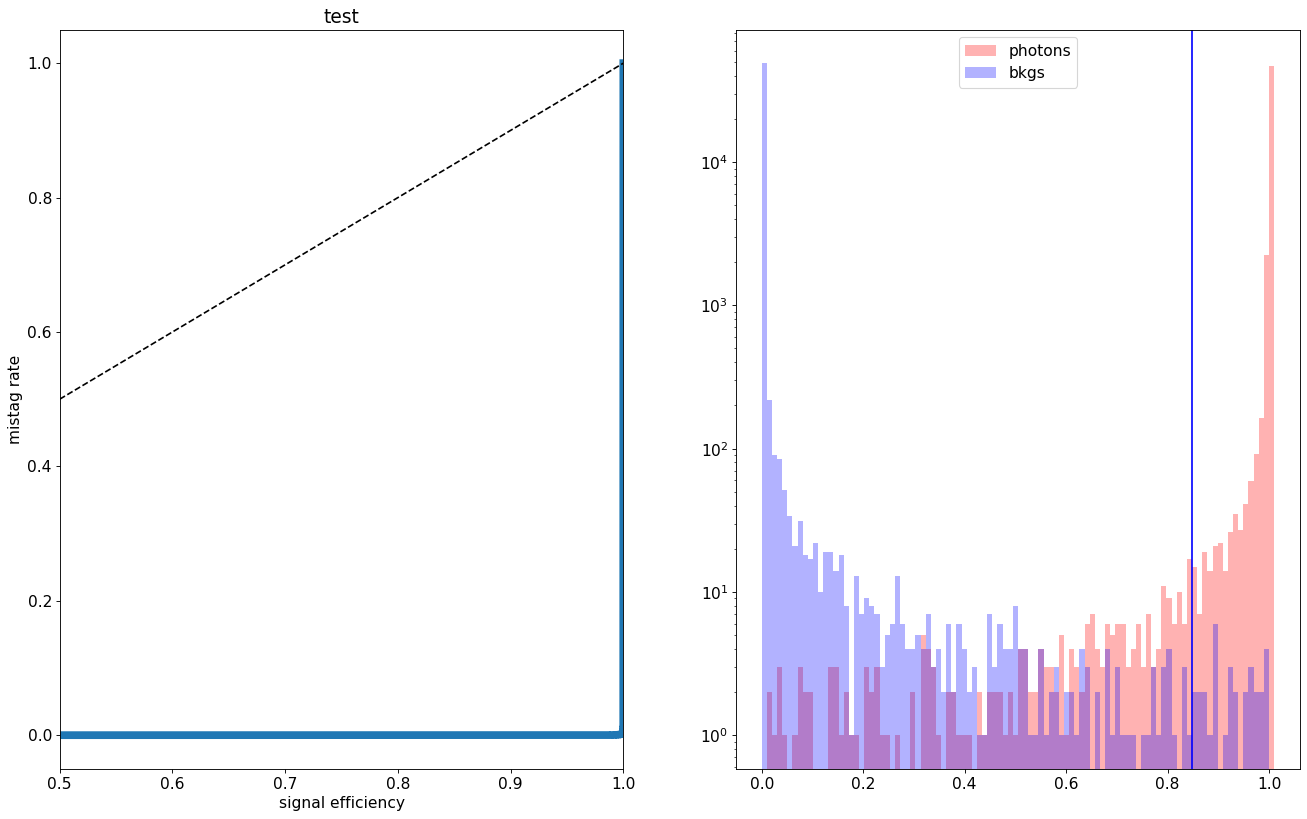

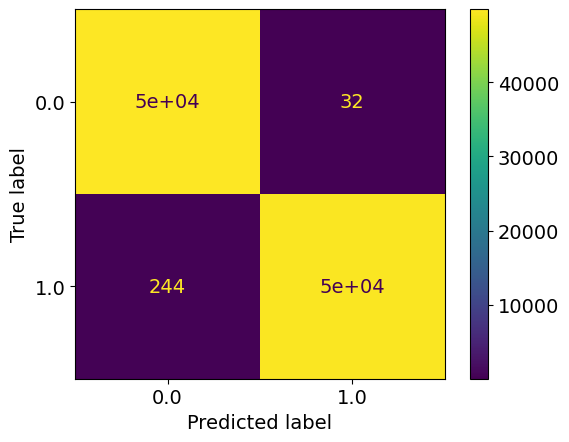

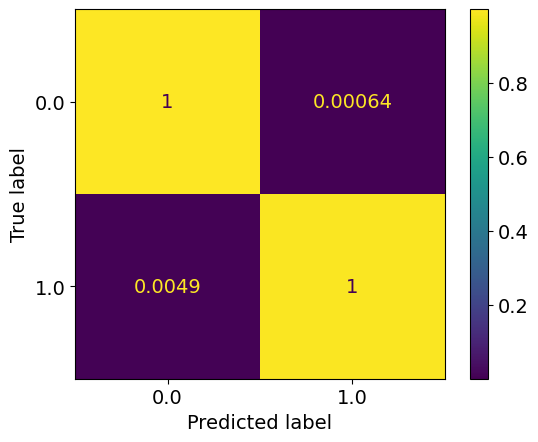

In [23]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
#threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )
     
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90_tot = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90_tot = k
        break
print("threshold :",threshold90_tot)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90_tot,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90_tot, 1, 0), normalize="true")
plt.show()

### Plot mispredicted events

In [24]:
### set batch_size=1
testloader = torch.utils.data.DataLoader(tsdata, batch_size=1,shuffle=True)#, num_workers=2)
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=1,shuffle=True)#, num_workers=2)

#### mispredicted events on test dataset (testloader)

  0%|                                                                                                                         | 0/19953 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19953/19953 [01:24<00:00, 235.63it/s]


threshold 0.8129709
mispred_pho 49


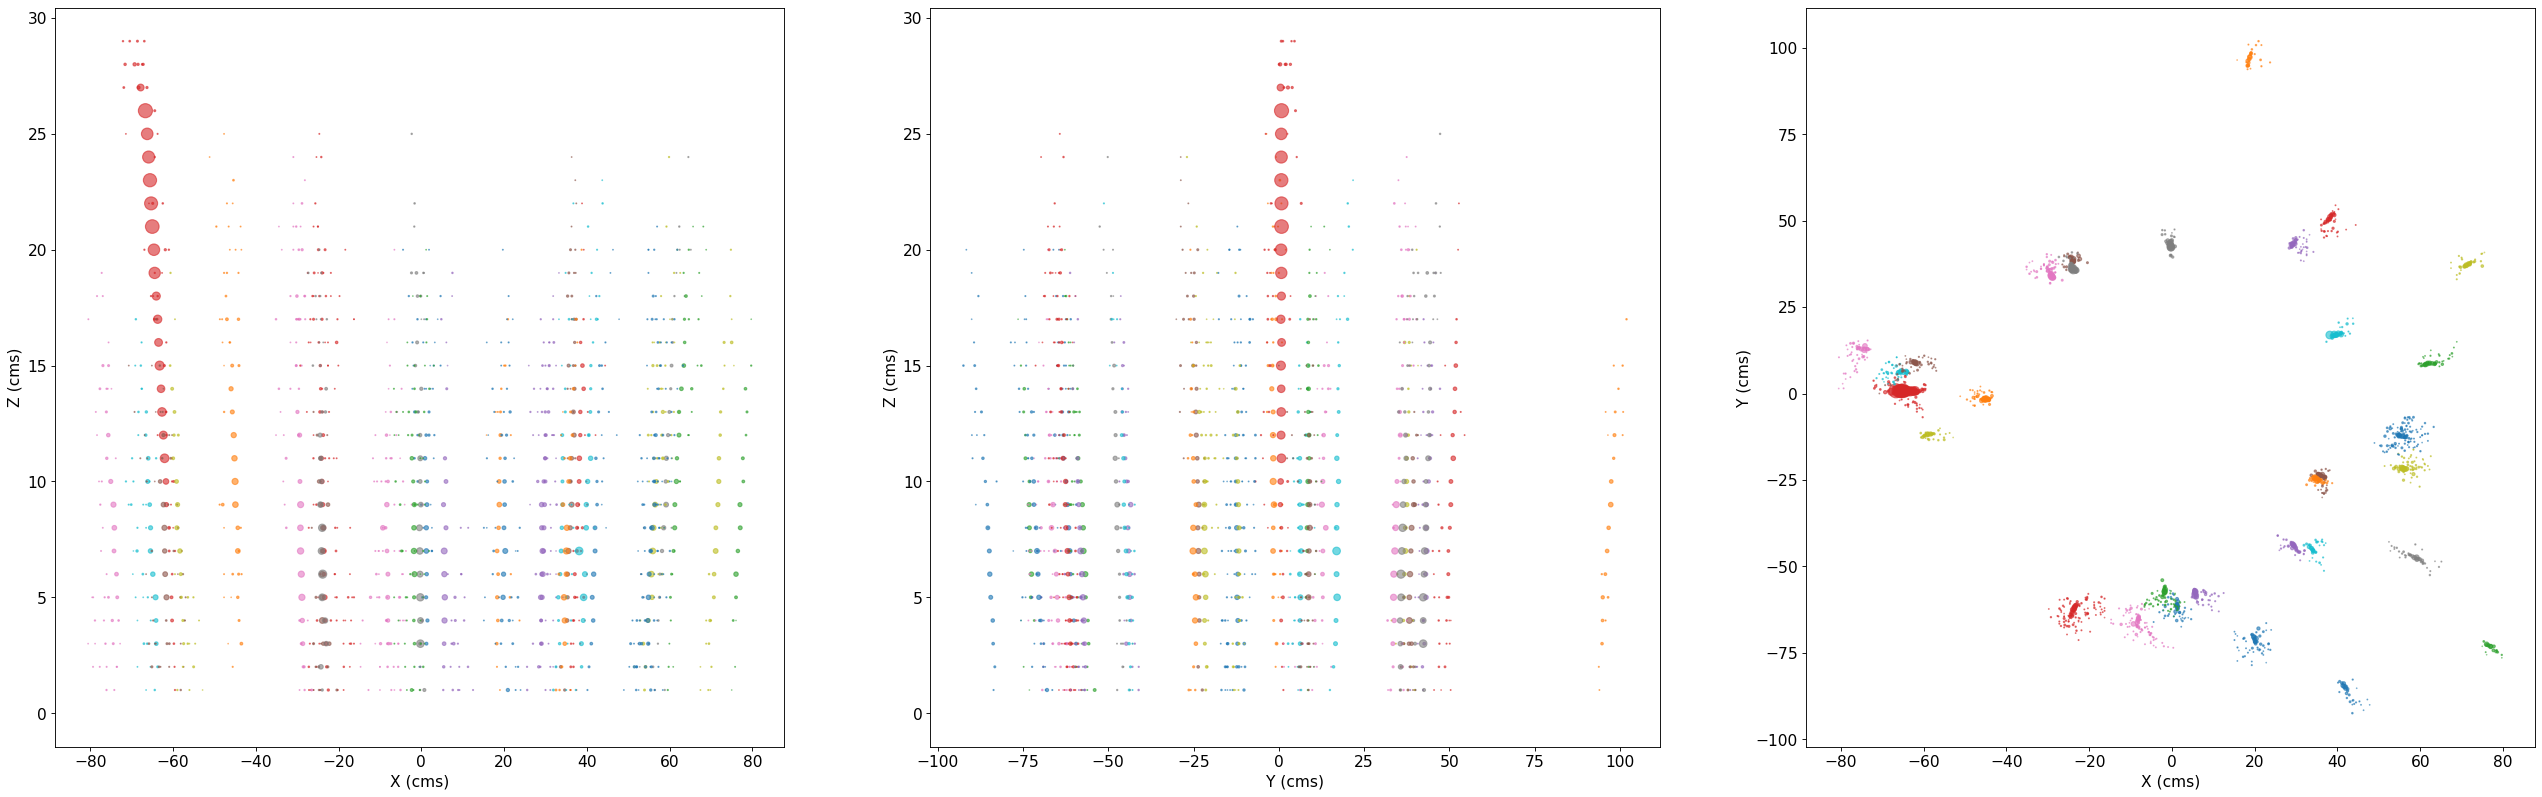

mispred_bkg 9


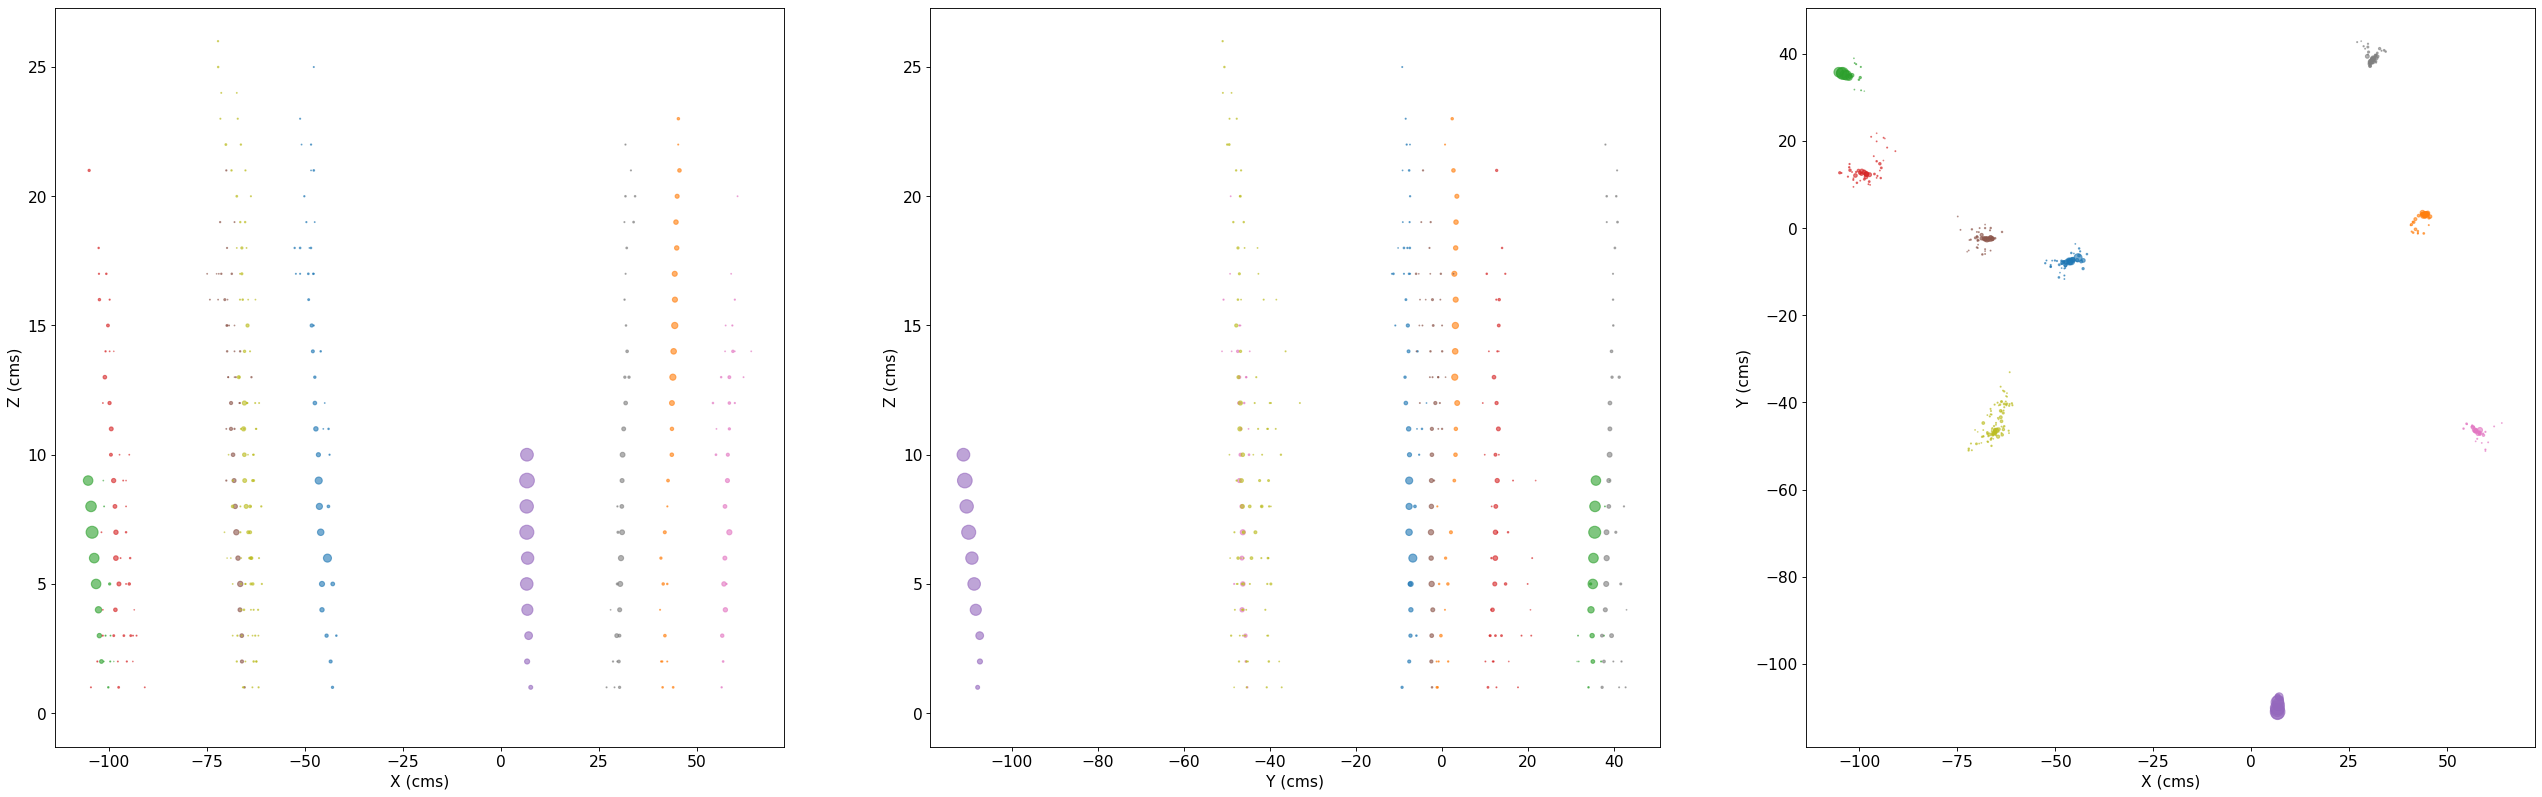

In [25]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_test #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

#### mispredicted events on full dataset (totalloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99761/99761 [07:04<00:00, 234.97it/s]


threshold 0.8485298
mispred_pho 244


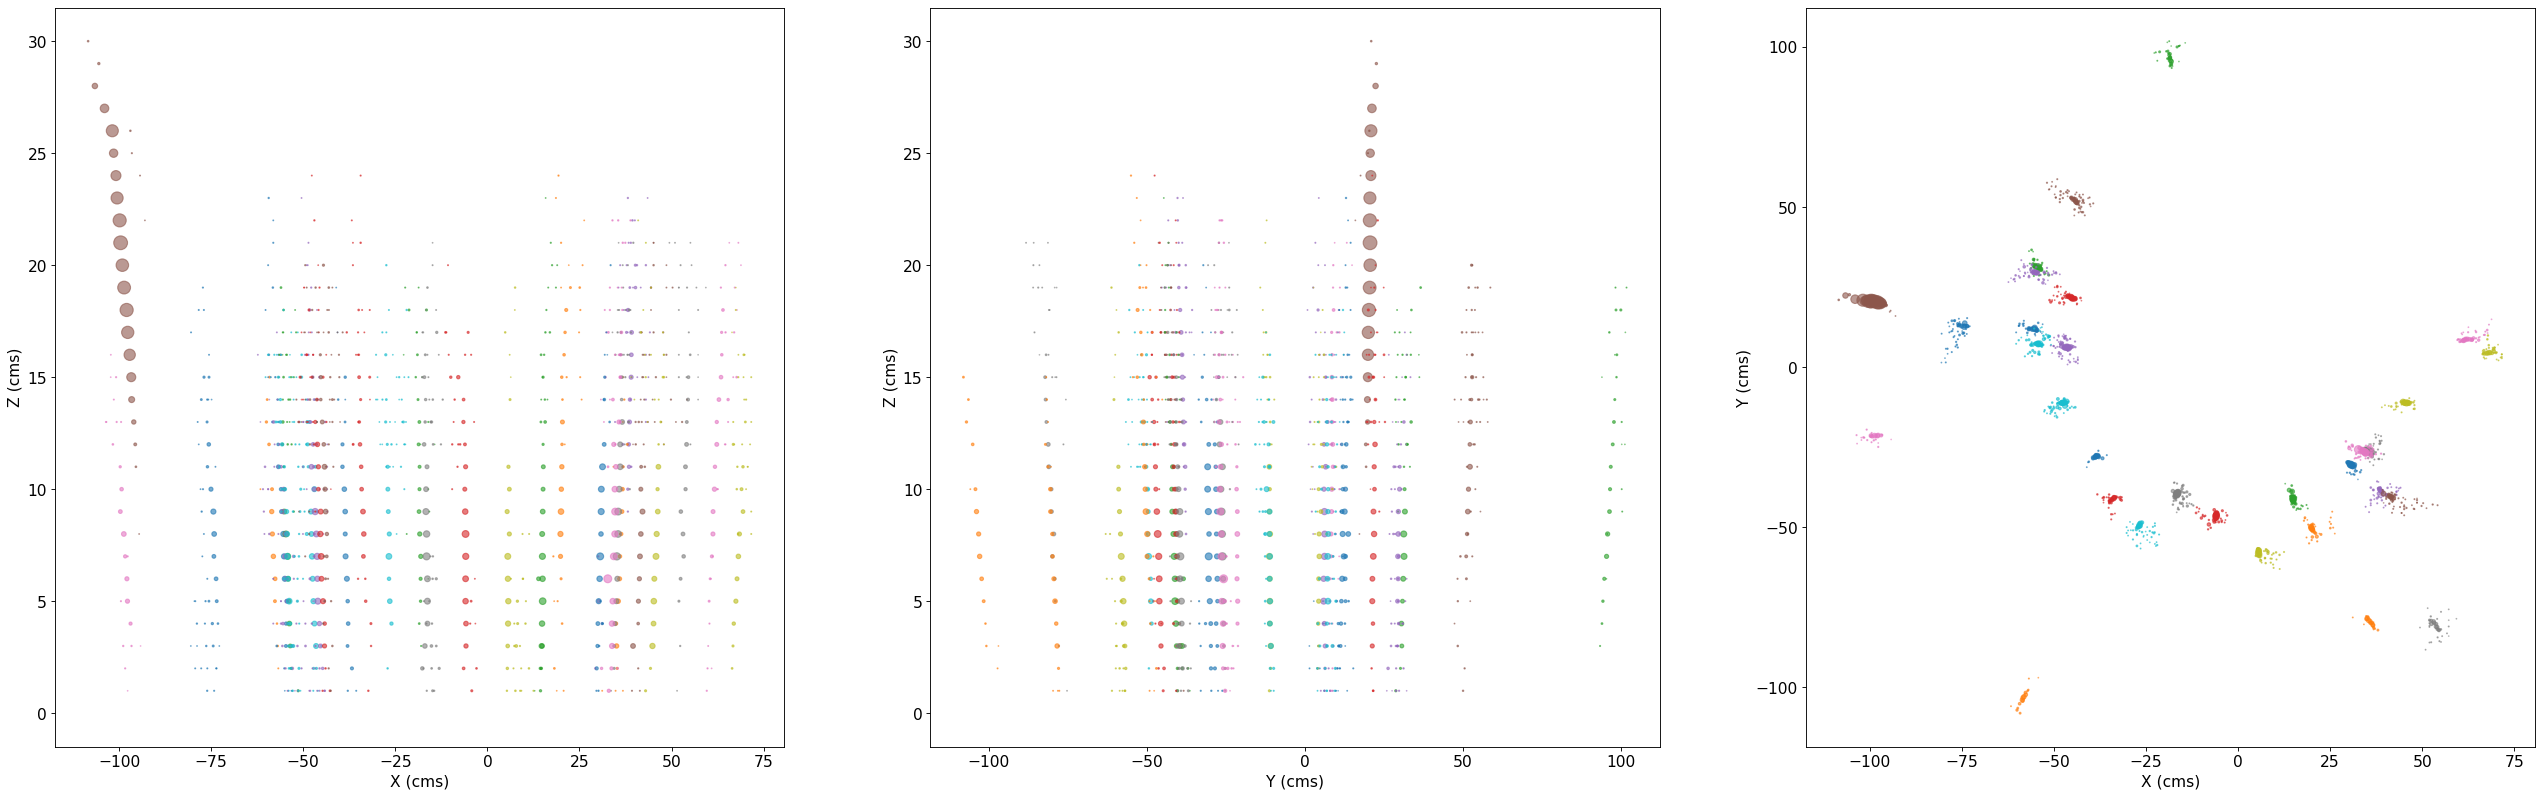

mispred_bkg 32


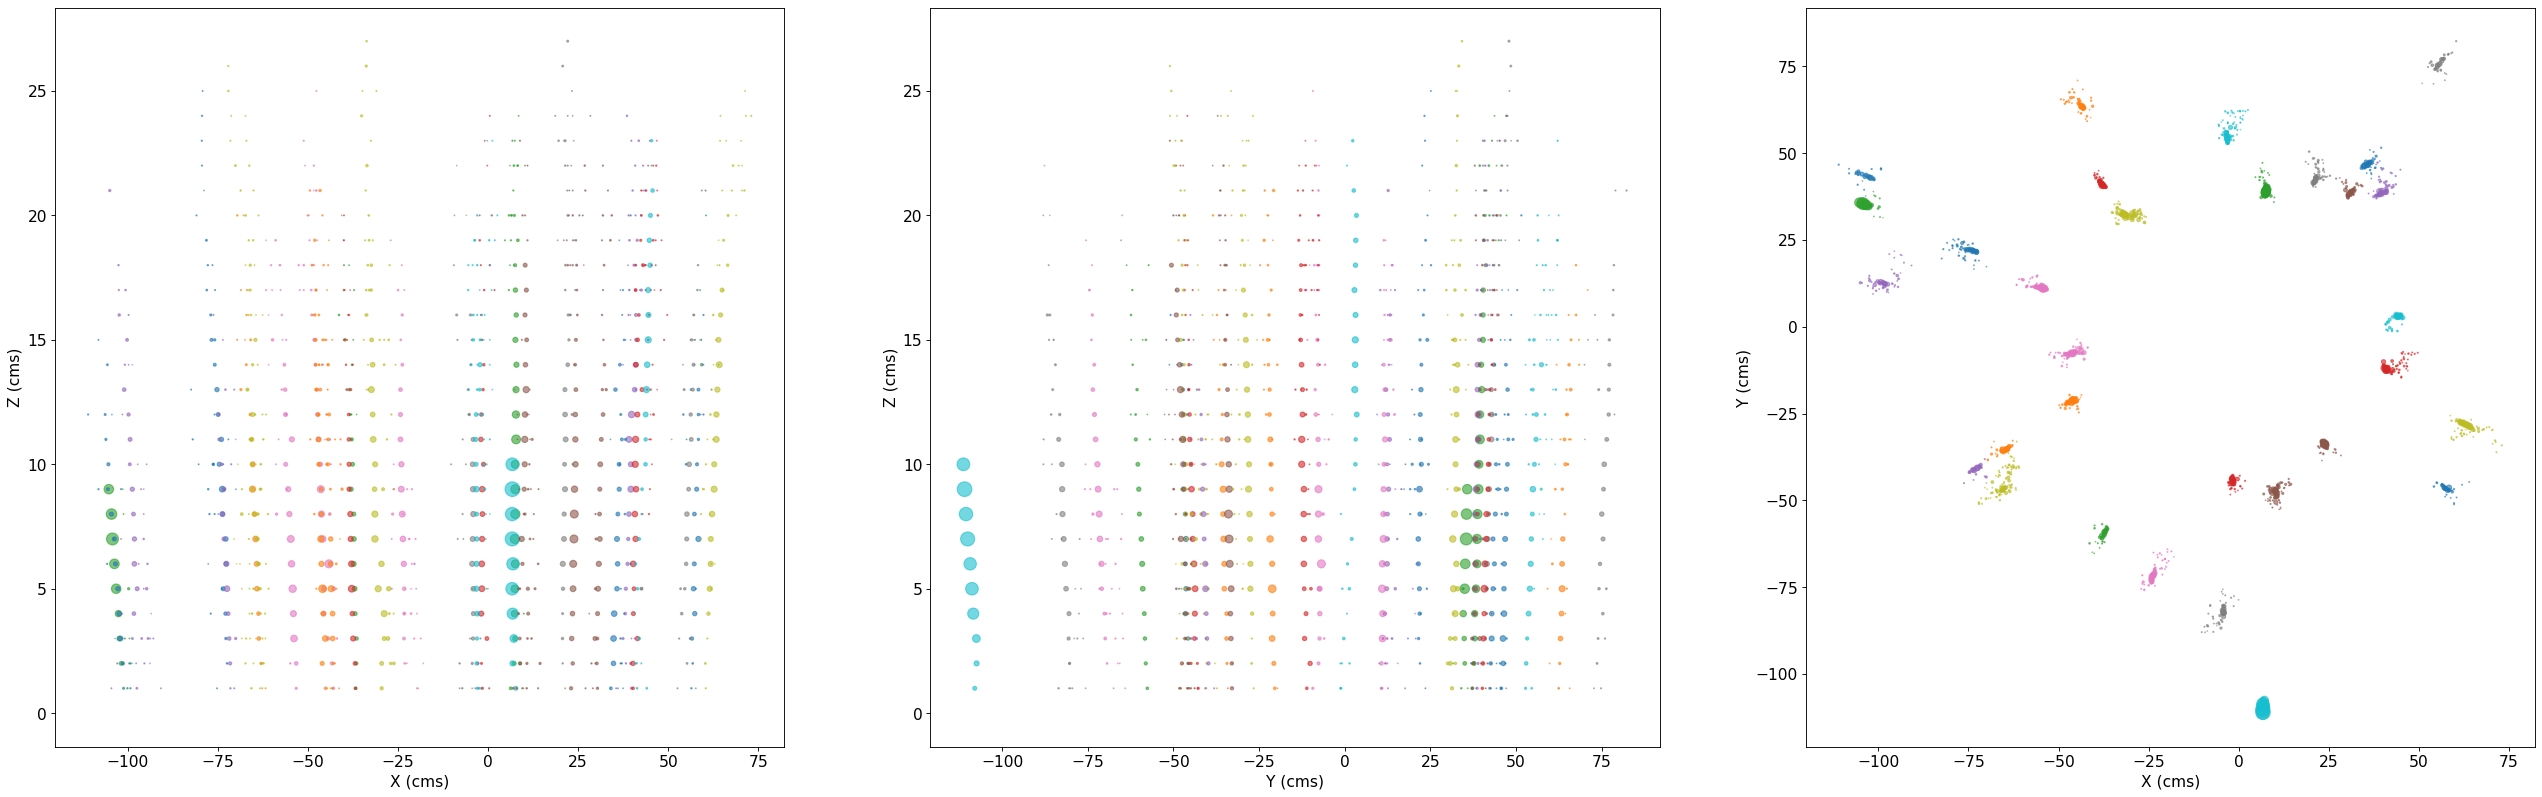

In [26]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = threshold90_tot #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()